In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/OFTALMOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=139.7, y1=108.8
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 280
Page 1, Q1, A: Yellow percentage: 0.0%


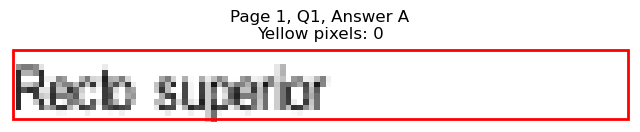

Page 1, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=133.0, y1=121.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 294
Page 1, Q1, B: Yellow percentage: 0.0%


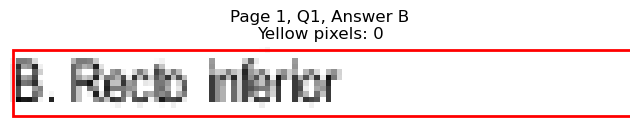

Page 1, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=140.6, y1=133.6
Page 1, Q1, C: Yellow pixels: 593
Page 1, Q1, C: Total non-white pixels: 884
Page 1, Q1, C: Yellow percentage: 67.1%


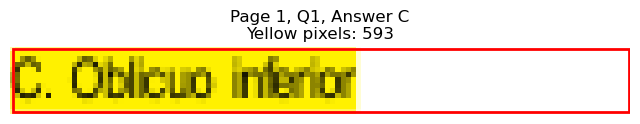

Page 1, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=398.0, y1=108.8
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 359
Page 1, Q1, D: Yellow percentage: 0.0%


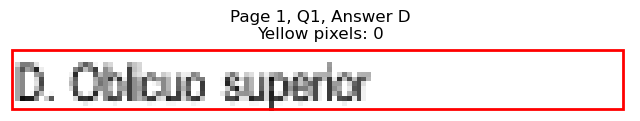

Page 1, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=381.5, y1=121.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 292
Page 1, Q1, E: Yellow percentage: 0.0%


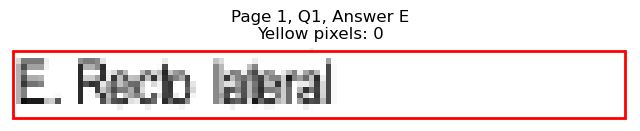


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=179.6, y1=169.6
Page 1, Q2, A: Yellow pixels: 743
Page 1, Q2, A: Total non-white pixels: 1250
Page 1, Q2, A: Yellow percentage: 59.4%


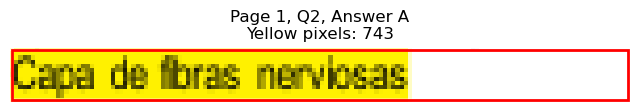

Page 1, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=220.7, y1=181.6
Page 1, Q2, B: Yellow pixels: 94
Page 1, Q2, B: Total non-white pixels: 843
Page 1, Q2, B: Yellow percentage: 11.2%


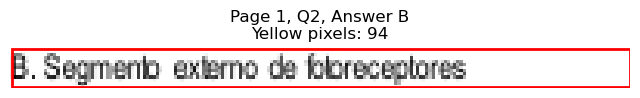

Page 1, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=145.0, y1=193.6
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 508
Page 1, Q2, C: Yellow percentage: 0.0%


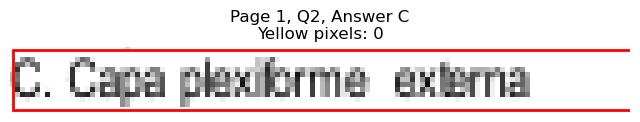

Page 1, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=452.8, y1=169.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 656
Page 1, Q2, D: Yellow percentage: 0.0%


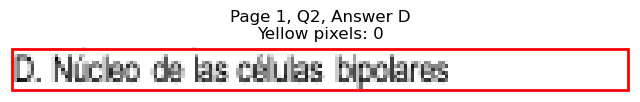

Page 1, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=407.8, y1=181.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 577
Page 1, Q2, E: Yellow percentage: 0.0%


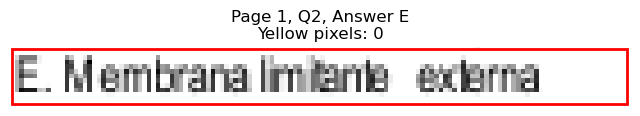


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=138.9, y0=217.6, x1=245.5, y1=229.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 519
Page 1, Q3, A: Yellow percentage: 0.0%


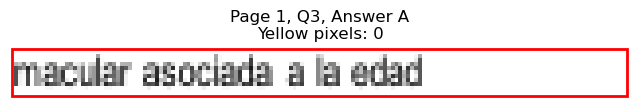

Page 1, Q3 - B: Detected box: x0=180.8, y0=229.6, x1=247.9, y1=241.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 363
Page 1, Q3, B: Yellow percentage: 0.0%


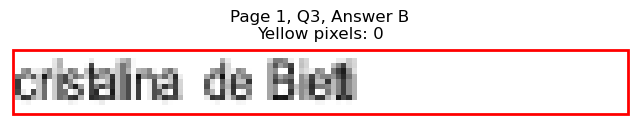

Page 1, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=157.7, y1=253.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 409
Page 1, Q3, C: Yellow percentage: 0.0%


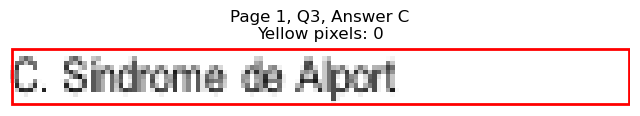

Page 1, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=430.4, y1=229.7
Page 1, Q3, D: Yellow pixels: 818
Page 1, Q3, D: Total non-white pixels: 1390
Page 1, Q3, D: Yellow percentage: 58.8%


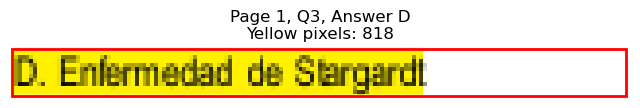

Page 1, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=423.5, y1=241.7
Page 1, Q3, E: Yellow pixels: 105
Page 1, Q3, E: Total non-white pixels: 593
Page 1, Q3, E: Yellow percentage: 17.7%


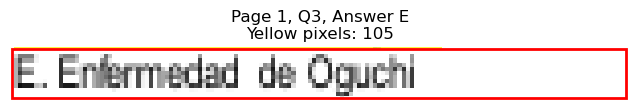


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=154.6, y0=289.7, x1=236.5, y1=301.8
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 417
Page 1, Q4, A: Yellow percentage: 0.0%


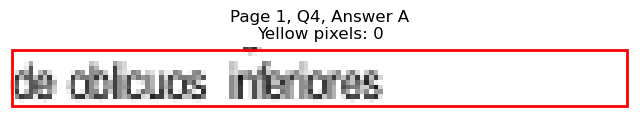

Page 1, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=151.0, y1=314.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 603
Page 1, Q4, B: Yellow percentage: 0.0%


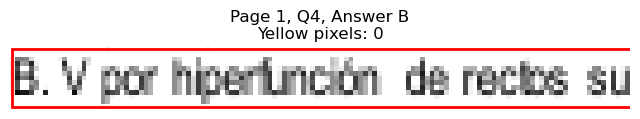

Page 1, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=148.0, y1=326.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 574
Page 1, Q4, C: Yellow percentage: 0.0%


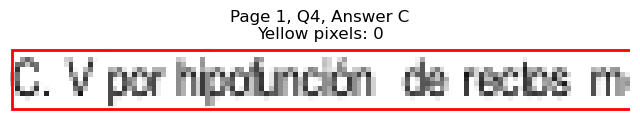

Page 1, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=402.5, y1=301.8
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 609
Page 1, Q4, D: Yellow percentage: 0.0%


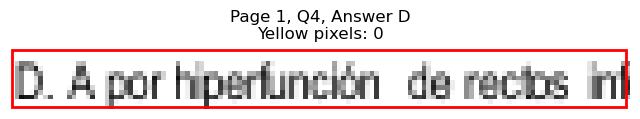

Page 1, Q4 - E: Detected box: x0=405.4, y0=302.5, x1=493.5, y1=314.5
Page 1, Q4, E: Yellow pixels: 767
Page 1, Q4, E: Total non-white pixels: 1131
Page 1, Q4, E: Yellow percentage: 67.8%


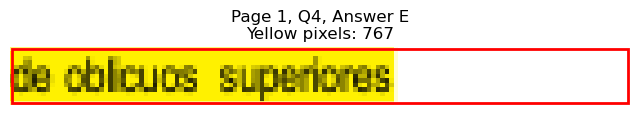


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=121.7, y1=374.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 194
Page 1, Q5, A: Yellow percentage: 0.0%


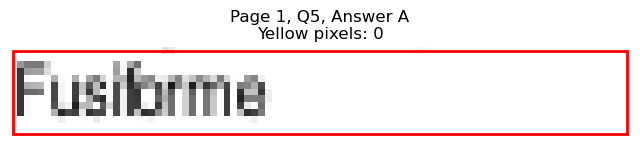

Page 1, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=118.7, y1=386.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 234
Page 1, Q5, B: Yellow percentage: 0.0%


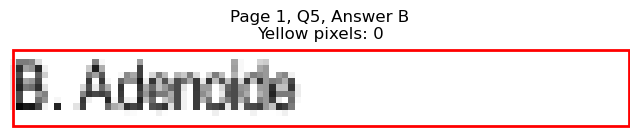

Page 1, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=105.3, y1=398.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 136
Page 1, Q5, C: Yellow percentage: 0.0%


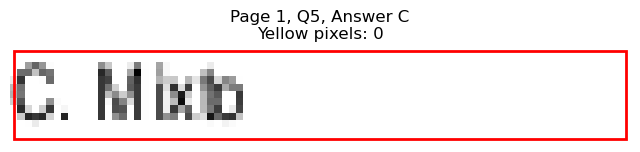

Page 1, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=372.6, y1=374.6
Page 1, Q5, D: Yellow pixels: 386
Page 1, Q5, D: Total non-white pixels: 637
Page 1, Q5, D: Yellow percentage: 60.6%


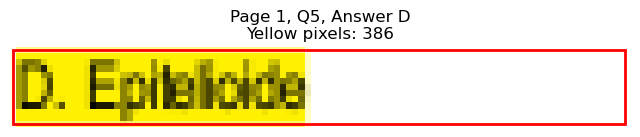

Page 1, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=366.5, y1=386.6
Page 1, Q5, E: Yellow pixels: 47
Page 1, Q5, E: Total non-white pixels: 258
Page 1, Q5, E: Yellow percentage: 18.2%


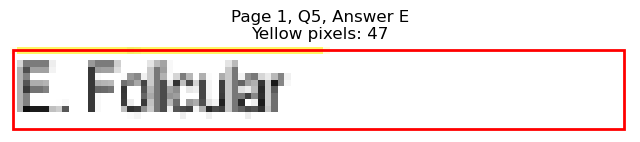


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=187.9, y1=458.6
Page 1, Q6, A: Yellow pixels: 845
Page 1, Q6, A: Total non-white pixels: 1352
Page 1, Q6, A: Yellow percentage: 62.5%


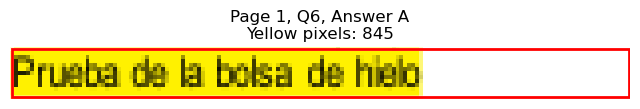

Page 1, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=130.7, y1=470.6
Page 1, Q6, B: Yellow pixels: 98
Page 1, Q6, B: Total non-white pixels: 657
Page 1, Q6, B: Yellow percentage: 14.9%


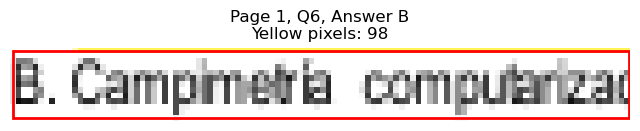

Page 1, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=195.2, y1=482.6
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 598
Page 1, Q6, C: Yellow percentage: 0.0%


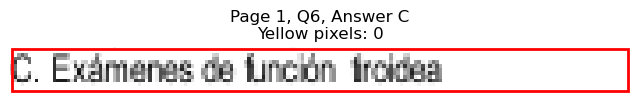

Page 1, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=431.0, y1=458.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 516
Page 1, Q6, D: Yellow percentage: 0.0%


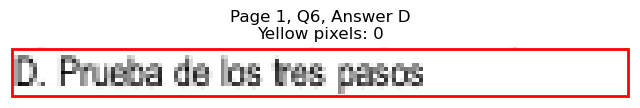

Page 1, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=455.1, y1=470.6
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 626
Page 1, Q6, E: Yellow percentage: 0.0%


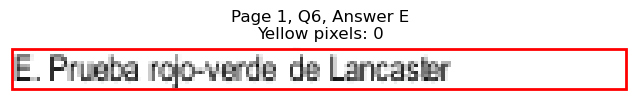


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=122.3, y0=507.4, x1=169.8, y1=519.4
Page 1, Q7, A: Yellow pixels: 387
Page 1, Q7, A: Total non-white pixels: 598
Page 1, Q7, A: Yellow percentage: 64.7%


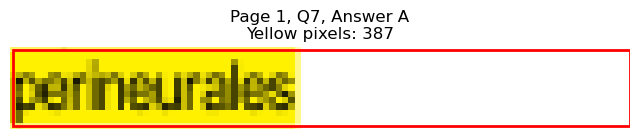

Page 1, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=141.2, y1=531.4
Page 1, Q7, B: Yellow pixels: 84
Page 1, Q7, B: Total non-white pixels: 444
Page 1, Q7, B: Yellow percentage: 18.9%


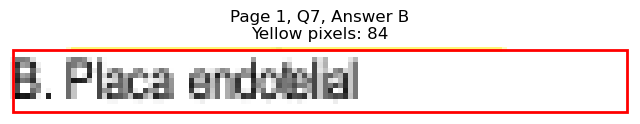

Page 1, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=145.7, y1=543.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 355
Page 1, Q7, C: Yellow percentage: 0.0%


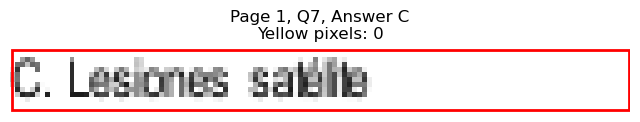

Page 1, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=395.0, y1=519.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 382
Page 1, Q7, D: Yellow percentage: 0.0%


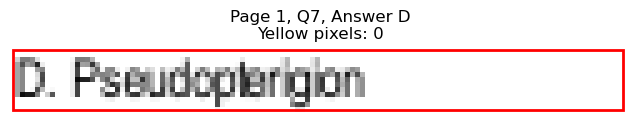

Page 1, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=360.5, y1=531.4
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 191
Page 1, Q7, E: Yellow percentage: 0.0%


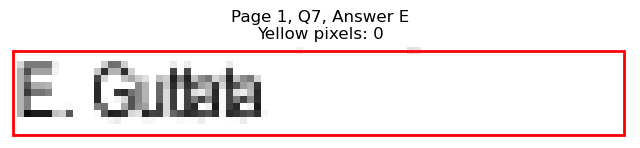


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=175.7, y1=579.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 690
Page 1, Q8, A: Yellow percentage: 0.0%


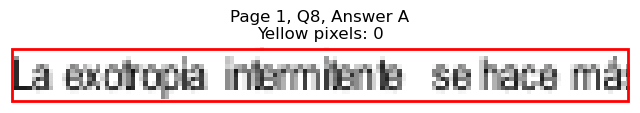

Page 1, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=264.9, y1=603.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 892
Page 1, Q8, B: Yellow percentage: 0.0%


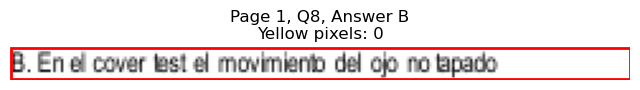

Page 1, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=199.0, y1=627.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 806
Page 1, Q8, C: Yellow percentage: 0.0%


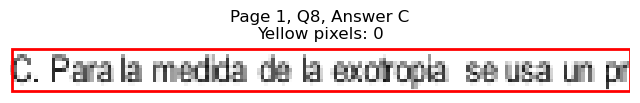

Page 1, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=511.3, y1=579.5
Page 1, Q8, D: Yellow pixels: 1673
Page 1, Q8, D: Total non-white pixels: 2444
Page 1, Q8, D: Yellow percentage: 68.5%


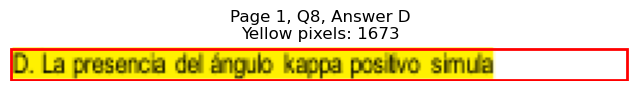

Page 1, Q8 - E: Detected box: x0=439.9, y0=591.5, x1=523.3, y1=603.5
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 413
Page 1, Q8, E: Yellow percentage: 0.0%


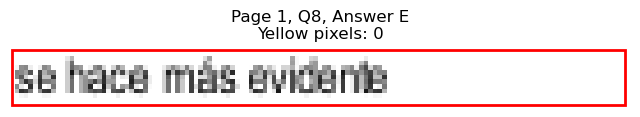


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=688.3, x1=143.5, y1=700.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 322
Page 1, Q9, A: Yellow percentage: 0.0%


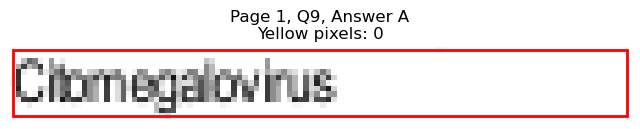

Page 1, Q9 - B: Detected box: x0=71.3, y0=700.3, x1=138.2, y1=712.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 343
Page 1, Q9, B: Yellow percentage: 0.0%


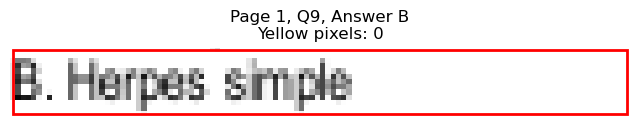

Page 1, Q9 - C: Detected box: x0=71.3, y0=712.3, x1=169.8, y1=724.4
Page 1, Q9, C: Yellow pixels: 788
Page 1, Q9, C: Total non-white pixels: 1261
Page 1, Q9, C: Yellow percentage: 62.5%


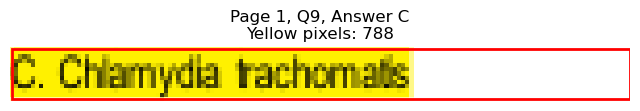

Page 1, Q9 - D: Detected box: x0=322.9, y0=688.3, x1=366.5, y1=700.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 223
Page 1, Q9, D: Yellow percentage: 0.0%


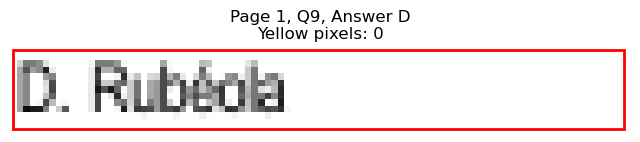

Page 1, Q9 - E: Detected box: x0=322.9, y0=700.3, x1=412.3, y1=712.3
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 440
Page 1, Q9, E: Yellow percentage: 0.0%


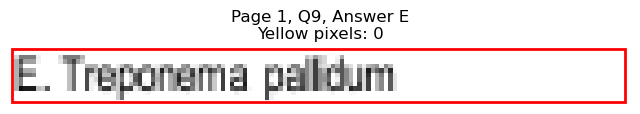


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=82.6, y0=748.4, x1=133.0, y1=760.4
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 250
Page 1, Q10, A: Yellow percentage: 0.0%


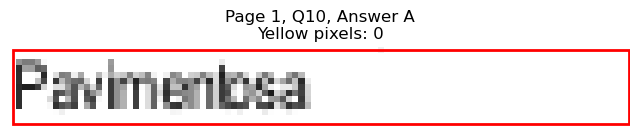

Page 1, Q10 - B: Detected box: x0=71.3, y0=760.4, x1=139.1, y1=772.4
Page 1, Q10, B: Yellow pixels: 583
Page 1, Q10, B: Total non-white pixels: 858
Page 1, Q10, B: Yellow percentage: 67.9%


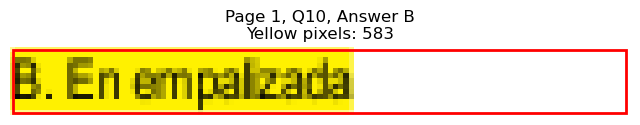

Page 1, Q10 - C: Detected box: x0=71.3, y0=772.4, x1=154.0, y1=784.4
Page 1, Q10, C: Yellow pixels: 64
Page 1, Q10, C: Total non-white pixels: 436
Page 1, Q10, C: Yellow percentage: 14.7%


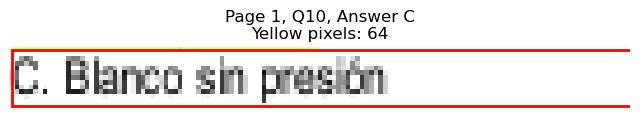

Page 1, Q10 - D: Detected box: x0=322.9, y0=748.4, x1=398.0, y1=760.4
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 359
Page 1, Q10, D: Yellow percentage: 0.0%


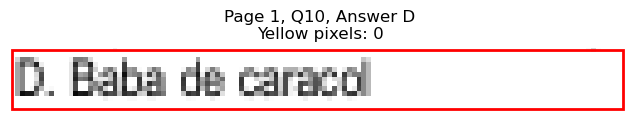

Page 1, Q10 - E: Detected box: x0=322.9, y0=760.4, x1=402.5, y1=772.4
Page 1, Q10, E: Yellow pixels: 0
Page 1, Q10, E: Total non-white pixels: 386
Page 1, Q10, E: Yellow percentage: 0.0%


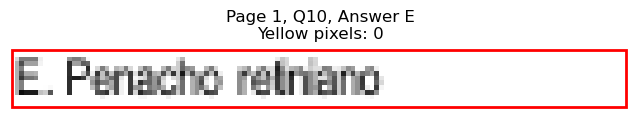


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=128.5, y1=108.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 222
Page 2, Q1, A: Yellow percentage: 0.0%


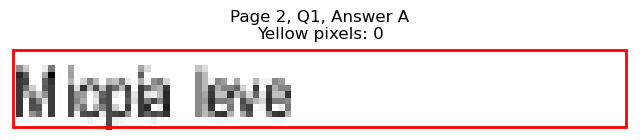

Page 2, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=133.7, y1=121.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 327
Page 2, Q1, B: Yellow percentage: 0.0%


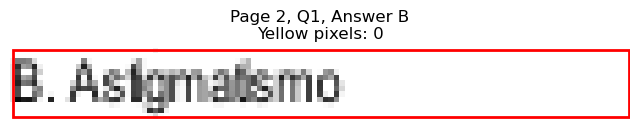

Page 2, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=122.5, y1=133.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 235
Page 2, Q1, C: Yellow percentage: 0.0%


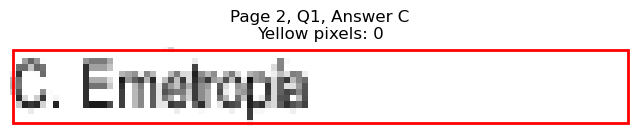

Page 2, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=387.6, y1=108.8
Page 2, Q1, D: Yellow pixels: 486
Page 2, Q1, D: Total non-white pixels: 832
Page 2, Q1, D: Yellow percentage: 58.4%


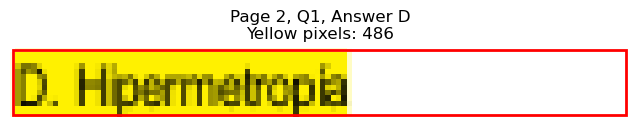

Page 2, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=377.0, y1=121.6
Page 2, Q1, E: Yellow pixels: 62
Page 2, Q1, E: Total non-white pixels: 325
Page 2, Q1, E: Yellow percentage: 19.1%


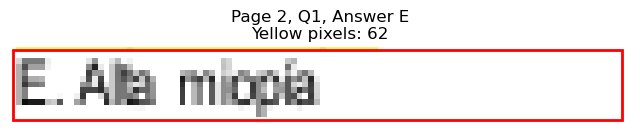


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=135.1, y0=157.6, x1=252.3, y1=169.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 646
Page 2, Q2, A: Yellow percentage: 0.0%


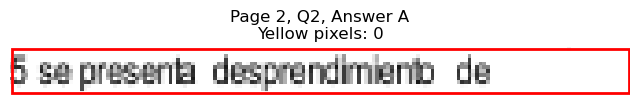

Page 2, Q2 - B: Detected box: x0=140.3, y0=181.6, x1=230.4, y1=193.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 498
Page 2, Q2, B: Yellow percentage: 0.0%


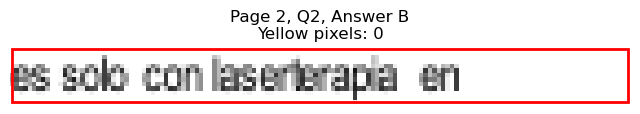

Page 2, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=273.2, y1=217.7
Page 2, Q2, C: Yellow pixels: 1620
Page 2, Q2, C: Total non-white pixels: 2613
Page 2, Q2, C: Yellow percentage: 62.0%


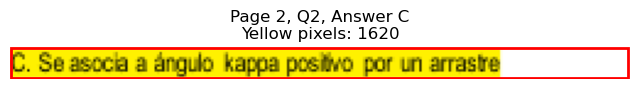

Page 2, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=473.8, y1=169.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 689
Page 2, Q2, D: Yellow percentage: 0.0%


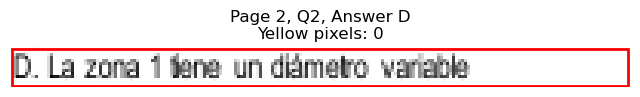

Page 2, Q2 - E: Detected box: x0=394.1, y0=169.6, x1=514.4, y1=181.6
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 591
Page 2, Q2, E: Yellow percentage: 0.0%


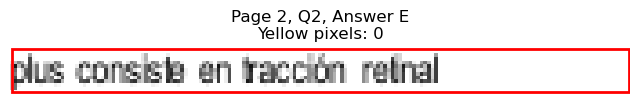


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=71.3, y0=253.6, x1=79.7, y1=265.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 67
Page 2, Q3, A: Yellow percentage: 0.0%


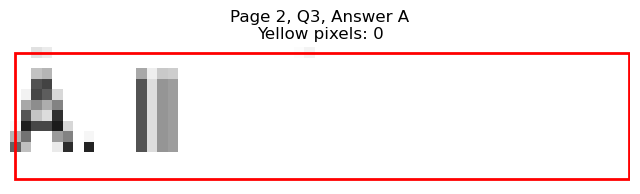

Page 2, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=89.5, y1=277.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 70
Page 2, Q3, B: Yellow percentage: 0.0%


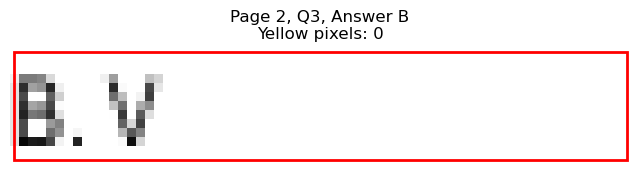

Page 2, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=92.5, y1=289.7
Page 2, Q3, C: Yellow pixels: 174
Page 2, Q3, C: Total non-white pixels: 260
Page 2, Q3, C: Yellow percentage: 66.9%


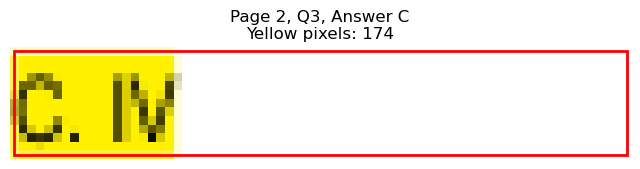

Page 2, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=348.5, y1=265.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 115
Page 2, Q3, D: Yellow percentage: 0.0%


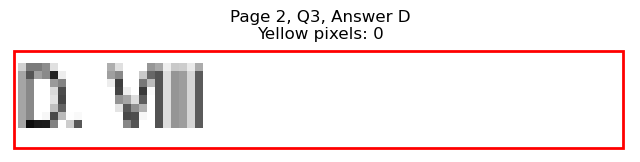

Page 2, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=344.0, y1=277.7
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 76
Page 2, Q3, E: Yellow percentage: 0.0%


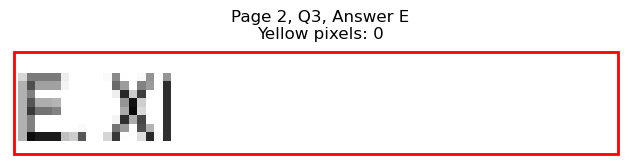


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=127.6, y0=338.5, x1=193.0, y1=350.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 353
Page 2, Q4, A: Yellow percentage: 0.0%


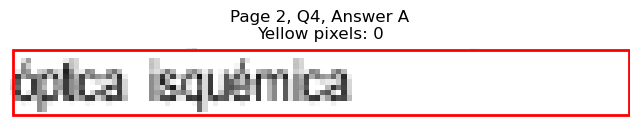

Page 2, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=136.7, y1=362.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 337
Page 2, Q4, B: Yellow percentage: 0.0%


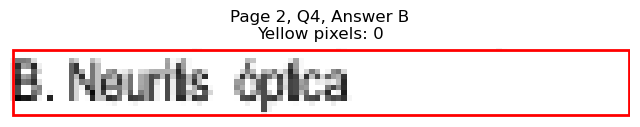

Page 2, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=124.0, y1=374.6
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 465
Page 2, Q4, C: Yellow percentage: 0.0%


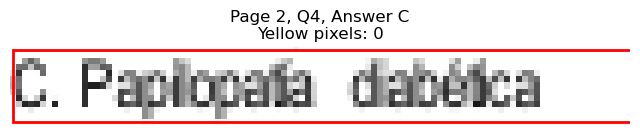

Page 2, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=415.4, y1=350.5
Page 2, Q4, D: Yellow pixels: 806
Page 2, Q4, D: Total non-white pixels: 1196
Page 2, Q4, D: Yellow percentage: 67.4%


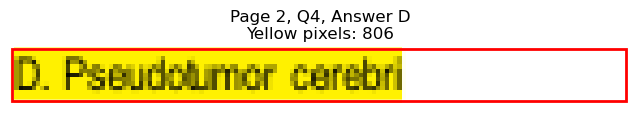

Page 2, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=386.1, y1=362.5
Page 2, Q4, E: Yellow pixels: 90
Page 2, Q4, E: Total non-white pixels: 407
Page 2, Q4, E: Yellow percentage: 22.1%


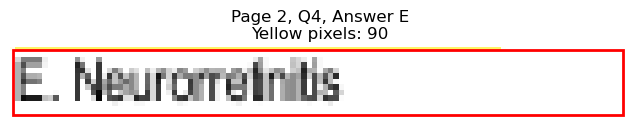


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=144.2, y0=398.5, x1=262.1, y1=410.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 559
Page 2, Q5, A: Yellow percentage: 0.0%


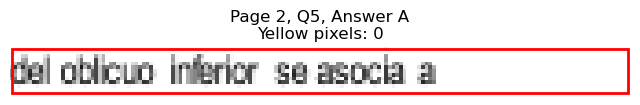

Page 2, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=163.7, y1=434.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 675
Page 2, Q5, B: Yellow percentage: 0.0%


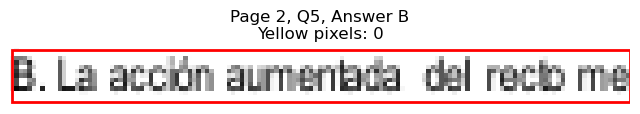

Page 2, Q5 - C: Detected box: x0=131.4, y0=446.6, x1=214.7, y1=458.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 510
Page 2, Q5, C: Yellow percentage: 0.0%


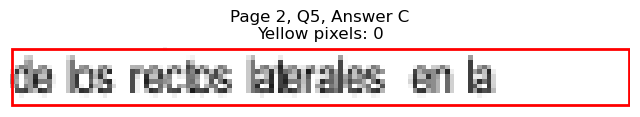

Page 2, Q5 - D: Detected box: x0=382.1, y0=398.5, x1=512.2, y1=410.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 638
Page 2, Q5, D: Yellow percentage: 0.0%


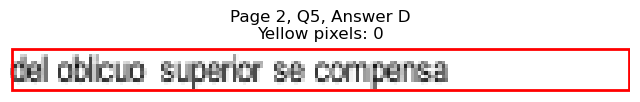

Page 2, Q5 - E: Detected box: x0=391.9, y0=422.5, x1=518.0, y1=434.6
Page 2, Q5, E: Yellow pixels: 1011
Page 2, Q5, E: Total non-white pixels: 1625
Page 2, Q5, E: Yellow percentage: 62.2%


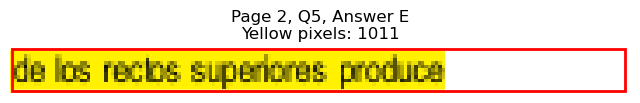


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=495.4, x1=158.6, y1=507.4
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 378
Page 2, Q6, A: Yellow percentage: 0.0%


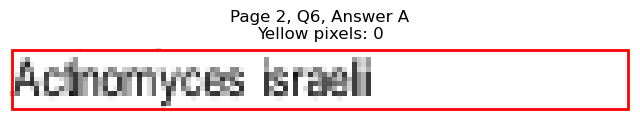

Page 2, Q6 - B: Detected box: x0=71.3, y0=507.4, x1=154.1, y1=519.4
Page 2, Q6, B: Yellow pixels: 717
Page 2, Q6, B: Total non-white pixels: 1053
Page 2, Q6, B: Yellow percentage: 68.1%


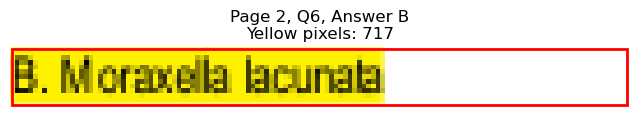

Page 2, Q6 - C: Detected box: x0=71.3, y0=519.4, x1=182.5, y1=531.4
Page 2, Q6, C: Yellow pixels: 79
Page 2, Q6, C: Total non-white pixels: 607
Page 2, Q6, C: Yellow percentage: 13.0%


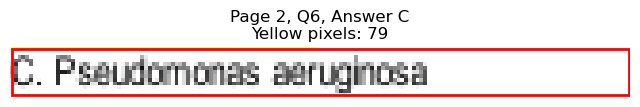

Page 2, Q6 - D: Detected box: x0=322.9, y0=495.4, x1=429.5, y1=507.4
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 536
Page 2, Q6, D: Yellow percentage: 0.0%


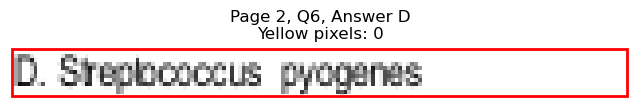

Page 2, Q6 - E: Detected box: x0=322.9, y0=507.4, x1=398.8, y1=519.4
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 629
Page 2, Q6, E: Yellow percentage: 0.0%


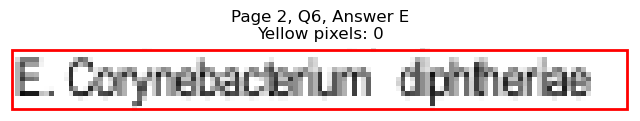


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=567.5, x1=103.0, y1=579.5
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 93
Page 2, Q7, A: Yellow percentage: 0.0%


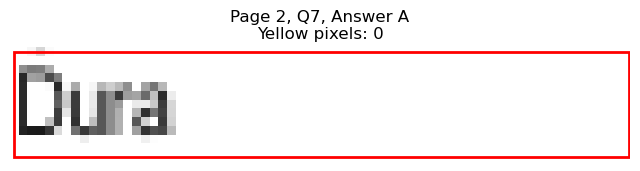

Page 2, Q7 - B: Detected box: x0=71.3, y0=579.4, x1=109.8, y1=591.5
Page 2, Q7, B: Yellow pixels: 313
Page 2, Q7, B: Total non-white pixels: 481
Page 2, Q7, B: Yellow percentage: 65.1%


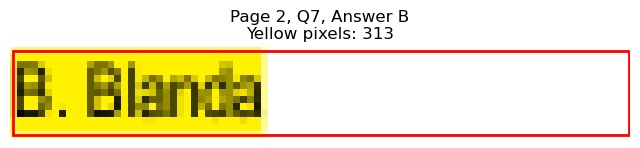

Page 2, Q7 - C: Detected box: x0=71.3, y0=591.5, x1=116.5, y1=603.5
Page 2, Q7, C: Yellow pixels: 35
Page 2, Q7, C: Total non-white pixels: 237
Page 2, Q7, C: Yellow percentage: 14.8%


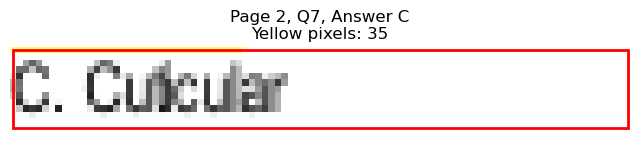

Page 2, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=375.5, y1=579.5
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 270
Page 2, Q7, D: Yellow percentage: 0.0%


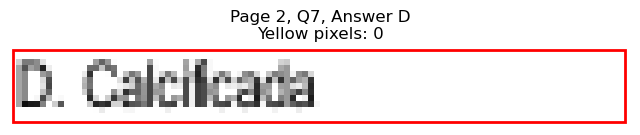

Page 2, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=362.8, y1=591.5
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 190
Page 2, Q7, E: Yellow percentage: 0.0%


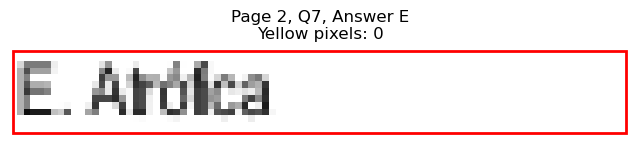


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=268.0, y1=639.6
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 888
Page 2, Q8, A: Yellow percentage: 0.0%


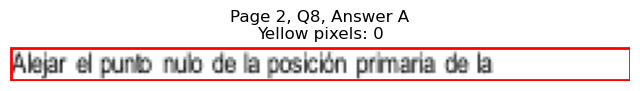

Page 2, Q8 - B: Detected box: x0=71.3, y0=651.5, x1=201.2, y1=663.6
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 630
Page 2, Q8, B: Yellow percentage: 0.0%


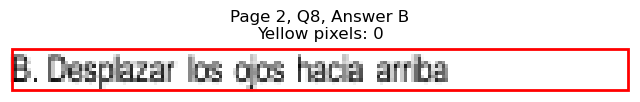

Page 2, Q8 - C: Detected box: x0=71.3, y0=663.5, x1=276.5, y1=675.6
Page 2, Q8, C: Yellow pixels: 1635
Page 2, Q8, C: Total non-white pixels: 2652
Page 2, Q8, C: Yellow percentage: 61.7%


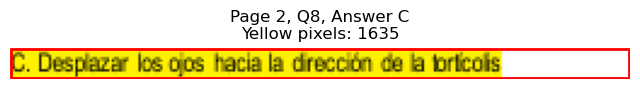

Page 2, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=542.0, y1=639.6
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 1063
Page 2, Q8, D: Yellow percentage: 0.0%


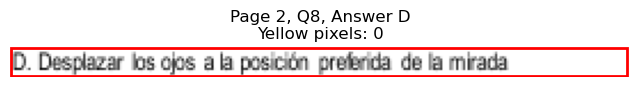

Page 2, Q8 - E: Detected box: x0=322.9, y0=639.5, x1=527.1, y1=651.6
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 968
Page 2, Q8, E: Yellow percentage: 0.0%


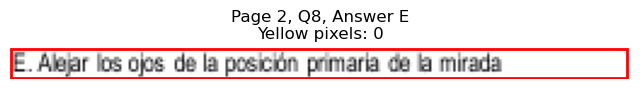


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=121.0, y1=712.3
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 203
Page 2, Q9, A: Yellow percentage: 0.0%


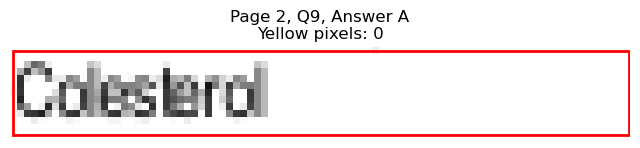

Page 2, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=106.8, y1=724.4
Page 2, Q9, B: Yellow pixels: 269
Page 2, Q9, B: Total non-white pixels: 442
Page 2, Q9, B: Yellow percentage: 60.9%


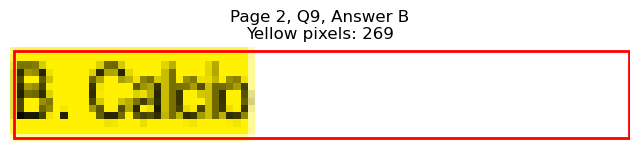

Page 2, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=116.5, y1=736.4
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 239
Page 2, Q9, C: Yellow percentage: 0.0%


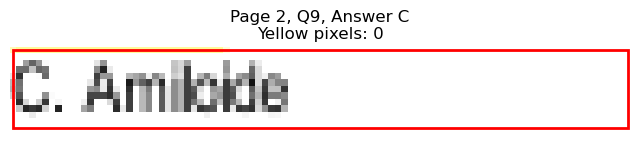

Page 2, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=359.0, y1=712.3
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 172
Page 2, Q9, D: Yellow percentage: 0.0%


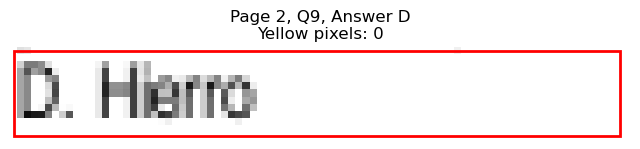

Page 2, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=362.1, y1=724.4
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 158
Page 2, Q9, E: Yellow percentage: 0.0%


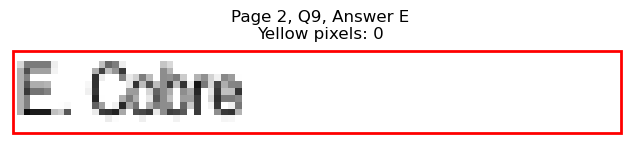


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=185.3, y0=96.8, x1=285.9, y1=108.8
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 552
Page 3, Q1, A: Yellow percentage: 0.0%


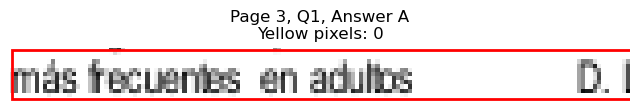

Page 3, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=160.7, y1=121.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 664
Page 3, Q1, B: Yellow percentage: 0.0%


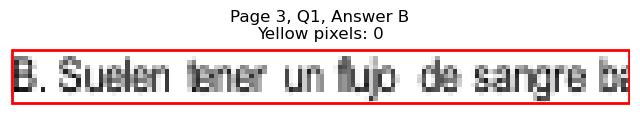

Page 3, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=287.7, y1=133.6
Page 3, Q1, C: Yellow pixels: 1950
Page 3, Q1, C: Total non-white pixels: 2878
Page 3, Q1, C: Yellow percentage: 67.8%


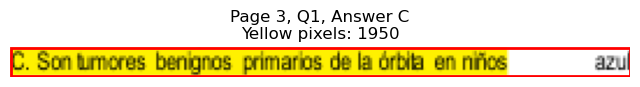

Page 3, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=502.2, y1=108.8
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 827
Page 3, Q1, D: Yellow percentage: 0.0%


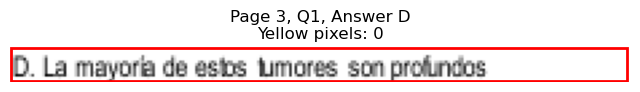

Page 3, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=416.0, y1=121.6
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 704
Page 3, Q1, E: Yellow percentage: 0.0%


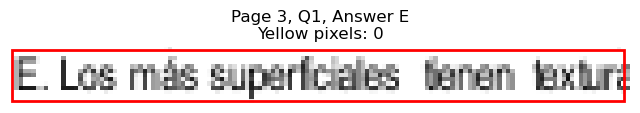


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=200.5, y1=169.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 788
Page 3, Q2, A: Yellow percentage: 0.0%


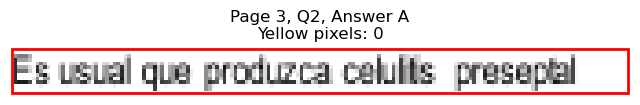

Page 3, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=189.2, y1=181.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 805
Page 3, Q2, B: Yellow percentage: 0.0%


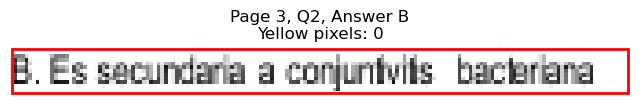

Page 3, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=185.5, y1=193.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 762
Page 3, Q2, C: Yellow percentage: 0.0%


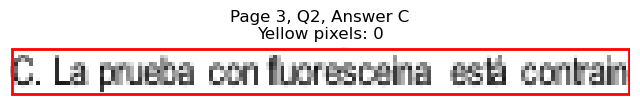

Page 3, Q2 - D: Detected box: x0=71.3, y0=193.6, x1=251.4, y1=205.6
Page 3, Q2, D: Yellow pixels: 1469
Page 3, Q2, D: Total non-white pixels: 2327
Page 3, Q2, D: Yellow percentage: 63.1%


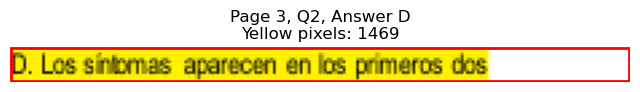

Page 3, Q2 - E: Detected box: x0=322.9, y0=157.6, x1=495.7, y1=169.6
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 799
Page 3, Q2, E: Yellow percentage: 0.0%


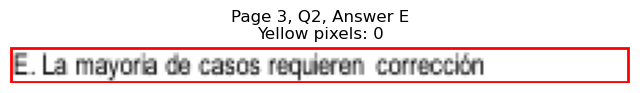


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=134.5, y1=265.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 262
Page 3, Q3, A: Yellow percentage: 0.0%


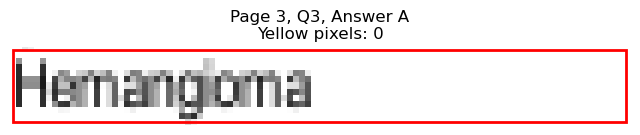

Page 3, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=124.0, y1=277.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 261
Page 3, Q3, B: Yellow percentage: 0.0%


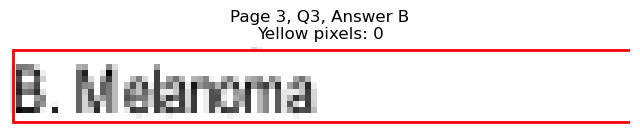

Page 3, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=112.0, y1=289.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 167
Page 3, Q3, C: Yellow percentage: 0.0%


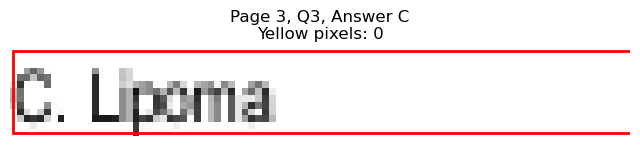

Page 3, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=365.1, y1=265.7
Page 3, Q3, D: Yellow pixels: 319
Page 3, Q3, D: Total non-white pixels: 533
Page 3, Q3, D: Yellow percentage: 59.8%


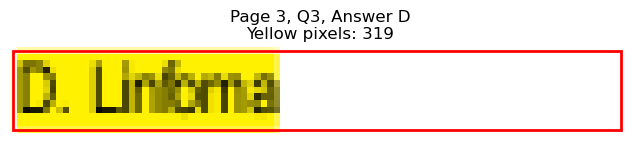

Page 3, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=371.8, y1=277.7
Page 3, Q3, E: Yellow pixels: 40
Page 3, Q3, E: Total non-white pixels: 269
Page 3, Q3, E: Yellow percentage: 14.9%


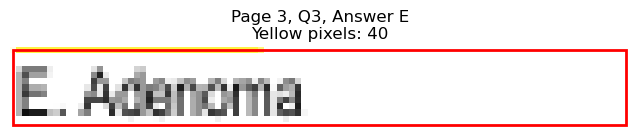


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=338.5, x1=142.0, y1=350.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 317
Page 3, Q4, A: Yellow percentage: 0.0%


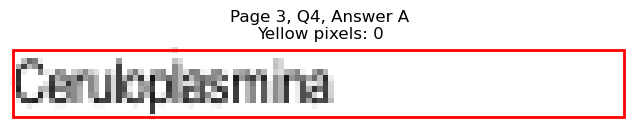

Page 3, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=136.0, y1=362.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 346
Page 3, Q4, B: Yellow percentage: 0.0%


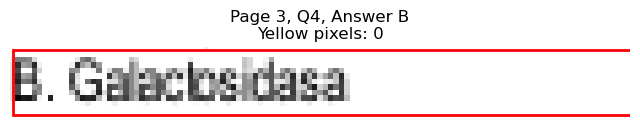

Page 3, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=112.8, y1=374.6
Page 3, Q4, C: Yellow pixels: 342
Page 3, Q4, C: Total non-white pixels: 520
Page 3, Q4, C: Yellow percentage: 65.8%


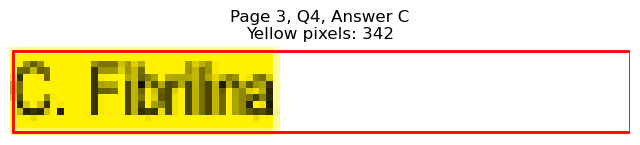

Page 3, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=398.0, y1=350.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 393
Page 3, Q4, D: Yellow percentage: 0.0%


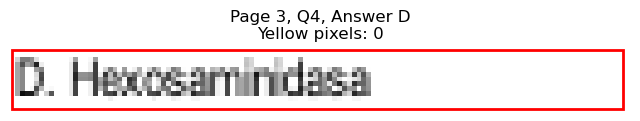

Page 3, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=370.3, y1=362.5
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 239
Page 3, Q4, E: Yellow percentage: 0.0%


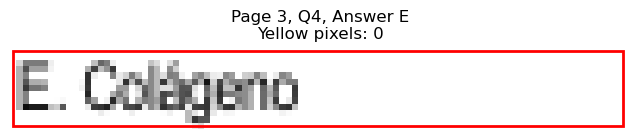


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=122.5, y1=410.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 200
Page 3, Q5, A: Yellow percentage: 0.0%


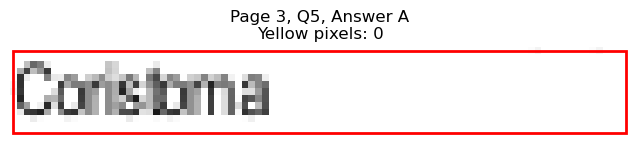

Page 3, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=118.7, y1=422.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 215
Page 3, Q5, B: Yellow percentage: 0.0%


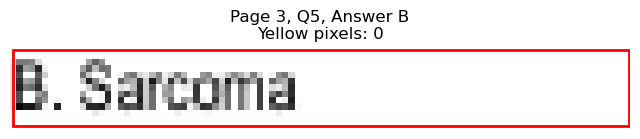

Page 3, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=125.5, y1=434.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 233
Page 3, Q5, C: Yellow percentage: 0.0%


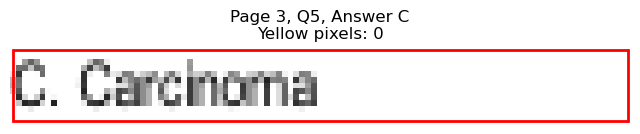

Page 3, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=371.8, y1=410.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 230
Page 3, Q5, D: Yellow percentage: 0.0%


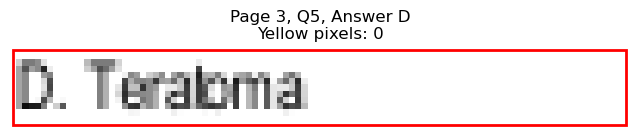

Page 3, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=379.4, y1=422.6
Page 3, Q5, E: Yellow pixels: 426
Page 3, Q5, E: Total non-white pixels: 715
Page 3, Q5, E: Yellow percentage: 59.6%


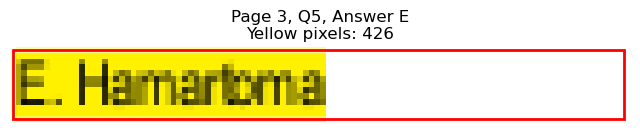


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=145.8, y1=482.6
Page 3, Q6, A: Yellow pixels: 475
Page 3, Q6, A: Total non-white pixels: 808
Page 3, Q6, A: Yellow percentage: 58.8%


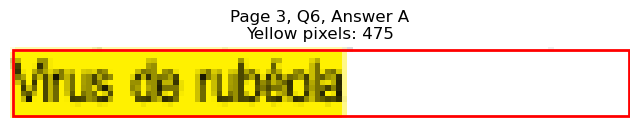

Page 3, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=142.7, y1=495.4
Page 3, Q6, B: Yellow pixels: 60
Page 3, Q6, B: Total non-white pixels: 422
Page 3, Q6, B: Yellow percentage: 14.2%


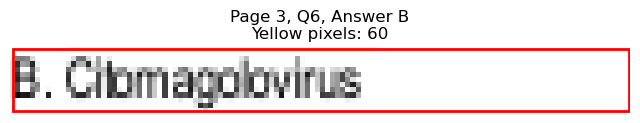

Page 3, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=139.0, y1=507.4
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 317
Page 3, Q6, C: Yellow percentage: 0.0%


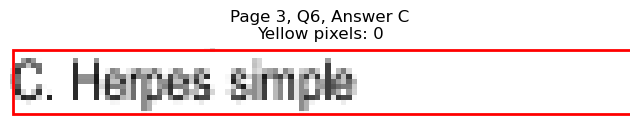

Page 3, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=406.3, y1=482.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 409
Page 3, Q6, D: Yellow percentage: 0.0%


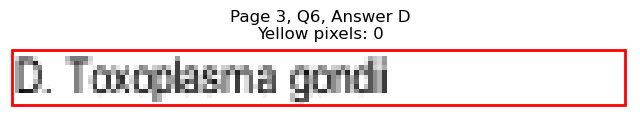

Page 3, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=412.3, y1=495.4
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 440
Page 3, Q6, E: Yellow percentage: 0.0%


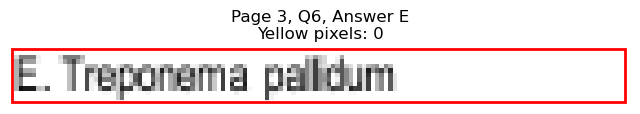


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=531.4, x1=127.7, y1=543.5
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 230
Page 3, Q7, A: Yellow percentage: 0.0%


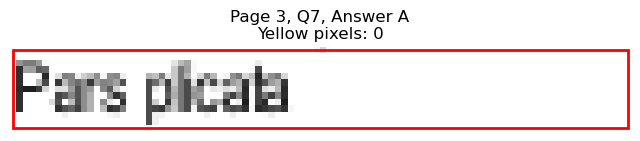

Page 3, Q7 - B: Detected box: x0=71.3, y0=543.4, x1=124.0, y1=555.5
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 251
Page 3, Q7, B: Yellow percentage: 0.0%


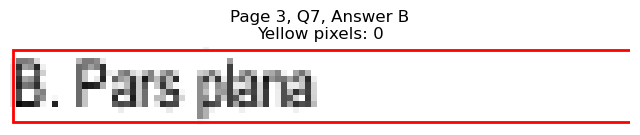

Page 3, Q7 - C: Detected box: x0=71.3, y0=555.4, x1=118.0, y1=567.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 208
Page 3, Q7, C: Yellow percentage: 0.0%


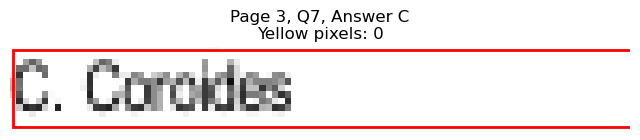

Page 3, Q7 - D: Detected box: x0=322.9, y0=531.4, x1=347.8, y1=543.5
Page 3, Q7, D: Yellow pixels: 219
Page 3, Q7, D: Total non-white pixels: 313
Page 3, Q7, D: Yellow percentage: 70.0%


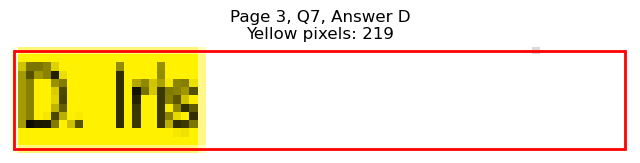

Page 3, Q7 - E: Detected box: x0=322.9, y0=543.4, x1=383.7, y1=555.5
Page 3, Q7, E: Yellow pixels: 22
Page 3, Q7, E: Total non-white pixels: 330
Page 3, Q7, E: Yellow percentage: 6.7%


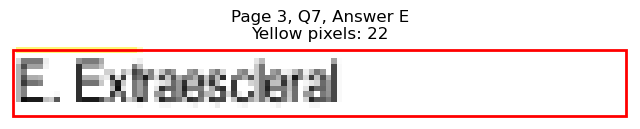


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=136.6, y0=615.5, x1=198.2, y1=627.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 306
Page 3, Q8, A: Yellow percentage: 0.0%


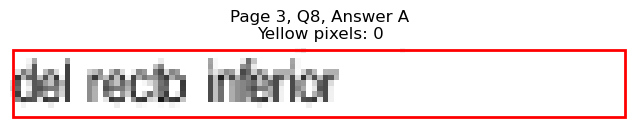

Page 3, Q8 - B: Detected box: x0=132.8, y0=627.5, x1=208.7, y1=639.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 375
Page 3, Q8, B: Yellow percentage: 0.0%


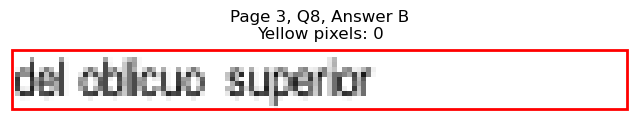

Page 3, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=154.0, y1=651.6
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 631
Page 3, Q8, C: Yellow percentage: 0.0%


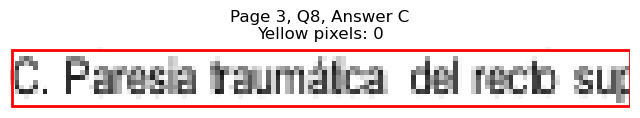

Page 3, Q8 - D: Detected box: x0=387.4, y0=615.5, x1=455.0, y1=627.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 317
Page 3, Q8, D: Yellow percentage: 0.0%


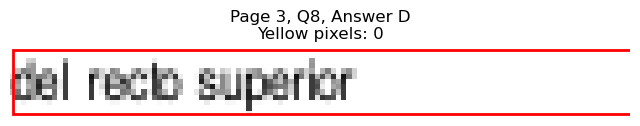

Page 3, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=404.8, y1=639.6
Page 3, Q8, E: Yellow pixels: 1185
Page 3, Q8, E: Total non-white pixels: 1729
Page 3, Q8, E: Yellow percentage: 68.5%


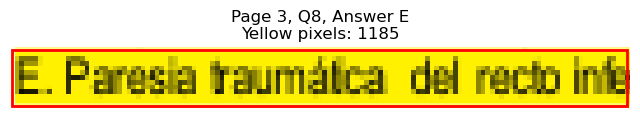


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=676.3, x1=189.2, y1=688.3
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 514
Page 3, Q9, A: Yellow percentage: 0.0%


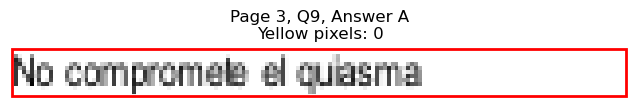

Page 3, Q9 - B: Detected box: x0=167.3, y0=688.3, x1=280.2, y1=700.3
Page 3, Q9, B: Yellow pixels: 891
Page 3, Q9, B: Total non-white pixels: 1480
Page 3, Q9, B: Yellow percentage: 60.2%


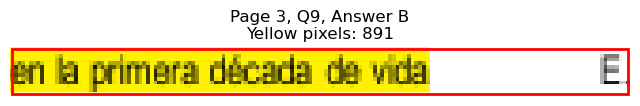

Page 3, Q9 - C: Detected box: x0=148.6, y0=700.3, x1=246.4, y1=712.3
Page 3, Q9, C: Yellow pixels: 1
Page 3, Q9, C: Total non-white pixels: 599
Page 3, Q9, C: Yellow percentage: 0.2%


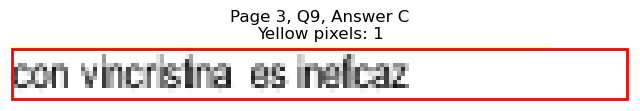

Page 3, Q9 - D: Detected box: x0=322.9, y0=676.3, x1=497.7, y1=688.3
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 844
Page 3, Q9, D: Yellow percentage: 0.0%


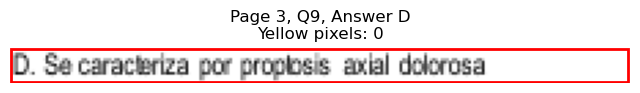

Page 3, Q9 - E: Detected box: x0=322.9, y0=688.3, x1=522.5, y1=700.3
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 951
Page 3, Q9, E: Yellow percentage: 0.0%


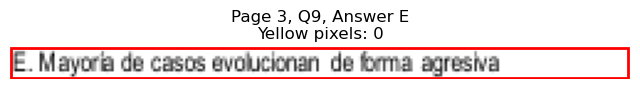


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=82.6, y0=736.4, x1=166.8, y1=748.4
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 422
Page 3, Q10, A: Yellow percentage: 0.0%


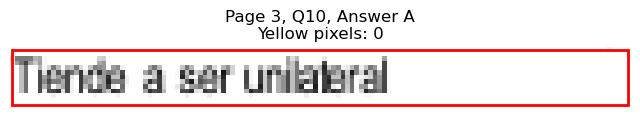

Page 3, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=247.7, y1=760.4
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 1022
Page 3, Q10, B: Yellow percentage: 0.0%


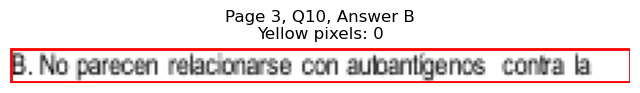

Page 3, Q10 - C: Detected box: x0=71.3, y0=772.4, x1=274.7, y1=784.4
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 938
Page 3, Q10, C: Yellow percentage: 0.0%


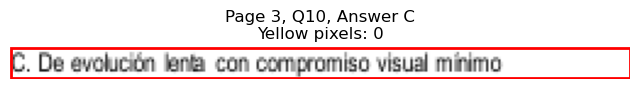

Page 3, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=512.3, y1=748.4
Page 3, Q10, D: Yellow pixels: 1683
Page 3, Q10, D: Total non-white pixels: 2444
Page 3, Q10, D: Yellow percentage: 68.9%


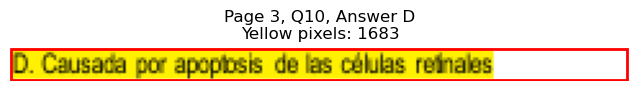

Page 3, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=541.2, y1=760.4
Page 3, Q10, E: Yellow pixels: 187
Page 3, Q10, E: Total non-white pixels: 1210
Page 3, Q10, E: Yellow percentage: 15.5%


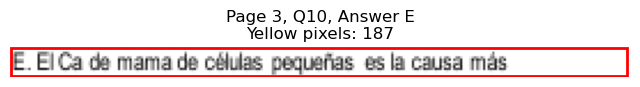


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=237.2, y1=108.8
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 752
Page 4, Q1, A: Yellow percentage: 0.0%


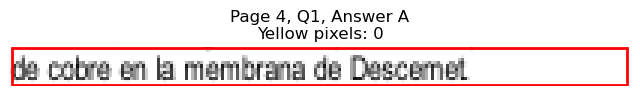

Page 4, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=156.3, y1=121.6
Page 4, Q1, B: Yellow pixels: 749
Page 4, Q1, B: Total non-white pixels: 1079
Page 4, Q1, B: Yellow percentage: 69.4%


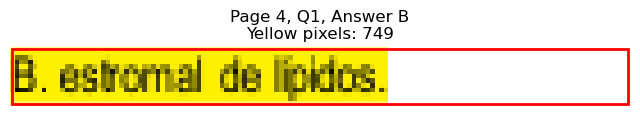

Page 4, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=232.7, y1=133.6
Page 4, Q1, C: Yellow pixels: 83
Page 4, Q1, C: Total non-white pixels: 814
Page 4, Q1, C: Yellow percentage: 10.2%


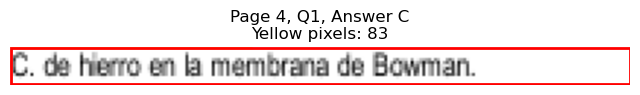

Page 4, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=407.0, y1=108.8
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 391
Page 4, Q1, D: Yellow percentage: 0.0%


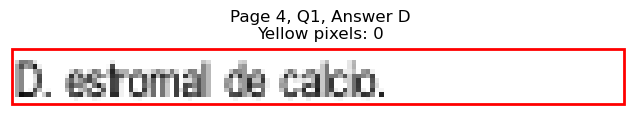

Page 4, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=401.9, y1=121.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 372
Page 4, Q1, E: Yellow percentage: 0.0%


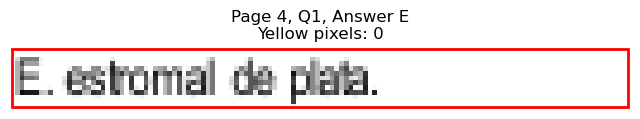


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=147.2, y1=169.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 329
Page 4, Q2, A: Yellow percentage: 0.0%


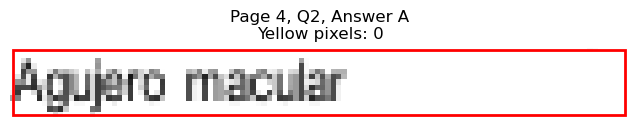

Page 4, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=145.7, y1=181.6
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 560
Page 4, Q2, B: Yellow percentage: 0.0%


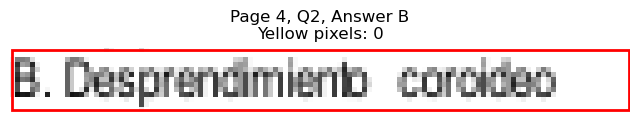

Page 4, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=174.4, y1=193.6
Page 4, Q2, C: Yellow pixels: 810
Page 4, Q2, C: Total non-white pixels: 1313
Page 4, Q2, C: Yellow percentage: 61.7%


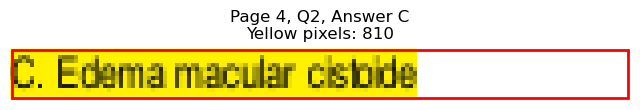

Page 4, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=378.5, y1=169.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 272
Page 4, Q2, D: Yellow percentage: 0.0%


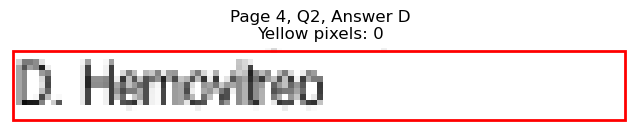

Page 4, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=451.2, y1=181.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 633
Page 4, Q2, E: Yellow percentage: 0.0%


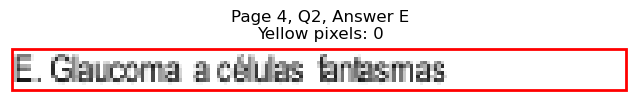


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=130.0, y1=229.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 225
Page 4, Q3, A: Yellow percentage: 0.0%


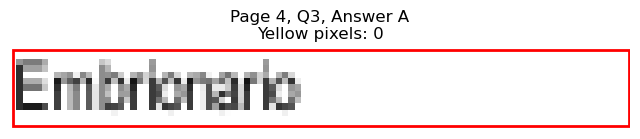

Page 4, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=114.3, y1=241.7
Page 4, Q3, B: Yellow pixels: 337
Page 4, Q3, B: Total non-white pixels: 533
Page 4, Q3, B: Yellow percentage: 63.2%


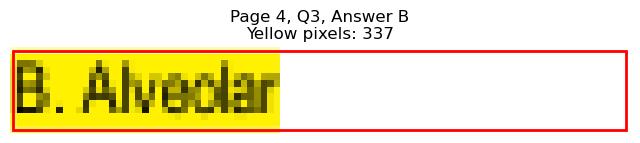

Page 4, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=116.5, y1=253.7
Page 4, Q3, C: Yellow pixels: 41
Page 4, Q3, C: Total non-white pixels: 248
Page 4, Q3, C: Yellow percentage: 16.5%


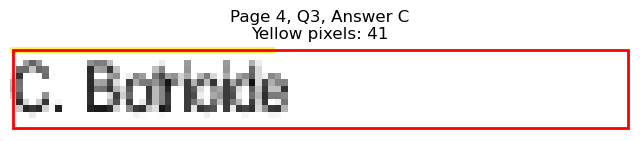

Page 4, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=374.0, y1=229.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 246
Page 4, Q3, D: Yellow percentage: 0.0%


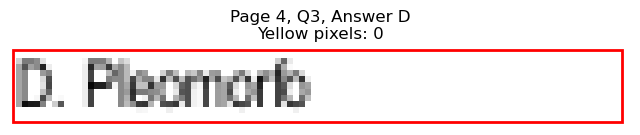

Page 4, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=374.7, y1=241.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 244
Page 4, Q3, E: Yellow percentage: 0.0%


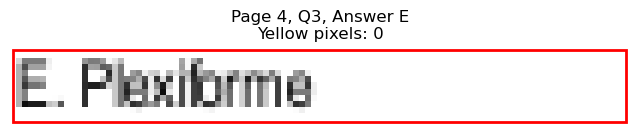


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=277.7, x1=127.0, y1=289.7
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 225
Page 4, Q4, A: Yellow percentage: 0.0%


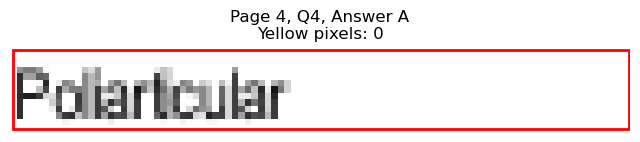

Page 4, Q4 - B: Detected box: x0=71.3, y0=289.7, x1=157.7, y1=301.8
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 433
Page 4, Q4, B: Yellow percentage: 0.0%


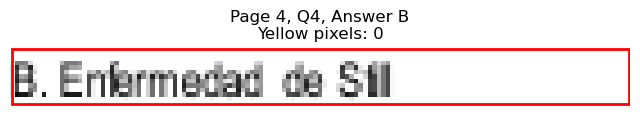

Page 4, Q4 - C: Detected box: x0=71.3, y0=302.5, x1=134.6, y1=314.5
Page 4, Q4, C: Yellow pixels: 545
Page 4, Q4, C: Total non-white pixels: 806
Page 4, Q4, C: Yellow percentage: 67.6%


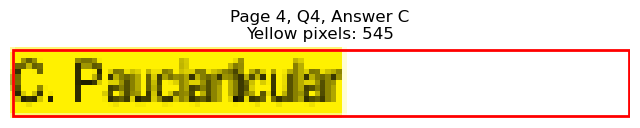

Page 4, Q4 - D: Detected box: x0=322.9, y0=277.7, x1=365.0, y1=289.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 205
Page 4, Q4, D: Yellow percentage: 0.0%


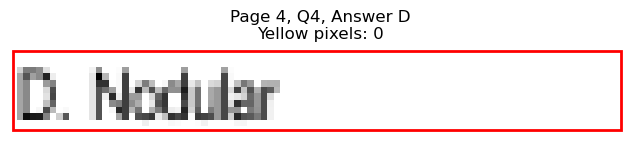

Page 4, Q4 - E: Detected box: x0=322.9, y0=289.7, x1=389.8, y1=301.8
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 314
Page 4, Q4, E: Yellow percentage: 0.0%


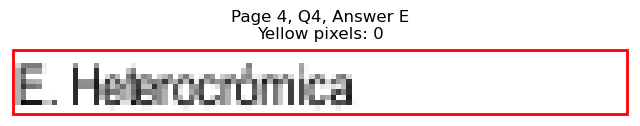


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=168.3, y1=362.5
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 450
Page 4, Q5, A: Yellow percentage: 0.0%


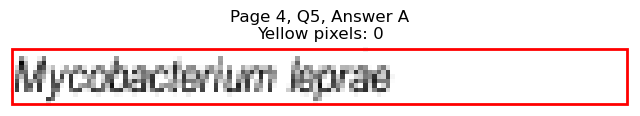

Page 4, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=156.3, y1=374.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 424
Page 4, Q5, B: Yellow percentage: 0.0%


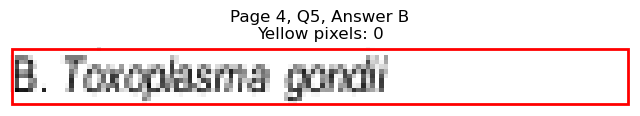

Page 4, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=150.3, y1=386.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 385
Page 4, Q5, C: Yellow percentage: 0.0%


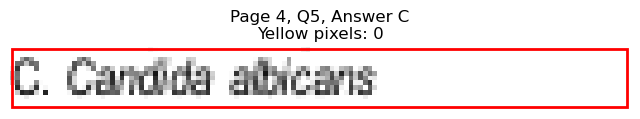

Page 4, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=428.9, y1=362.5
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 554
Page 4, Q5, D: Yellow percentage: 0.0%


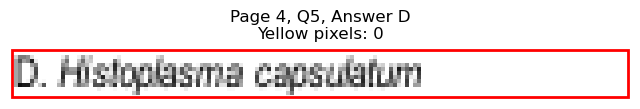

Page 4, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=372.6, y1=374.6
Page 4, Q5, E: Yellow pixels: 734
Page 4, Q5, E: Total non-white pixels: 1118
Page 4, Q5, E: Yellow percentage: 65.7%


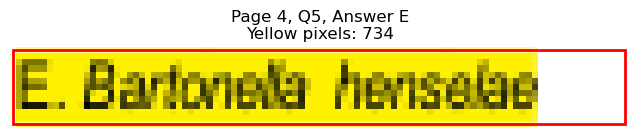


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=121.0, y1=422.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 210
Page 4, Q6, A: Yellow percentage: 0.0%


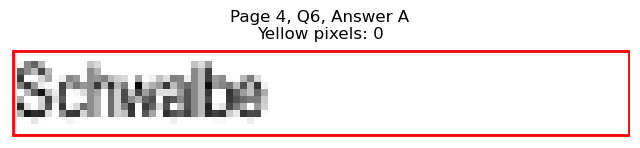

Page 4, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=118.7, y1=434.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 224
Page 4, Q6, B: Yellow percentage: 0.0%


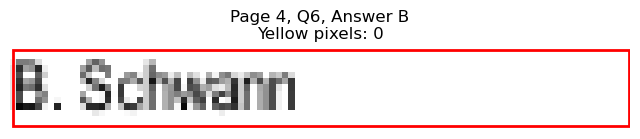

Page 4, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=120.9, y1=446.6
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 218
Page 4, Q6, C: Yellow percentage: 0.0%


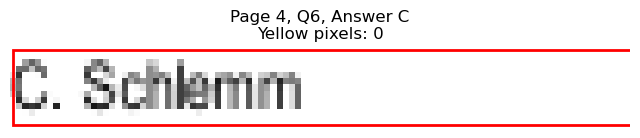

Page 4, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=372.5, y1=422.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 242
Page 4, Q6, D: Yellow percentage: 0.0%


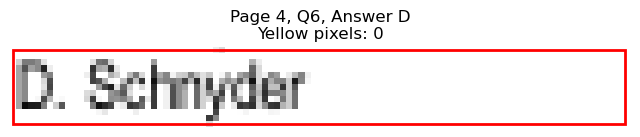

Page 4, Q6 - E: Detected box: x0=322.9, y0=422.5, x1=361.3, y1=434.6
Page 4, Q6, E: Yellow pixels: 275
Page 4, Q6, E: Total non-white pixels: 481
Page 4, Q6, E: Yellow percentage: 57.2%


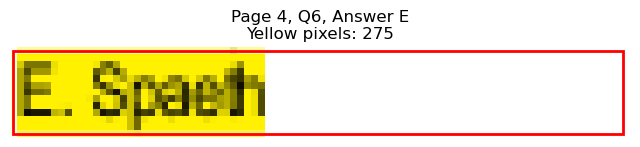


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=155.5, y1=507.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 374
Page 4, Q7, A: Yellow percentage: 0.0%


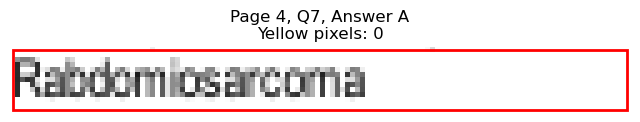

Page 4, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=139.7, y1=519.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 348
Page 4, Q7, B: Yellow percentage: 0.0%


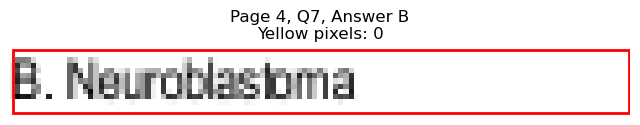

Page 4, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=112.0, y1=531.4
Page 4, Q7, C: Yellow pixels: 649
Page 4, Q7, C: Total non-white pixels: 949
Page 4, Q7, C: Yellow percentage: 68.4%


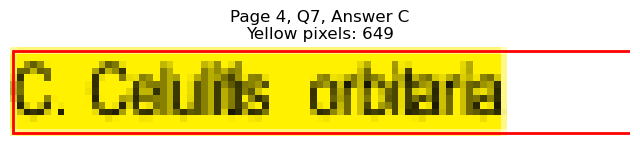

Page 4, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=425.0, y1=507.4
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 489
Page 4, Q7, D: Yellow percentage: 0.0%


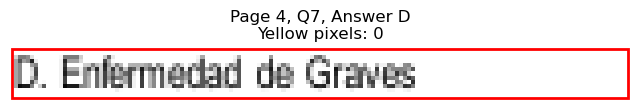

Page 4, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=379.3, y1=519.4
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 280
Page 4, Q7, E: Yellow percentage: 0.0%


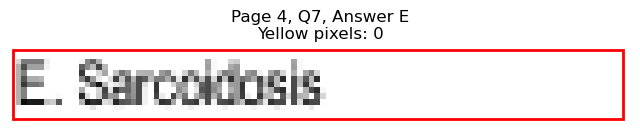


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=172.1, y1=591.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 456
Page 4, Q8, A: Yellow percentage: 0.0%


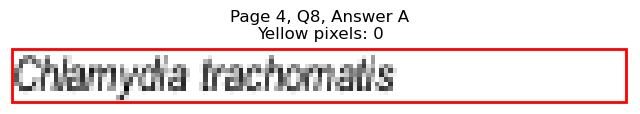

Page 4, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=183.4, y1=603.5
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 554
Page 4, Q8, B: Yellow percentage: 0.0%


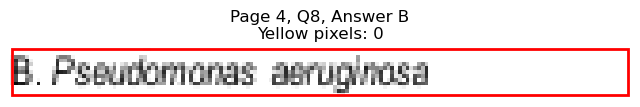

Page 4, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=170.6, y1=615.5
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 477
Page 4, Q8, C: Yellow percentage: 0.0%


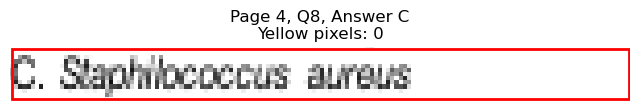

Page 4, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=439.4, y1=591.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 579
Page 4, Q8, D: Yellow percentage: 0.0%


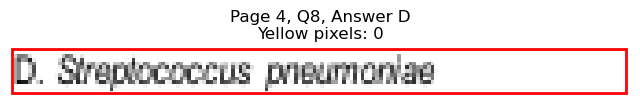

Page 4, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=419.9, y1=603.5
Page 4, Q8, E: Yellow pixels: 837
Page 4, Q8, E: Total non-white pixels: 1248
Page 4, Q8, E: Yellow percentage: 67.1%


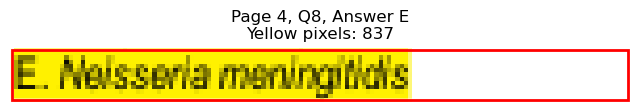


Page 4, Q8 - Selected Answer: E (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=147.8, y0=639.5, x1=222.3, y1=651.6
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 635
Page 4, Q9, A: Yellow percentage: 0.0%


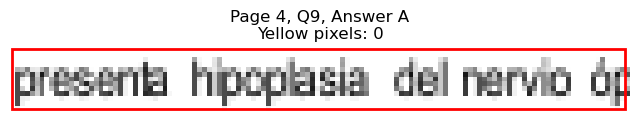

Page 4, Q9 - B: Detected box: x0=165.1, y0=651.5, x1=270.3, y1=663.6
Page 4, Q9, B: Yellow pixels: 1053
Page 4, Q9, B: Total non-white pixels: 1547
Page 4, Q9, B: Yellow percentage: 68.1%


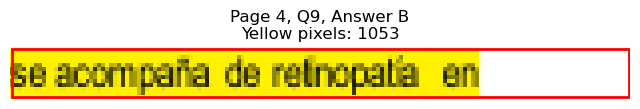

Page 4, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=282.1, y1=688.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 1035
Page 4, Q9, C: Yellow percentage: 0.0%


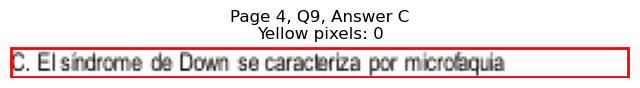

Page 4, Q9 - D: Detected box: x0=71.3, y0=688.3, x1=266.4, y1=700.3
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 923
Page 4, Q9, D: Yellow percentage: 0.0%


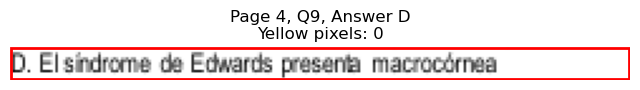

Page 4, Q9 - E: Detected box: x0=458.6, y0=639.5, x1=532.3, y1=651.6
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 394
Page 4, Q9, E: Yellow percentage: 0.0%


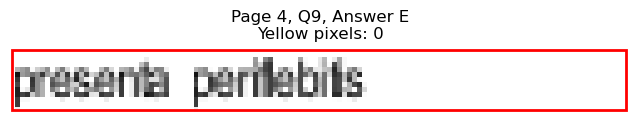


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=82.6, y0=724.3, x1=249.2, y1=736.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 788
Page 4, Q10, A: Yellow percentage: 0.0%


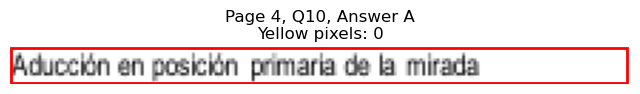

Page 4, Q10 - B: Detected box: x0=123.1, y0=736.4, x1=188.5, y1=748.4
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 328
Page 4, Q10, B: Yellow percentage: 0.0%


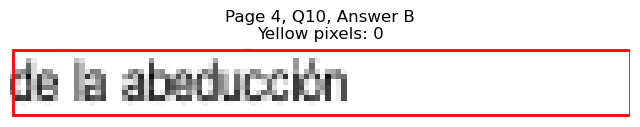

Page 4, Q10 - C: Detected box: x0=71.3, y0=748.4, x1=225.4, y1=760.4
Page 4, Q10, C: Yellow pixels: 1391
Page 4, Q10, C: Total non-white pixels: 1989
Page 4, Q10, C: Yellow percentage: 69.9%


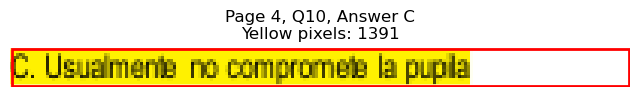

Page 4, Q10 - D: Detected box: x0=322.9, y0=724.3, x1=451.3, y1=736.4
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 625
Page 4, Q10, D: Yellow percentage: 0.0%


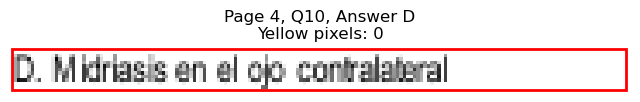

Page 4, Q10 - E: Detected box: x0=322.9, y0=736.4, x1=449.8, y1=748.4
Page 4, Q10, E: Yellow pixels: 0
Page 4, Q10, E: Total non-white pixels: 606
Page 4, Q10, E: Yellow percentage: 0.0%


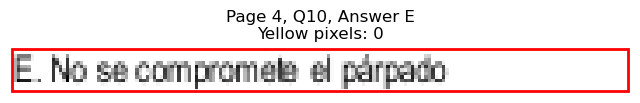


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=114.8, y0=109.5, x1=145.7, y1=121.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 170
Page 5, Q1, A: Yellow percentage: 0.0%


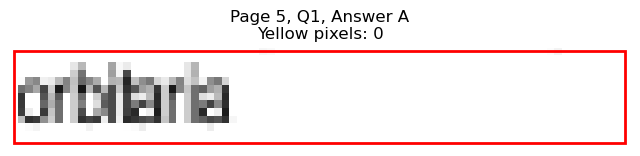

Page 5, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=139.7, y1=133.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 357
Page 5, Q1, B: Yellow percentage: 0.0%


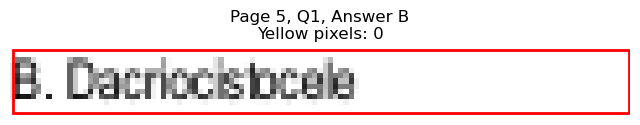

Page 5, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=168.3, y1=145.6
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 466
Page 5, Q1, C: Yellow percentage: 0.0%


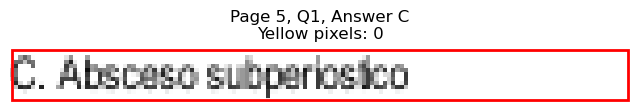

Page 5, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=373.3, y1=121.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 236
Page 5, Q1, D: Yellow percentage: 0.0%


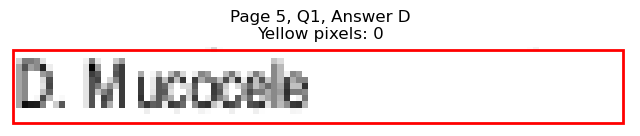

Page 5, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=380.9, y1=133.6
Page 5, Q1, E: Yellow pixels: 479
Page 5, Q1, E: Total non-white pixels: 741
Page 5, Q1, E: Yellow percentage: 64.6%


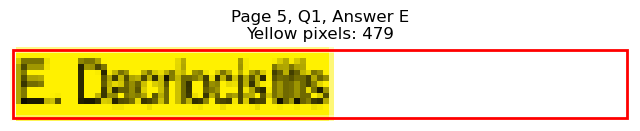


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=159.3, y1=181.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 398
Page 5, Q2, A: Yellow percentage: 0.0%


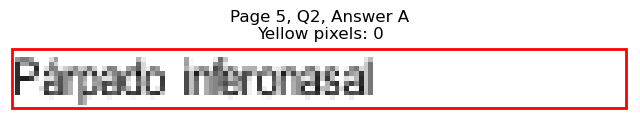

Page 5, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=130.8, y1=193.6
Page 5, Q2, B: Yellow pixels: 462
Page 5, Q2, B: Total non-white pixels: 754
Page 5, Q2, B: Yellow percentage: 61.3%


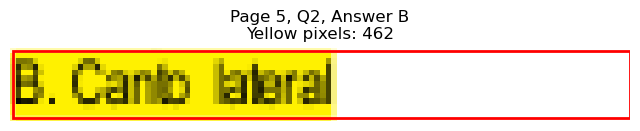

Page 5, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=149.5, y1=205.6
Page 5, Q2, C: Yellow pixels: 57
Page 5, Q2, C: Total non-white pixels: 425
Page 5, Q2, C: Yellow percentage: 13.4%


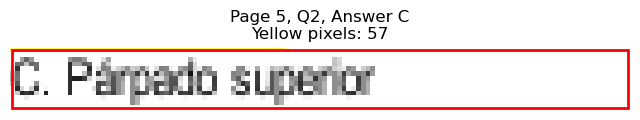

Page 5, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=386.0, y1=181.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 297
Page 5, Q2, D: Yellow percentage: 0.0%


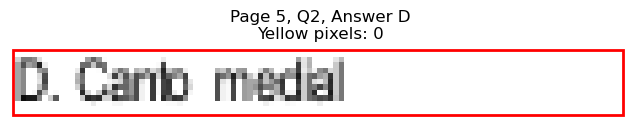

Page 5, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=395.0, y1=193.6
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 347
Page 5, Q2, E: Yellow percentage: 0.0%


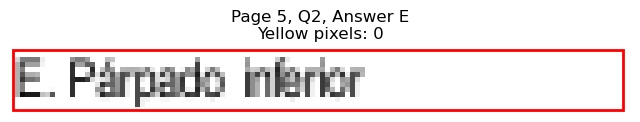


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=71.3, y0=229.6, x1=79.7, y1=241.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 55
Page 5, Q3, A: Yellow percentage: 0.0%


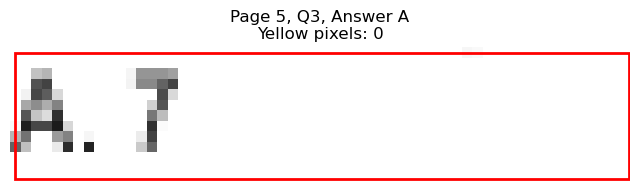

Page 5, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=88.7, y1=253.7
Page 5, Q3, B: Yellow pixels: 132
Page 5, Q3, B: Total non-white pixels: 208
Page 5, Q3, B: Yellow percentage: 63.5%


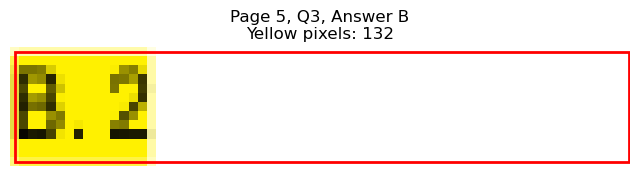

Page 5, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=89.5, y1=265.7
Page 5, Q3, C: Yellow pixels: 15
Page 5, Q3, C: Total non-white pixels: 76
Page 5, Q3, C: Yellow percentage: 19.7%


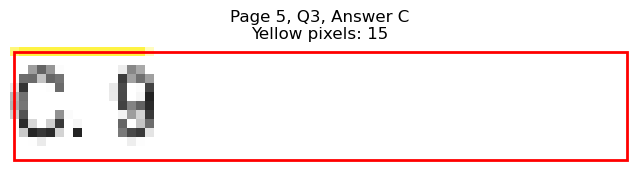

Page 5, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=345.5, y1=241.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 87
Page 5, Q3, D: Yellow percentage: 0.0%


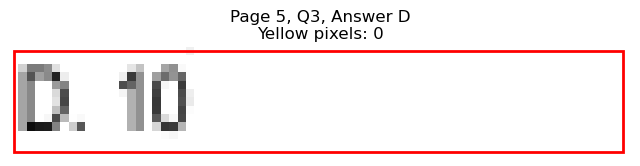

Page 5, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=344.8, y1=253.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 84
Page 5, Q3, E: Yellow percentage: 0.0%


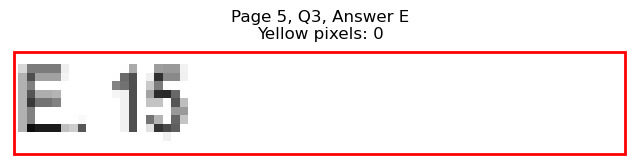


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=190.7, y1=301.8
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 517
Page 5, Q4, A: Yellow percentage: 0.0%


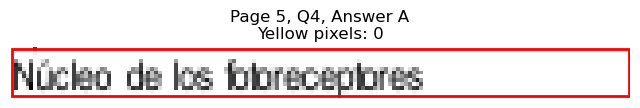

Page 5, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=242.7, y1=314.5
Page 5, Q4, B: Yellow pixels: 1519
Page 5, Q4, B: Total non-white pixels: 2210
Page 5, Q4, B: Yellow percentage: 68.7%


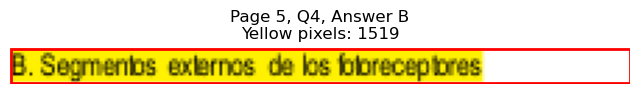

Page 5, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=215.5, y1=326.5
Page 5, Q4, C: Yellow pixels: 168
Page 5, Q4, C: Total non-white pixels: 917
Page 5, Q4, C: Yellow percentage: 18.3%


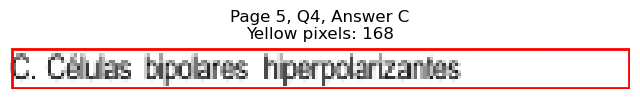

Page 5, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=408.5, y1=301.8
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 580
Page 5, Q4, D: Yellow percentage: 0.0%


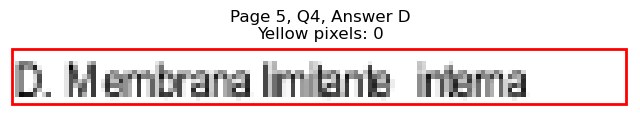

Page 5, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=413.8, y1=314.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 469
Page 5, Q4, E: Yellow percentage: 0.0%


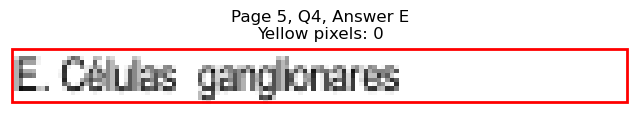


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=136.7, y1=362.5
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 299
Page 5, Q5, A: Yellow percentage: 0.0%


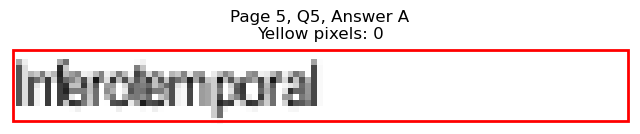

Page 5, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=130.7, y1=374.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 307
Page 5, Q5, B: Yellow percentage: 0.0%


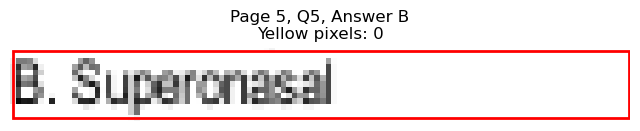

Page 5, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=124.8, y1=386.6
Page 5, Q5, C: Yellow pixels: 469
Page 5, Q5, C: Total non-white pixels: 676
Page 5, Q5, C: Yellow percentage: 69.4%


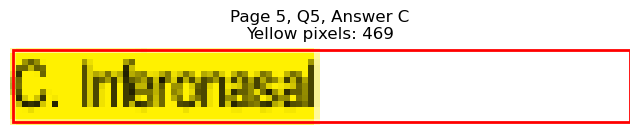

Page 5, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=395.0, y1=362.5
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 370
Page 5, Q5, D: Yellow percentage: 0.0%


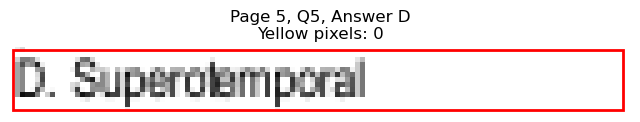

Page 5, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=410.8, y1=374.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 400
Page 5, Q5, E: Yellow percentage: 0.0%


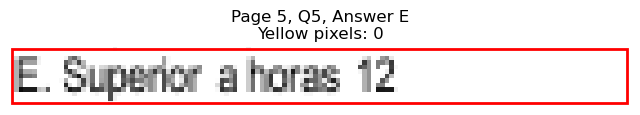


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=176.6, y1=422.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 488
Page 5, Q6, A: Yellow percentage: 0.0%


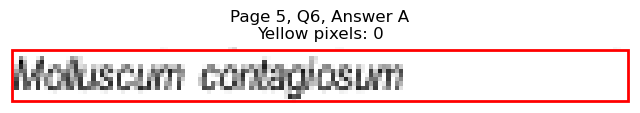

Page 5, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=193.9, y1=434.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 640
Page 5, Q6, B: Yellow percentage: 0.0%


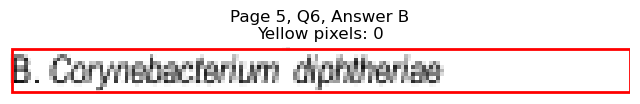

Page 5, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=139.8, y1=446.6
Page 5, Q6, C: Yellow pixels: 562
Page 5, Q6, C: Total non-white pixels: 873
Page 5, Q6, C: Yellow percentage: 64.4%


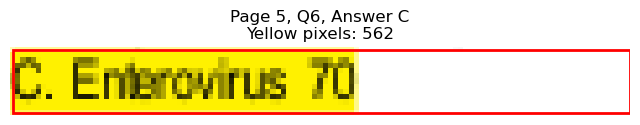

Page 5, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=392.1, y1=422.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 336
Page 5, Q6, D: Yellow percentage: 0.0%


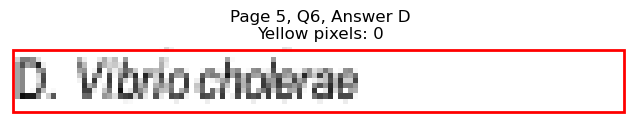

Page 5, Q6 - E: Detected box: x0=322.9, y0=422.5, x1=410.8, y1=434.6
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 412
Page 5, Q6, E: Yellow percentage: 0.0%


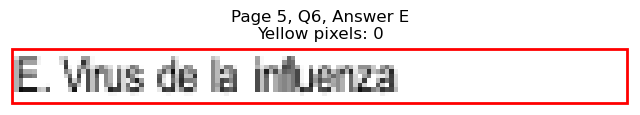


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=483.4, x1=146.5, y1=495.4
Page 5, Q7, A: Yellow pixels: 1002
Page 5, Q7, A: Total non-white pixels: 1495
Page 5, Q7, A: Yellow percentage: 67.0%


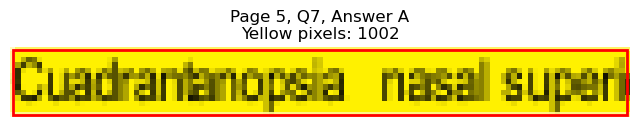

Page 5, Q7 - B: Detected box: x0=71.3, y0=495.4, x1=169.7, y1=507.4
Page 5, Q7, B: Yellow pixels: 120
Page 5, Q7, B: Total non-white pixels: 776
Page 5, Q7, B: Yellow percentage: 15.5%


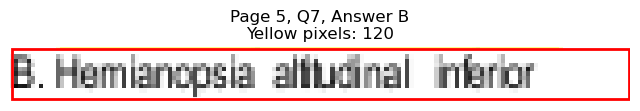

Page 5, Q7 - C: Detected box: x0=71.3, y0=507.4, x1=146.5, y1=519.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 618
Page 5, Q7, C: Yellow percentage: 0.0%


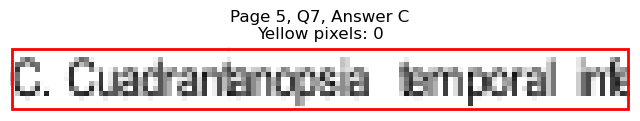

Page 5, Q7 - D: Detected box: x0=322.9, y0=483.4, x1=420.5, y1=495.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 507
Page 5, Q7, D: Yellow percentage: 0.0%


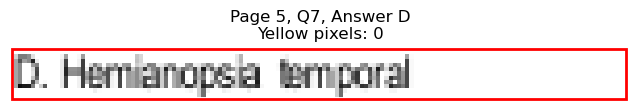

Page 5, Q7 - E: Detected box: x0=322.9, y0=495.4, x1=398.0, y1=507.4
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 643
Page 5, Q7, E: Yellow percentage: 0.0%


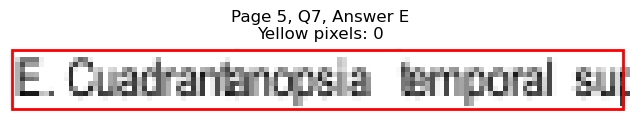


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=128.5, y1=579.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 246
Page 5, Q8, A: Yellow percentage: 0.0%


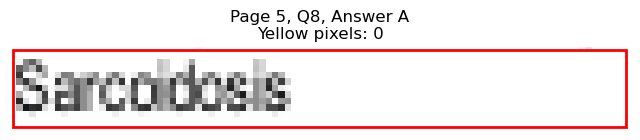

Page 5, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=178.0, y1=591.5
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 514
Page 5, Q8, B: Yellow percentage: 0.0%


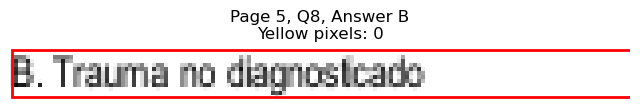

Page 5, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=114.2, y1=603.5
Page 5, Q8, C: Yellow pixels: 723
Page 5, Q8, C: Total non-white pixels: 1053
Page 5, Q8, C: Yellow percentage: 68.7%


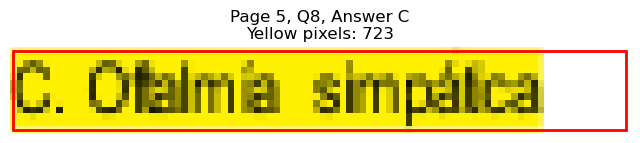

Page 5, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=402.5, y1=579.5
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 536
Page 5, Q8, D: Yellow percentage: 0.0%


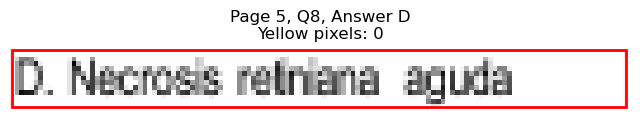

Page 5, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=419.9, y1=591.5
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 511
Page 5, Q8, E: Yellow percentage: 0.0%


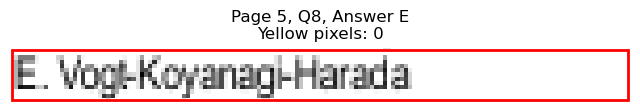


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=121.6, y0=639.5, x1=166.0, y1=651.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 234
Page 5, Q9, A: Yellow percentage: 0.0%


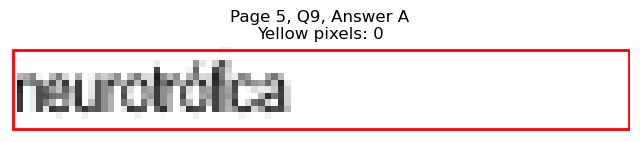

Page 5, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=137.4, y1=663.6
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 335
Page 5, Q9, B: Yellow percentage: 0.0%


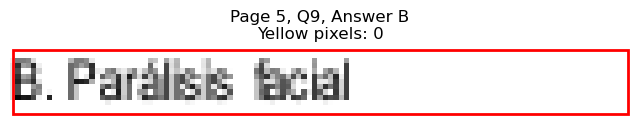

Page 5, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=181.7, y1=675.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 514
Page 5, Q9, C: Yellow percentage: 0.0%


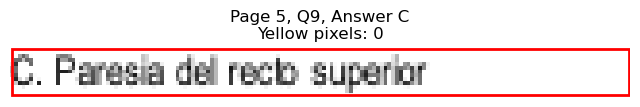

Page 5, Q9 - D: Detected box: x0=373.1, y0=639.5, x1=429.7, y1=651.6
Page 5, Q9, D: Yellow pixels: 476
Page 5, Q9, D: Total non-white pixels: 715
Page 5, Q9, D: Yellow percentage: 66.6%


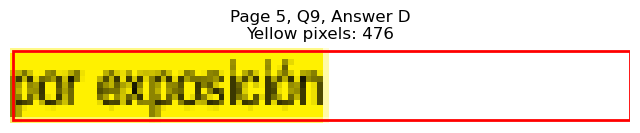

Page 5, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=376.3, y1=663.6
Page 5, Q9, E: Yellow pixels: 104
Page 5, Q9, E: Total non-white pixels: 351
Page 5, Q9, E: Yellow percentage: 29.6%


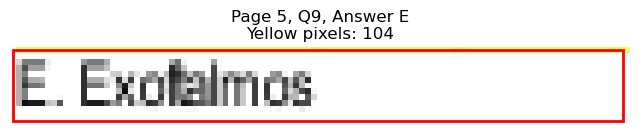


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=82.6, y0=712.3, x1=111.2, y1=724.4
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 140
Page 5, Q10, A: Yellow percentage: 0.0%


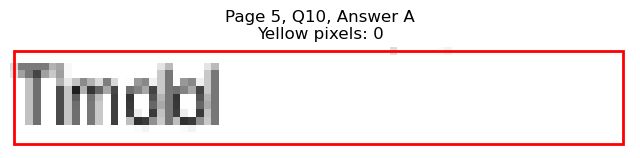

Page 5, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=124.7, y1=736.4
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 267
Page 5, Q10, B: Yellow percentage: 0.0%


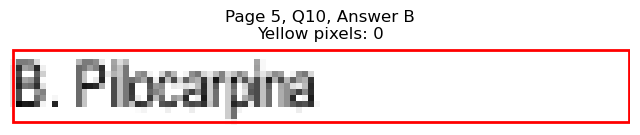

Page 5, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=111.2, y1=748.4
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 177
Page 5, Q10, C: Yellow percentage: 0.0%


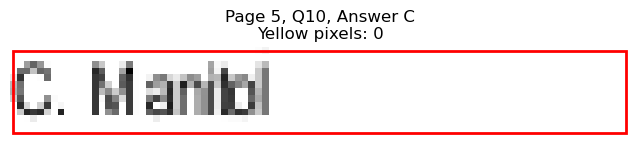

Page 5, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=366.6, y1=724.4
Page 5, Q10, D: Yellow pixels: 317
Page 5, Q10, D: Total non-white pixels: 559
Page 5, Q10, D: Yellow percentage: 56.7%


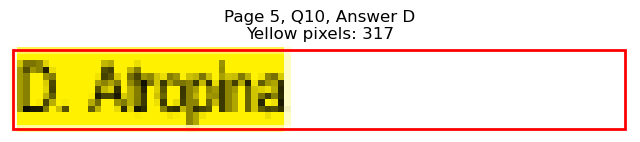

Page 5, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=389.8, y1=736.4
Page 5, Q10, E: Yellow pixels: 1
Page 5, Q10, E: Total non-white pixels: 376
Page 5, Q10, E: Yellow percentage: 0.3%


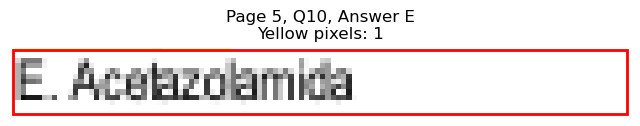


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=94.0, y1=108.8
Page 6, Q1, A: Yellow pixels: 79
Page 6, Q1, A: Total non-white pixels: 136
Page 6, Q1, A: Yellow percentage: 58.1%


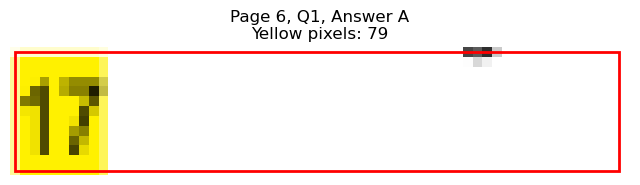

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=93.2, y1=121.6
Page 6, Q1, B: Yellow pixels: 8
Page 6, Q1, B: Total non-white pixels: 105
Page 6, Q1, B: Yellow percentage: 7.6%


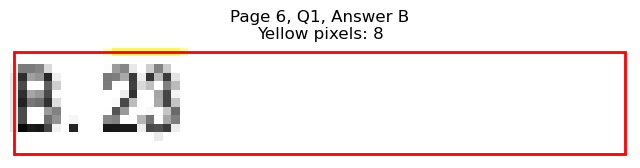

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=94.0, y1=133.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 67
Page 6, Q1, C: Yellow percentage: 0.0%


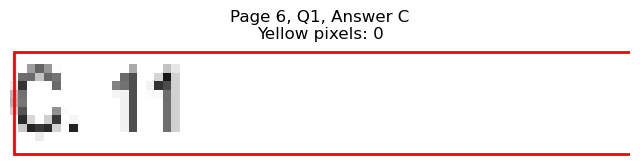

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=345.5, y1=108.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 94
Page 6, Q1, D: Yellow percentage: 0.0%


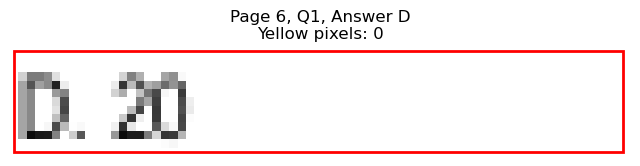

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=344.8, y1=121.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 80
Page 6, Q1, E: Yellow percentage: 0.0%


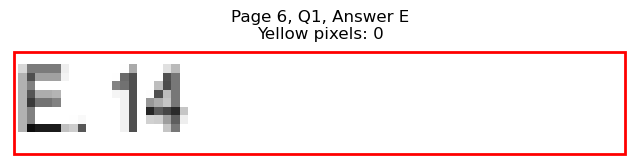


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=165.3, y1=169.6
Page 6, Q2, A: Yellow pixels: 624
Page 6, Q2, A: Total non-white pixels: 1055
Page 6, Q2, A: Yellow percentage: 59.1%


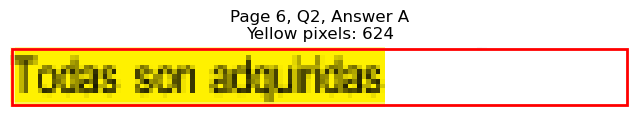

Page 6, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=160.7, y1=181.6
Page 6, Q2, B: Yellow pixels: 80
Page 6, Q2, B: Total non-white pixels: 767
Page 6, Q2, B: Yellow percentage: 10.4%


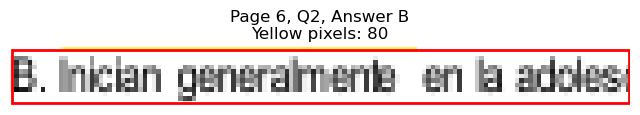

Page 6, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=213.2, y1=193.6
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 639
Page 6, Q2, C: Yellow percentage: 0.0%


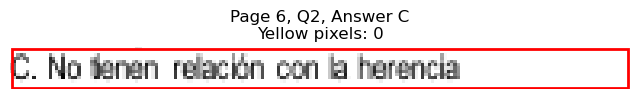

Page 6, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=500.7, y1=169.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 847
Page 6, Q2, D: Yellow percentage: 0.0%


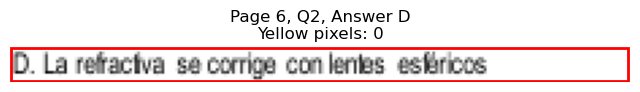

Page 6, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=428.0, y1=193.6
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 494
Page 6, Q2, E: Yellow percentage: 0.0%


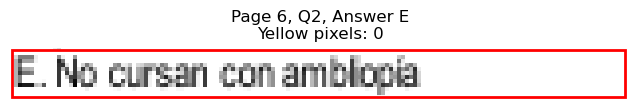


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=170.6, y1=229.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 459
Page 6, Q3, A: Yellow percentage: 0.0%


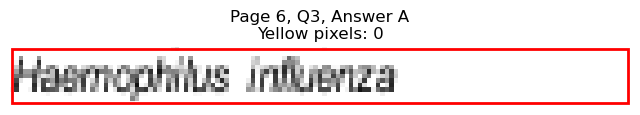

Page 6, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=171.4, y1=241.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 510
Page 6, Q3, B: Yellow percentage: 0.0%


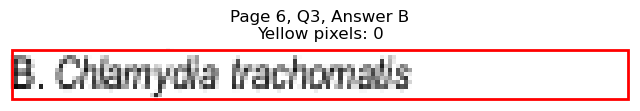

Page 6, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=169.8, y1=253.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 495
Page 6, Q3, C: Yellow percentage: 0.0%


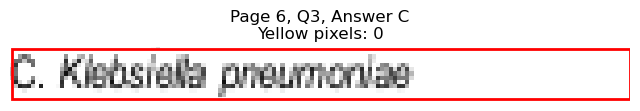

Page 6, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=423.7, y1=229.7
Page 6, Q3, D: Yellow pixels: 791
Page 6, Q3, D: Total non-white pixels: 1300
Page 6, Q3, D: Yellow percentage: 60.8%


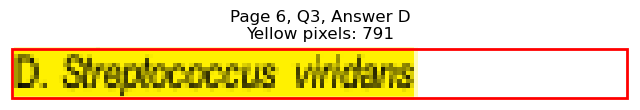

Page 6, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=420.7, y1=241.7
Page 6, Q3, E: Yellow pixels: 98
Page 6, Q3, E: Total non-white pixels: 591
Page 6, Q3, E: Yellow percentage: 16.6%


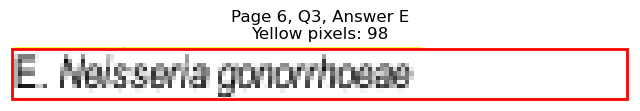


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=277.7, x1=118.7, y1=289.7
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 205
Page 6, Q4, A: Yellow percentage: 0.0%


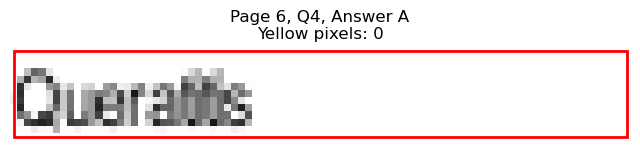

Page 6, Q4 - B: Detected box: x0=71.3, y0=289.7, x1=135.3, y1=301.8
Page 6, Q4, B: Yellow pixels: 473
Page 6, Q4, B: Total non-white pixels: 806
Page 6, Q4, B: Yellow percentage: 58.7%


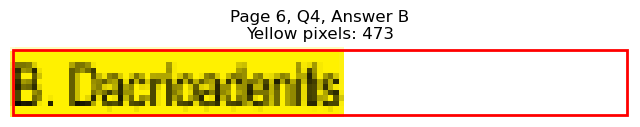

Page 6, Q4 - C: Detected box: x0=71.3, y0=302.5, x1=115.0, y1=314.5
Page 6, Q4, C: Yellow pixels: 61
Page 6, Q4, C: Total non-white pixels: 268
Page 6, Q4, C: Yellow percentage: 22.8%


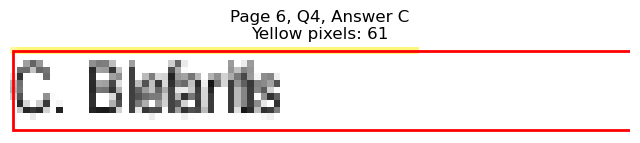

Page 6, Q4 - D: Detected box: x0=322.9, y0=277.7, x1=363.5, y1=289.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 217
Page 6, Q4, D: Yellow percentage: 0.0%


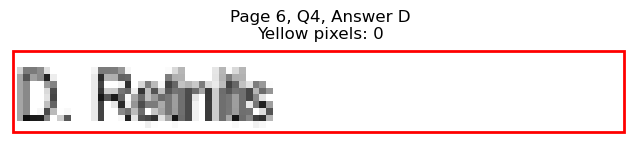

Page 6, Q4 - E: Detected box: x0=322.9, y0=289.7, x1=360.5, y1=301.8
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 191
Page 6, Q4, E: Yellow percentage: 0.0%


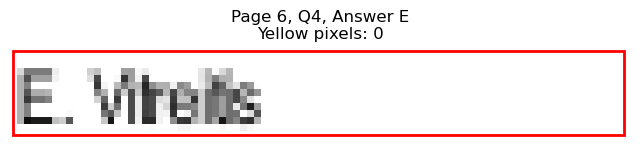


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=130.7, y1=374.6
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 472
Page 6, Q5, A: Yellow percentage: 0.0%


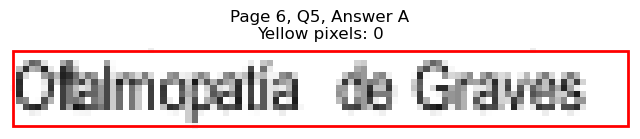

Page 6, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=111.2, y1=386.6
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 408
Page 6, Q5, B: Yellow percentage: 0.0%


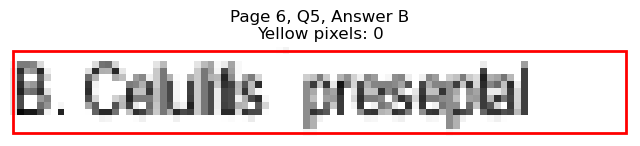

Page 6, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=183.4, y1=398.6
Page 6, Q5, C: Yellow pixels: 882
Page 6, Q5, C: Total non-white pixels: 1430
Page 6, Q5, C: Yellow percentage: 61.7%


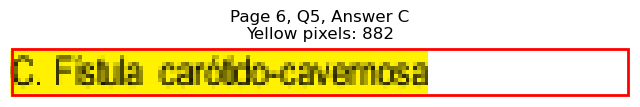

Page 6, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=387.5, y1=374.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 338
Page 6, Q5, D: Yellow percentage: 0.0%


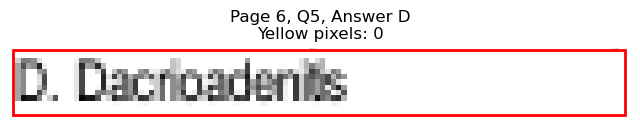

Page 6, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=454.3, y1=386.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 656
Page 6, Q5, E: Yellow percentage: 0.0%


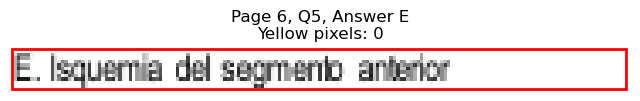


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=71.3, y0=422.5, x1=79.7, y1=434.6
Page 6, Q6, A: Yellow pixels: 26
Page 6, Q6, A: Total non-white pixels: 114
Page 6, Q6, A: Yellow percentage: 22.8%


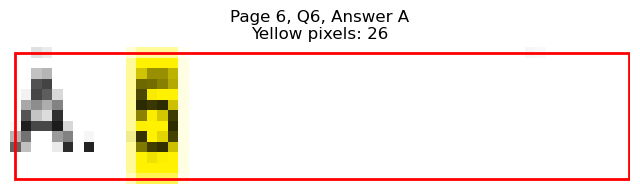

Page 6, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=88.7, y1=446.6
Page 6, Q6, B: Yellow pixels: 4
Page 6, Q6, B: Total non-white pixels: 60
Page 6, Q6, B: Yellow percentage: 6.7%


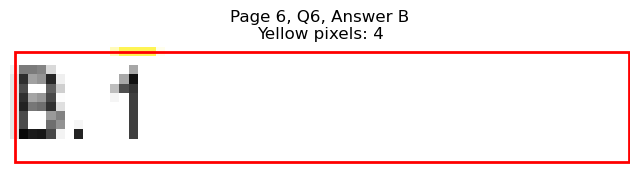

Page 6, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=89.5, y1=458.6
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 57
Page 6, Q6, C: Yellow percentage: 0.0%


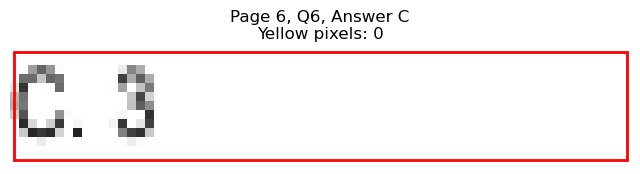

Page 6, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=341.0, y1=434.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 63
Page 6, Q6, D: Yellow percentage: 0.0%


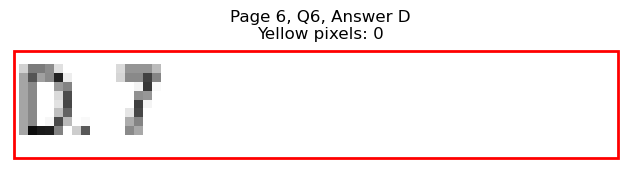

Page 6, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=340.3, y1=446.6
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 64
Page 6, Q6, E: Yellow percentage: 0.0%


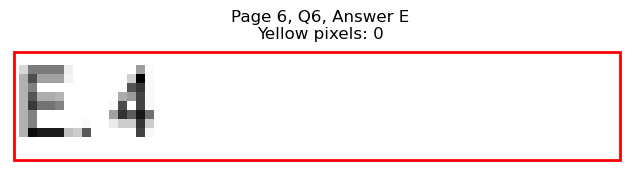


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=120.3, y1=507.4
Page 6, Q7, A: Yellow pixels: 317
Page 6, Q7, A: Total non-white pixels: 468
Page 6, Q7, A: Yellow percentage: 67.7%


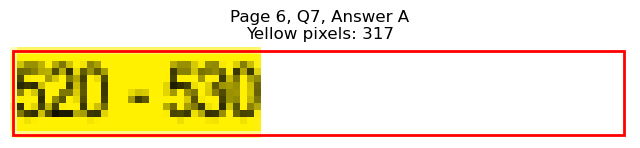

Page 6, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=119.5, y1=519.4
Page 6, Q7, B: Yellow pixels: 35
Page 6, Q7, B: Total non-white pixels: 262
Page 6, Q7, B: Yellow percentage: 13.4%


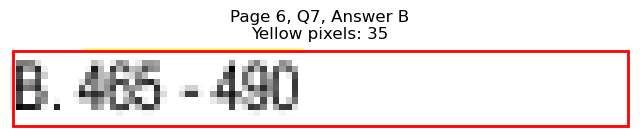

Page 6, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=120.3, y1=531.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 202
Page 6, Q7, C: Yellow percentage: 0.0%


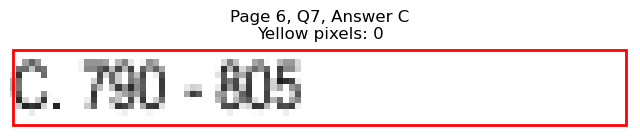

Page 6, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=371.8, y1=507.4
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 225
Page 6, Q7, D: Yellow percentage: 0.0%


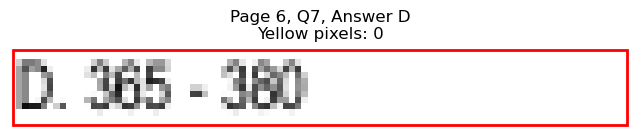

Page 6, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=371.1, y1=519.4
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 225
Page 6, Q7, E: Yellow percentage: 0.0%


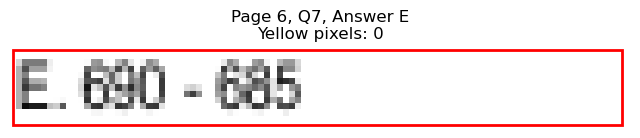


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=71.3, y0=567.5, x1=79.7, y1=579.5
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 62
Page 6, Q8, A: Yellow percentage: 0.0%


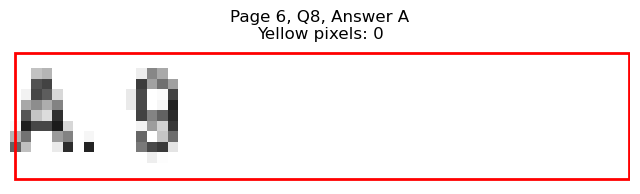

Page 6, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=88.7, y1=591.5
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 61
Page 6, Q8, B: Yellow percentage: 0.0%


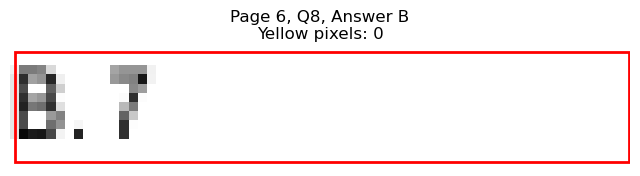

Page 6, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=89.5, y1=603.5
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 62
Page 6, Q8, C: Yellow percentage: 0.0%


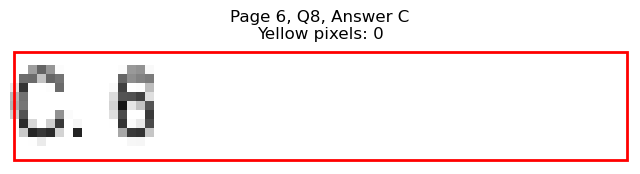

Page 6, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=341.1, y1=579.5
Page 6, Q8, D: Yellow pixels: 146
Page 6, Q8, D: Total non-white pixels: 221
Page 6, Q8, D: Yellow percentage: 66.1%


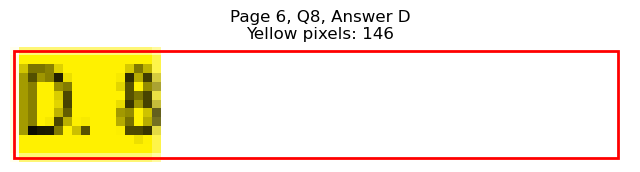

Page 6, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=340.3, y1=591.5
Page 6, Q8, E: Yellow pixels: 15
Page 6, Q8, E: Total non-white pixels: 81
Page 6, Q8, E: Yellow percentage: 18.5%


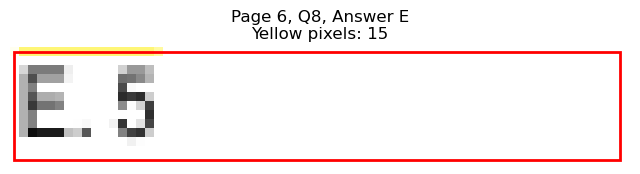


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=162.2, y1=639.6
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 409
Page 6, Q9, A: Yellow percentage: 0.0%


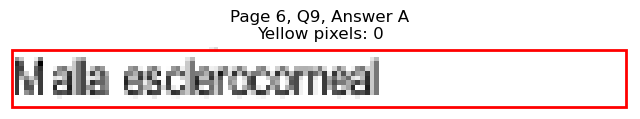

Page 6, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=127.0, y1=651.6
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 278
Page 6, Q9, B: Yellow percentage: 0.0%


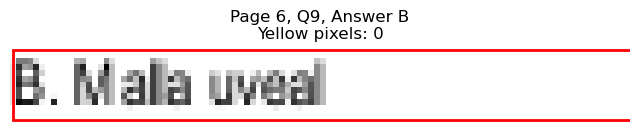

Page 6, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=224.4, y1=663.6
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 702
Page 6, Q9, C: Yellow percentage: 0.0%


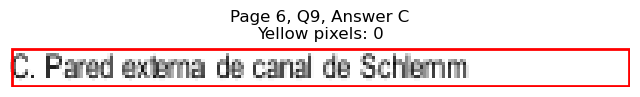

Page 6, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=394.3, y1=639.6
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 330
Page 6, Q9, D: Yellow percentage: 0.0%


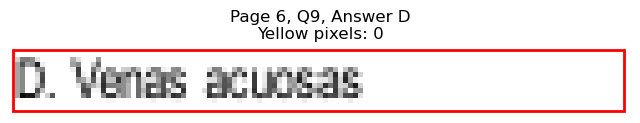

Page 6, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=459.0, y1=651.6
Page 6, Q9, E: Yellow pixels: 1212
Page 6, Q9, E: Total non-white pixels: 1755
Page 6, Q9, E: Yellow percentage: 69.1%


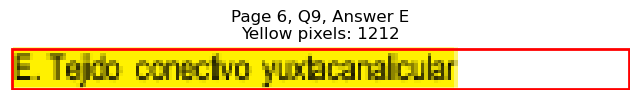


Page 6, Q9 - Selected Answer: E (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=130.7, y1=700.3
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 229
Page 6, Q10, A: Yellow percentage: 0.0%


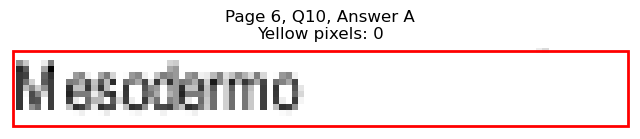

Page 6, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=134.5, y1=712.3
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 295
Page 6, Q10, B: Yellow percentage: 0.0%


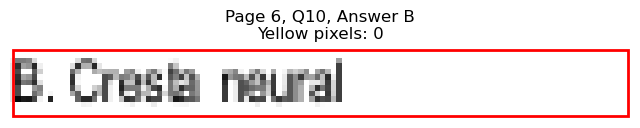

Page 6, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=146.6, y1=724.4
Page 6, Q10, C: Yellow pixels: 591
Page 6, Q10, C: Total non-white pixels: 962
Page 6, Q10, C: Yellow percentage: 61.4%


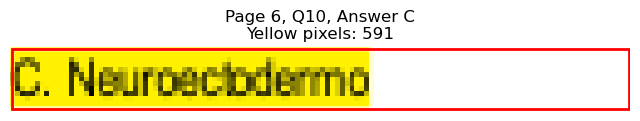

Page 6, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=416.0, y1=700.3
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 474
Page 6, Q10, D: Yellow percentage: 0.0%


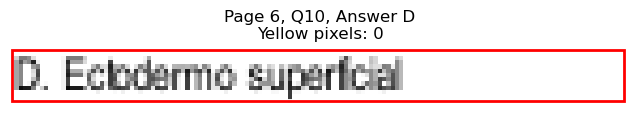

Page 6, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=384.5, y1=712.3
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 299
Page 6, Q10, E: Yellow percentage: 0.0%


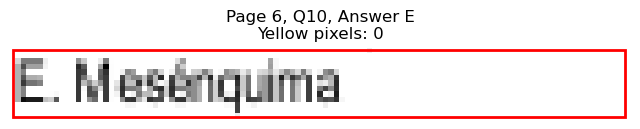


Page 6, Q10 - Selected Answer: C (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=161.5, y1=760.4
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 372
Page 6, Q11, A: Yellow percentage: 0.0%


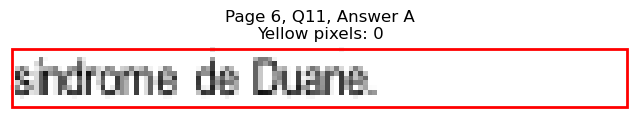

Page 6, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=129.2, y1=772.4
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 542
Page 6, Q11, B: Yellow percentage: 0.0%


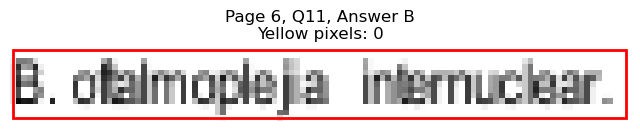

Page 6, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=165.2, y1=784.4
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 432
Page 6, Q11, C: Yellow percentage: 0.0%


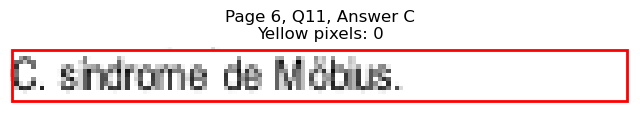

Page 6, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=446.2, y1=760.4
Page 6, Q11, D: Yellow pixels: 1073
Page 6, Q11, D: Total non-white pixels: 1586
Page 6, Q11, D: Yellow percentage: 67.7%


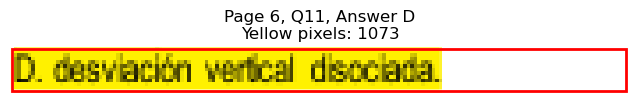

Page 6, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=482.8, y1=772.4
Page 6, Q11, E: Yellow pixels: 120
Page 6, Q11, E: Total non-white pixels: 884
Page 6, Q11, E: Yellow percentage: 13.6%


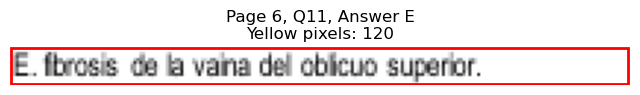


Page 6, Q11 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=133.8, y1=108.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 303
Page 7, Q1, A: Yellow percentage: 0.0%


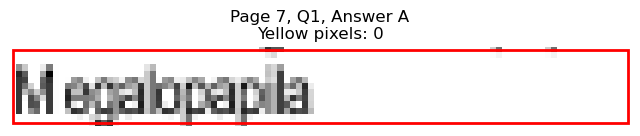

Page 7, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=121.7, y1=121.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 241
Page 7, Q1, B: Yellow percentage: 0.0%


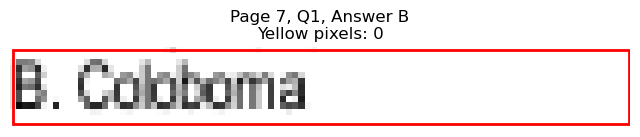

Page 7, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=134.5, y1=133.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 286
Page 7, Q1, C: Yellow percentage: 0.0%


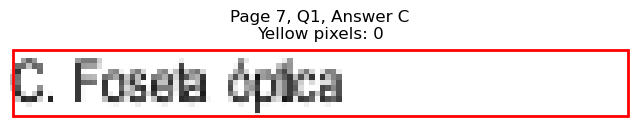

Page 7, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=379.4, y1=108.8
Page 7, Q1, D: Yellow pixels: 424
Page 7, Q1, D: Total non-white pixels: 715
Page 7, Q1, D: Yellow percentage: 59.3%


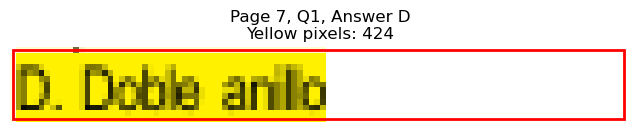

Page 7, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=362.8, y1=121.6
Page 7, Q1, E: Yellow pixels: 54
Page 7, Q1, E: Total non-white pixels: 231
Page 7, Q1, E: Yellow percentage: 23.4%


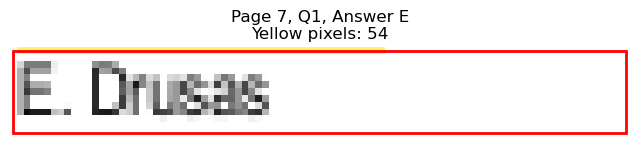


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=155.5, y1=169.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 347
Page 7, Q2, A: Yellow percentage: 0.0%


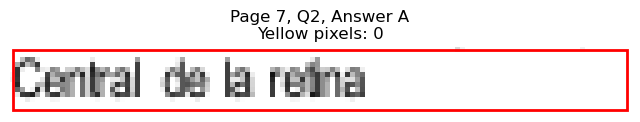

Page 7, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=181.9, y1=181.6
Page 7, Q2, B: Yellow pixels: 871
Page 7, Q2, B: Total non-white pixels: 1417
Page 7, Q2, B: Yellow percentage: 61.5%


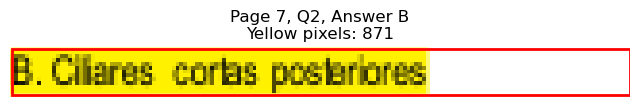

Page 7, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=178.0, y1=193.6
Page 7, Q2, C: Yellow pixels: 108
Page 7, Q2, C: Total non-white pixels: 622
Page 7, Q2, C: Yellow percentage: 17.4%


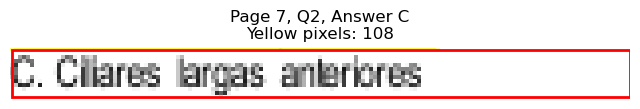

Page 7, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=377.8, y1=169.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 275
Page 7, Q2, D: Yellow percentage: 0.0%


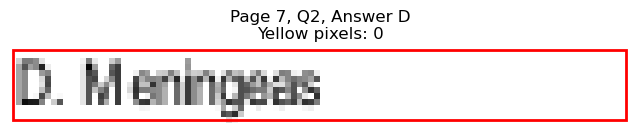

Page 7, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=367.3, y1=181.6
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 225
Page 7, Q2, E: Yellow percentage: 0.0%


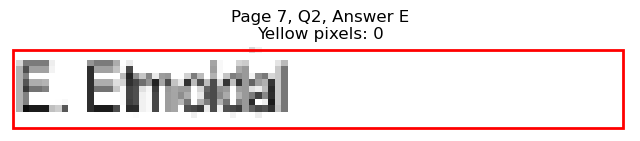


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=138.9, y0=241.6, x1=245.5, y1=253.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 520
Page 7, Q3, A: Yellow percentage: 0.0%


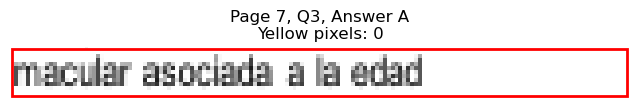

Page 7, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=145.0, y1=265.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 619
Page 7, Q3, B: Yellow percentage: 0.0%


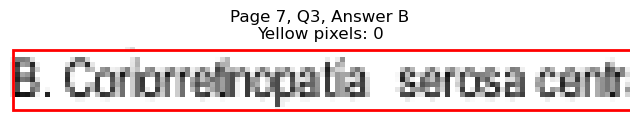

Page 7, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=124.8, y1=277.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 462
Page 7, Q3, C: Yellow percentage: 0.0%


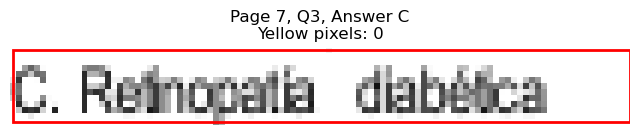

Page 7, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=376.3, y1=253.7
Page 7, Q3, D: Yellow pixels: 804
Page 7, Q3, D: Total non-white pixels: 1326
Page 7, Q3, D: Yellow percentage: 60.6%


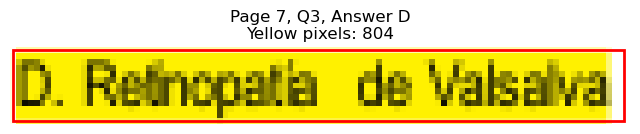

Page 7, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=399.5, y1=265.7
Page 7, Q3, E: Yellow pixels: 100
Page 7, Q3, E: Total non-white pixels: 484
Page 7, Q3, E: Yellow percentage: 20.7%


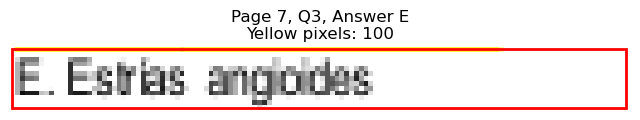


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=151.0, y1=338.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 366
Page 7, Q4, A: Yellow percentage: 0.0%


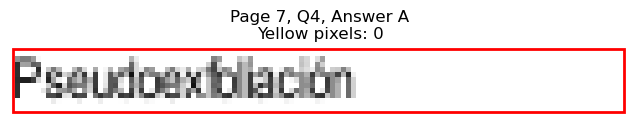

Page 7, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=146.4, y1=350.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 360
Page 7, Q4, B: Yellow percentage: 0.0%


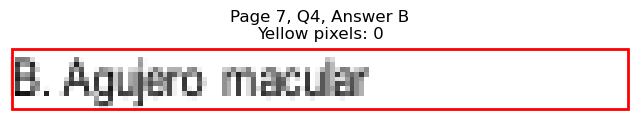

Page 7, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=125.5, y1=362.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 254
Page 7, Q4, C: Yellow percentage: 0.0%


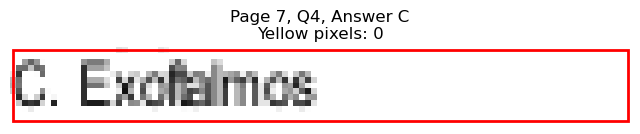

Page 7, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=369.6, y1=338.5
Page 7, Q4, D: Yellow pixels: 377
Page 7, Q4, D: Total non-white pixels: 598
Page 7, Q4, D: Yellow percentage: 63.0%


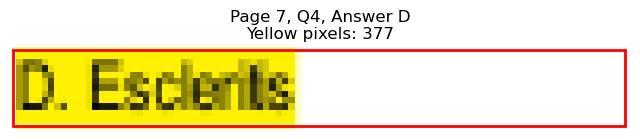

Page 7, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=377.0, y1=350.5
Page 7, Q4, E: Yellow pixels: 44
Page 7, Q4, E: Total non-white pixels: 294
Page 7, Q4, E: Yellow percentage: 15.0%


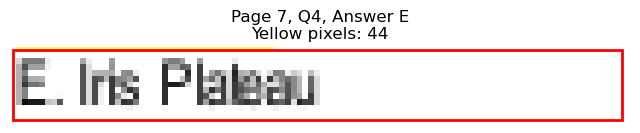


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=71.3, y0=386.5, x1=79.7, y1=398.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 66
Page 7, Q5, A: Yellow percentage: 0.0%


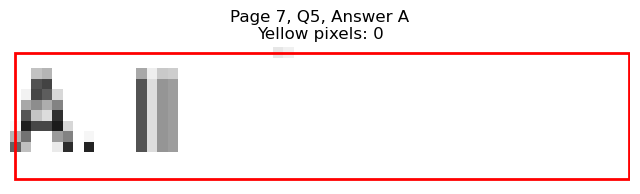

Page 7, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=91.0, y1=410.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 82
Page 7, Q5, B: Yellow percentage: 0.0%


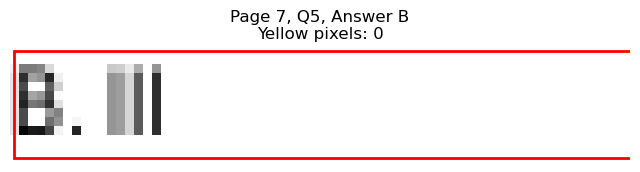

Page 7, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=87.2, y1=422.6
Page 7, Q5, C: Yellow pixels: 134
Page 7, Q5, C: Total non-white pixels: 182
Page 7, Q5, C: Yellow percentage: 73.6%


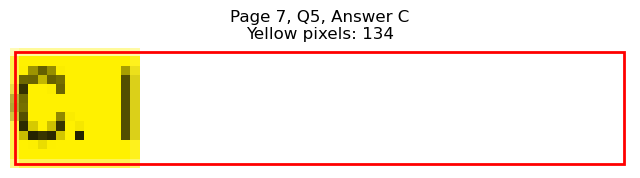

Page 7, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=344.0, y1=398.6
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 75
Page 7, Q5, D: Yellow percentage: 0.0%


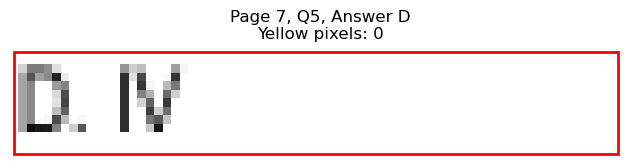

Page 7, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=341.0, y1=410.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 64
Page 7, Q5, E: Yellow percentage: 0.0%


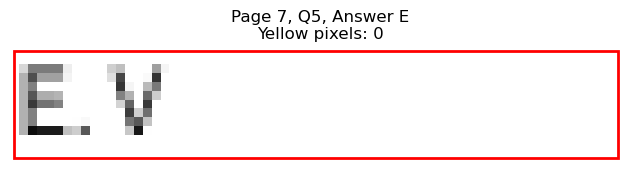


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=99.2, y1=458.6
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 92
Page 7, Q6, A: Yellow percentage: 0.0%


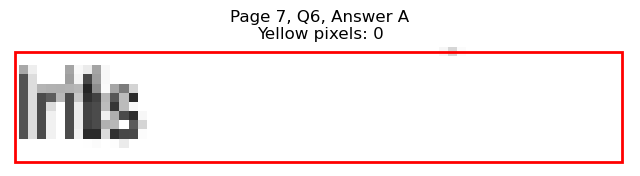

Page 7, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=117.2, y1=470.6
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 232
Page 7, Q6, B: Yellow percentage: 0.0%


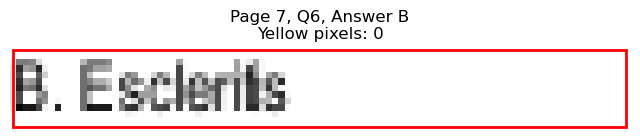

Page 7, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=123.2, y1=482.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 242
Page 7, Q6, C: Yellow percentage: 0.0%


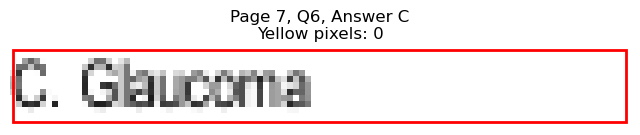

Page 7, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=379.4, y1=458.6
Page 7, Q6, D: Yellow pixels: 402
Page 7, Q6, D: Total non-white pixels: 715
Page 7, Q6, D: Yellow percentage: 56.2%


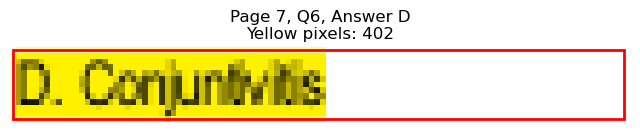

Page 7, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=369.5, y1=470.6
Page 7, Q6, E: Yellow pixels: 54
Page 7, Q6, E: Total non-white pixels: 299
Page 7, Q6, E: Yellow percentage: 18.1%


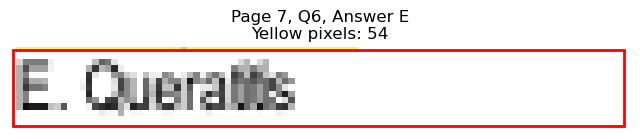


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=214.7, y0=507.4, x1=271.2, y1=519.4
Page 7, Q7, A: Yellow pixels: 491
Page 7, Q7, A: Total non-white pixels: 715
Page 7, Q7, A: Yellow percentage: 68.7%


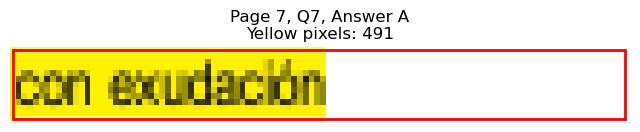

Page 7, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=228.2, y1=531.4
Page 7, Q7, B: Yellow pixels: 186
Page 7, Q7, B: Total non-white pixels: 952
Page 7, Q7, B: Yellow percentage: 19.5%


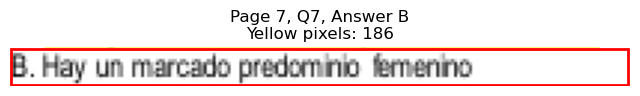

Page 7, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=136.8, y1=543.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 578
Page 7, Q7, C: Yellow percentage: 0.0%


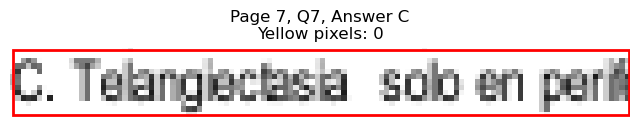

Page 7, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=449.8, y1=519.4
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 846
Page 7, Q7, D: Yellow percentage: 0.0%


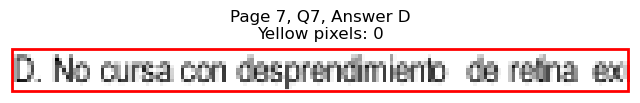

Page 7, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=447.5, y1=531.4
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 868
Page 7, Q7, E: Yellow percentage: 0.0%


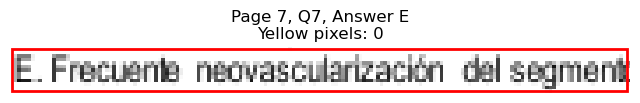


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=168.3, y1=591.5
Page 7, Q8, A: Yellow pixels: 750
Page 7, Q8, A: Total non-white pixels: 1092
Page 7, Q8, A: Yellow percentage: 68.7%


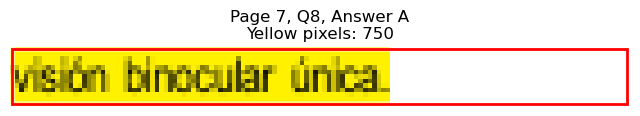

Page 7, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=156.2, y1=603.5
Page 7, Q8, B: Yellow pixels: 83
Page 7, Q8, B: Total non-white pixels: 496
Page 7, Q8, B: Yellow percentage: 16.7%


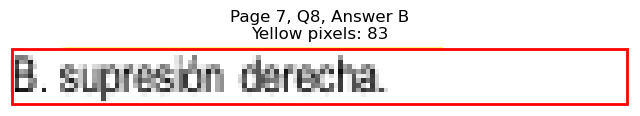

Page 7, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=160.0, y1=615.5
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 434
Page 7, Q8, C: Yellow percentage: 0.0%


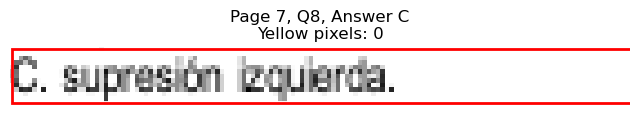

Page 7, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=365.8, y1=591.5
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 213
Page 7, Q8, D: Yellow percentage: 0.0%


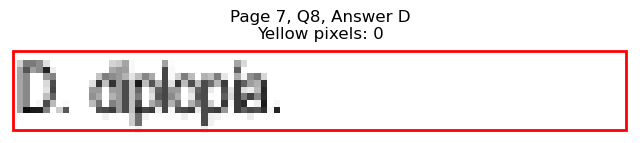

Page 7, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=412.3, y1=603.5
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 443
Page 7, Q8, E: Yellow percentage: 0.0%


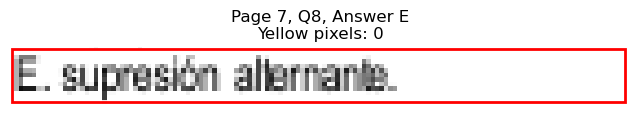


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=663.5, x1=156.2, y1=675.6
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 374
Page 7, Q9, A: Yellow percentage: 0.0%


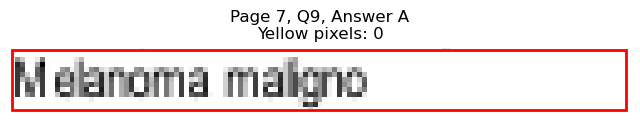

Page 7, Q9 - B: Detected box: x0=71.3, y0=676.3, x1=198.2, y1=688.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 621
Page 7, Q9, B: Yellow percentage: 0.0%


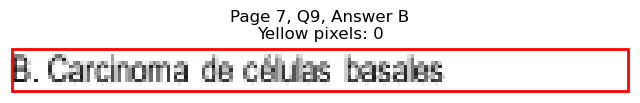

Page 7, Q9 - C: Detected box: x0=71.3, y0=688.3, x1=173.5, y1=700.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 491
Page 7, Q9, C: Yellow percentage: 0.0%


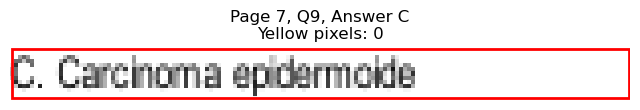

Page 7, Q9 - D: Detected box: x0=322.9, y0=663.5, x1=457.5, y1=675.6
Page 7, Q9, D: Yellow pixels: 1058
Page 7, Q9, D: Total non-white pixels: 1742
Page 7, Q9, D: Yellow percentage: 60.7%


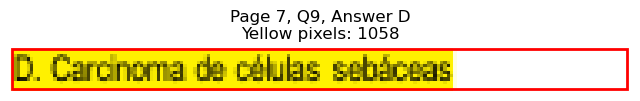

Page 7, Q9 - E: Detected box: x0=322.9, y0=676.3, x1=401.0, y1=688.3
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 541
Page 7, Q9, E: Yellow percentage: 0.0%


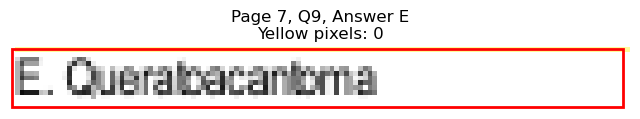


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=82.6, y0=724.3, x1=130.0, y1=736.4
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 260
Page 7, Q10, A: Yellow percentage: 0.0%


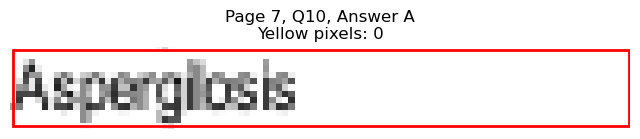

Page 7, Q10 - B: Detected box: x0=71.3, y0=736.4, x1=126.2, y1=748.4
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 289
Page 7, Q10, B: Yellow percentage: 0.0%


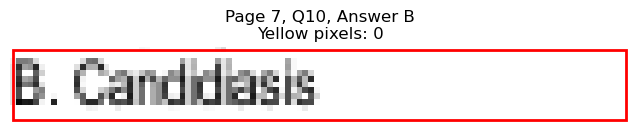

Page 7, Q10 - C: Detected box: x0=71.3, y0=748.4, x1=138.9, y1=760.4
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 287
Page 7, Q10, C: Yellow percentage: 0.0%


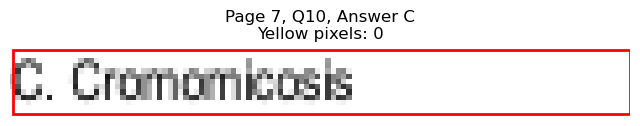

Page 7, Q10 - D: Detected box: x0=322.9, y0=724.3, x1=380.9, y1=736.4
Page 7, Q10, D: Yellow pixels: 464
Page 7, Q10, D: Total non-white pixels: 741
Page 7, Q10, D: Yellow percentage: 62.6%


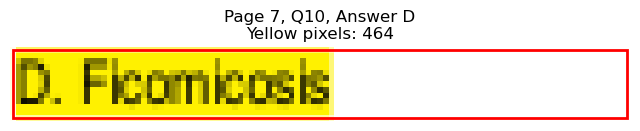

Page 7, Q10 - E: Detected box: x0=322.9, y0=736.4, x1=380.1, y1=748.4
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 304
Page 7, Q10, E: Yellow percentage: 0.0%


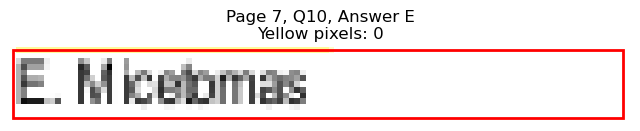


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=128.5, y1=108.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 242
Page 8, Q1, A: Yellow percentage: 0.0%


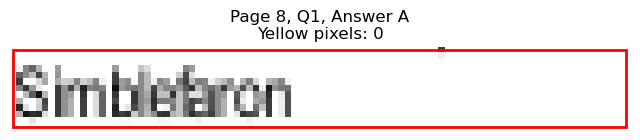

Page 8, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=128.5, y1=121.6
Page 8, Q1, B: Yellow pixels: 462
Page 8, Q1, B: Total non-white pixels: 728
Page 8, Q1, B: Yellow percentage: 63.5%


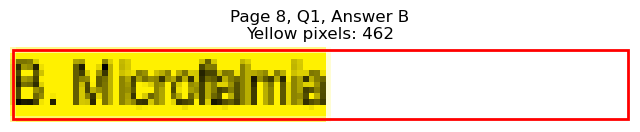

Page 8, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=106.7, y1=133.6
Page 8, Q1, C: Yellow pixels: 55
Page 8, Q1, C: Total non-white pixels: 230
Page 8, Q1, C: Yellow percentage: 23.9%


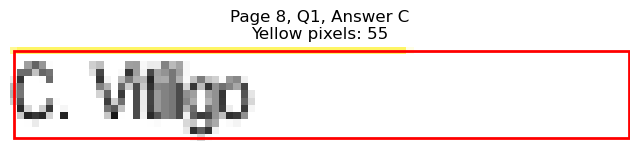

Page 8, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=380.0, y1=108.8
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 293
Page 8, Q1, D: Yellow percentage: 0.0%


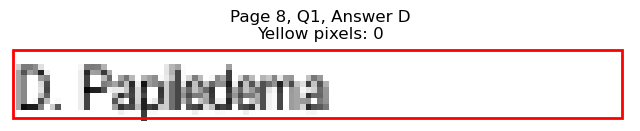

Page 8, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=361.3, y1=121.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 180
Page 8, Q1, E: Yellow percentage: 0.0%


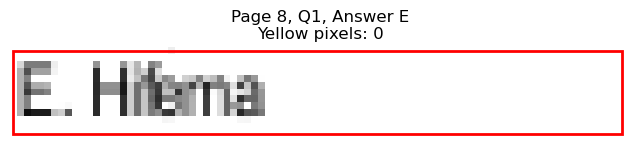


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=179.5, y1=181.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 462
Page 8, Q2, A: Yellow percentage: 0.0%


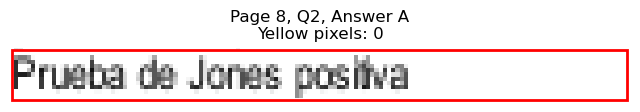

Page 8, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=144.3, y1=193.6
Page 8, Q2, B: Yellow pixels: 568
Page 8, Q2, B: Total non-white pixels: 925
Page 8, Q2, B: Yellow percentage: 61.4%


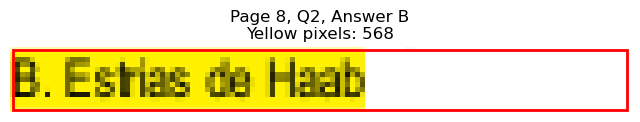

Page 8, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=132.2, y1=205.6
Page 8, Q2, C: Yellow pixels: 71
Page 8, Q2, C: Total non-white pixels: 342
Page 8, Q2, C: Yellow percentage: 20.8%


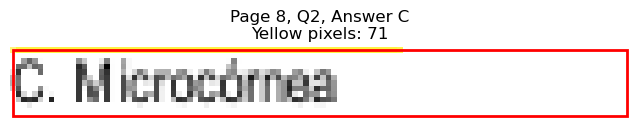

Page 8, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=378.5, y1=181.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 440
Page 8, Q2, D: Yellow percentage: 0.0%


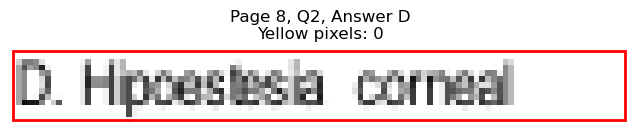

Page 8, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=362.8, y1=193.6
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 196
Page 8, Q2, E: Yellow percentage: 0.0%


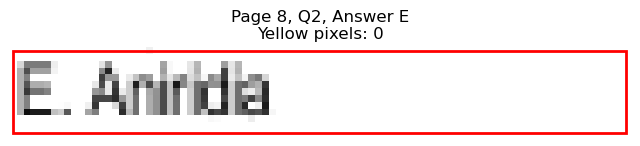


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=240.1, y1=253.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 752
Page 8, Q3, A: Yellow percentage: 0.0%


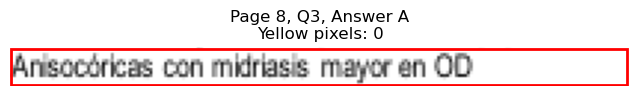

Page 8, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=225.9, y1=265.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 714
Page 8, Q3, B: Yellow percentage: 0.0%


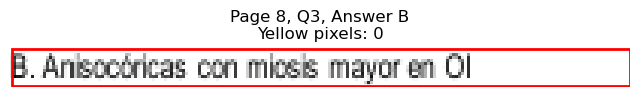

Page 8, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=138.2, y1=277.7
Page 8, Q3, C: Yellow pixels: 895
Page 8, Q3, C: Total non-white pixels: 1405
Page 8, Q3, C: Yellow percentage: 63.7%


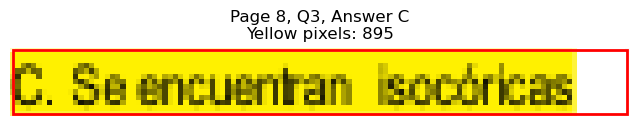

Page 8, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=458.8, y1=253.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 907
Page 8, Q3, D: Yellow percentage: 0.0%


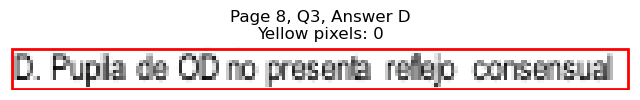

Page 8, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=488.8, y1=265.7
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 796
Page 8, Q3, E: Yellow percentage: 0.0%


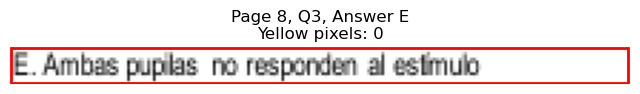


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=133.0, y1=314.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 256
Page 8, Q4, A: Yellow percentage: 0.0%


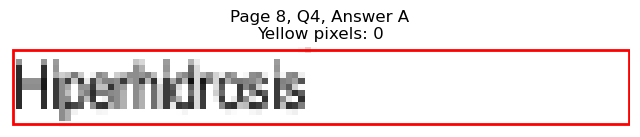

Page 8, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=133.7, y1=326.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 284
Page 8, Q4, B: Yellow percentage: 0.0%


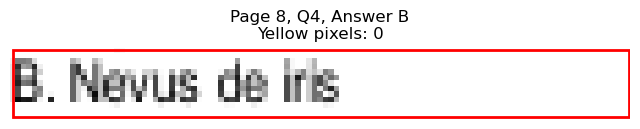

Page 8, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=161.5, y1=338.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 447
Page 8, Q4, C: Yellow percentage: 0.0%


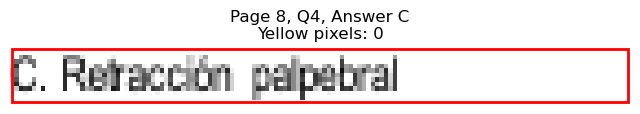

Page 8, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=361.3, y1=314.5
Page 8, Q4, D: Yellow pixels: 320
Page 8, Q4, D: Total non-white pixels: 483
Page 8, Q4, D: Yellow percentage: 66.3%


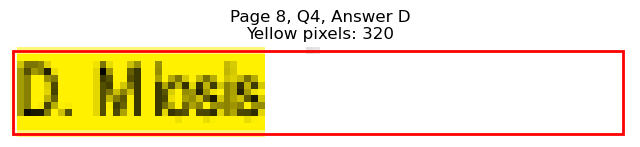

Page 8, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=377.7, y1=326.5
Page 8, Q4, E: Yellow pixels: 36
Page 8, Q4, E: Total non-white pixels: 301
Page 8, Q4, E: Yellow percentage: 12.0%


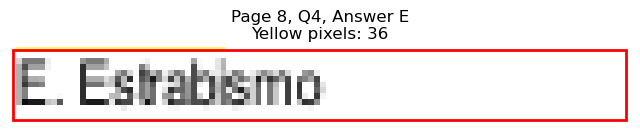


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=226.7, y1=374.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 952
Page 8, Q5, A: Yellow percentage: 0.0%


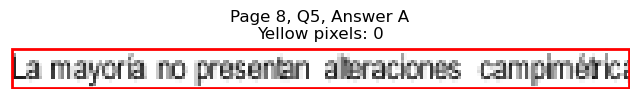

Page 8, Q5 - B: Detected box: x0=146.3, y0=374.5, x1=228.2, y1=386.6
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 392
Page 8, Q5, B: Yellow percentage: 0.0%


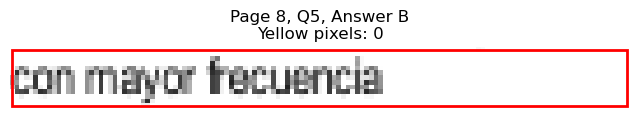

Page 8, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=242.7, y1=398.6
Page 8, Q5, C: Yellow pixels: 1349
Page 8, Q5, C: Total non-white pixels: 2210
Page 8, Q5, C: Yellow percentage: 61.0%


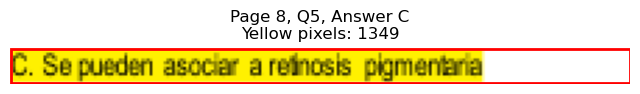

Page 8, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=482.2, y1=374.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 953
Page 8, Q5, D: Yellow percentage: 0.0%


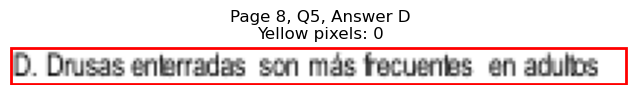

Page 8, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=457.3, y1=386.6
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 865
Page 8, Q5, E: Yellow percentage: 0.0%


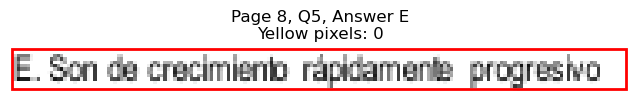


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=128.5, y1=434.6
Page 8, Q6, A: Yellow pixels: 319
Page 8, Q6, A: Total non-white pixels: 587
Page 8, Q6, A: Yellow percentage: 54.3%


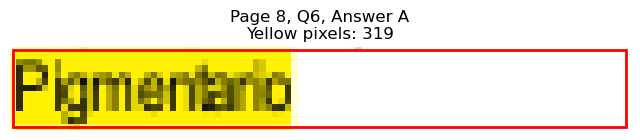

Page 8, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=120.2, y1=446.6
Page 8, Q6, B: Yellow pixels: 43
Page 8, Q6, B: Total non-white pixels: 296
Page 8, Q6, B: Yellow percentage: 14.5%


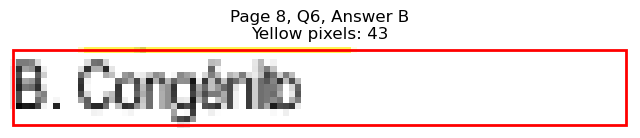

Page 8, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=109.0, y1=458.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 174
Page 8, Q6, C: Yellow percentage: 0.0%


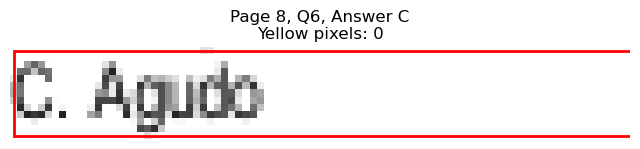

Page 8, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=383.1, y1=434.6
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 293
Page 8, Q6, D: Yellow percentage: 0.0%


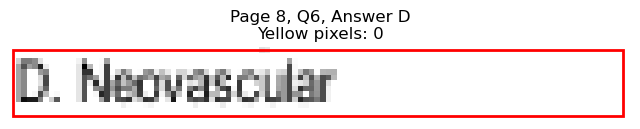

Page 8, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=377.0, y1=446.6
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 265
Page 8, Q6, E: Yellow percentage: 0.0%


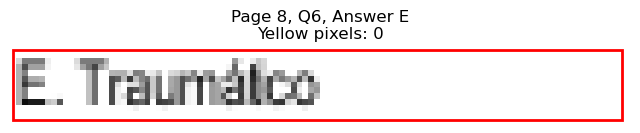


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=136.0, y1=519.4
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 259
Page 8, Q7, A: Yellow percentage: 0.0%


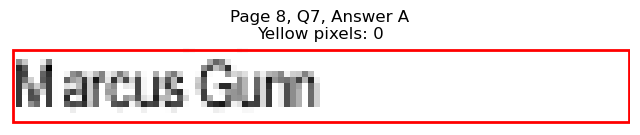

Page 8, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=100.8, y1=531.4
Page 8, Q7, B: Yellow pixels: 249
Page 8, Q7, B: Total non-white pixels: 364
Page 8, Q7, B: Yellow percentage: 68.4%


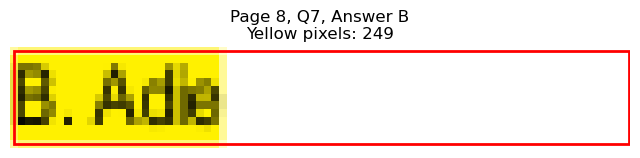

Page 8, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=146.5, y1=543.5
Page 8, Q7, C: Yellow pixels: 26
Page 8, Q7, C: Total non-white pixels: 386
Page 8, Q7, C: Yellow percentage: 6.7%


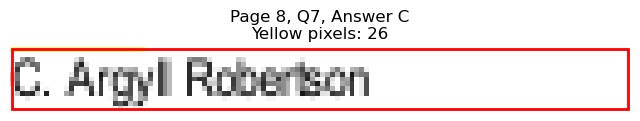

Page 8, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=371.8, y1=519.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 228
Page 8, Q7, D: Yellow percentage: 0.0%


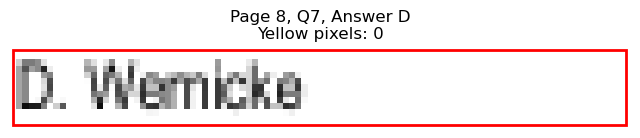

Page 8, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=360.5, y1=531.4
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 181
Page 8, Q7, E: Yellow percentage: 0.0%


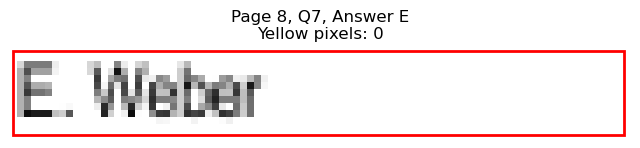


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=174.2, y1=579.5
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 475
Page 8, Q8, A: Yellow percentage: 0.0%


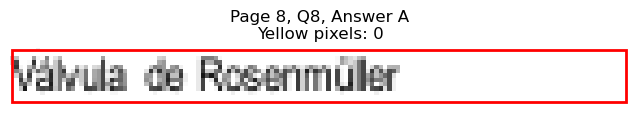

Page 8, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=121.7, y1=591.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 380
Page 8, Q8, B: Yellow percentage: 0.0%


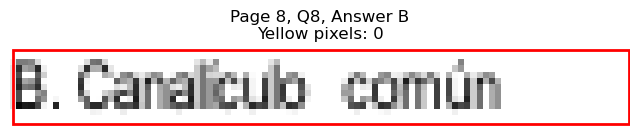

Page 8, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=135.2, y1=603.5
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 307
Page 8, Q8, C: Yellow percentage: 0.0%


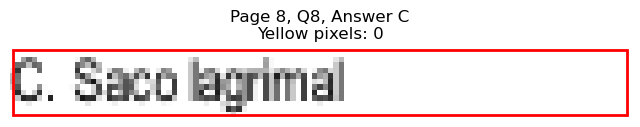

Page 8, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=374.0, y1=579.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 507
Page 8, Q8, D: Yellow percentage: 0.0%


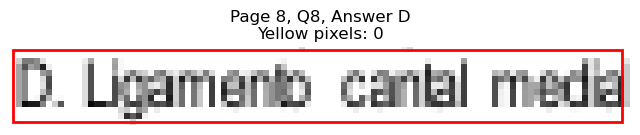

Page 8, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=405.6, y1=591.5
Page 8, Q8, E: Yellow pixels: 713
Page 8, Q8, E: Total non-white pixels: 1066
Page 8, Q8, E: Yellow percentage: 66.9%


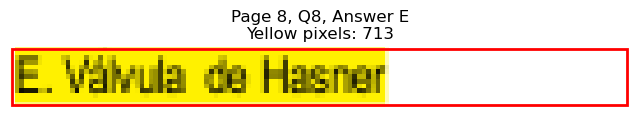


Page 8, Q8 - Selected Answer: E (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=155.5, y1=639.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 370
Page 8, Q9, A: Yellow percentage: 0.0%


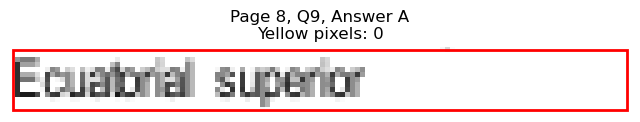

Page 8, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=112.7, y1=651.6
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 196
Page 8, Q9, B: Yellow percentage: 0.0%


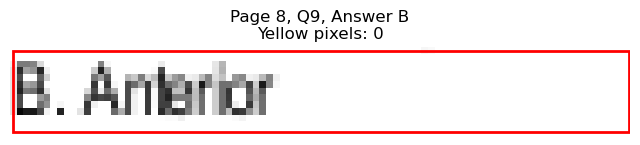

Page 8, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=149.5, y1=663.6
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 376
Page 8, Q9, C: Yellow percentage: 0.0%


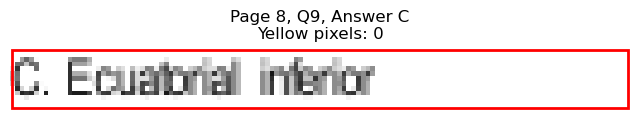

Page 8, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=369.6, y1=639.6
Page 8, Q9, D: Yellow pixels: 387
Page 8, Q9, D: Total non-white pixels: 598
Page 8, Q9, D: Yellow percentage: 64.7%


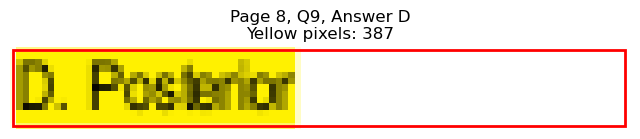

Page 8, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=408.5, y1=651.6
Page 8, Q9, E: Yellow pixels: 44
Page 8, Q9, E: Total non-white pixels: 463
Page 8, Q9, E: Yellow percentage: 9.5%


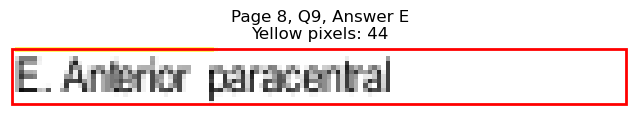


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=92.5, y1=700.3
Page 8, Q10, A: Yellow pixels: 48
Page 8, Q10, A: Total non-white pixels: 117
Page 8, Q10, A: Yellow percentage: 41.0%


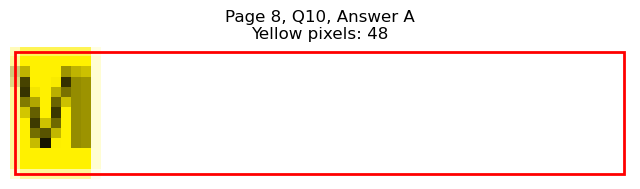

Page 8, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=91.0, y1=712.3
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 91
Page 8, Q10, B: Yellow percentage: 0.0%


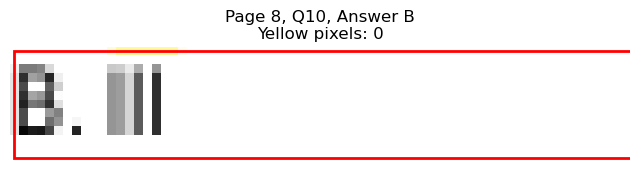

Page 8, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=92.5, y1=724.4
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 73
Page 8, Q10, C: Yellow percentage: 0.0%


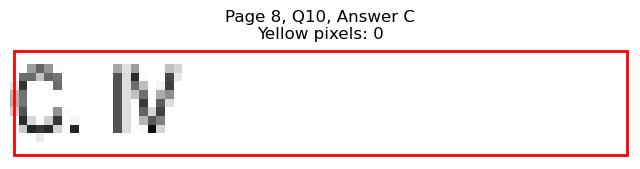

Page 8, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=346.3, y1=700.3
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 99
Page 8, Q10, D: Yellow percentage: 0.0%


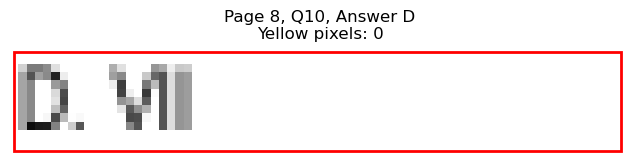

Page 8, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=341.0, y1=712.3
Page 8, Q10, E: Yellow pixels: 0
Page 8, Q10, E: Total non-white pixels: 64
Page 8, Q10, E: Yellow percentage: 0.0%


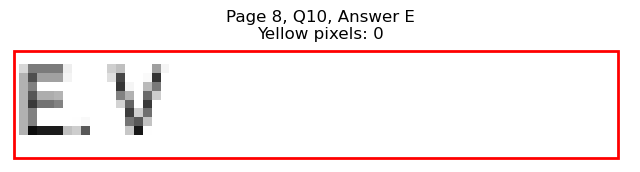


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=101.5, y1=760.4
Page 8, Q11, A: Yellow pixels: 0
Page 8, Q11, A: Total non-white pixels: 69
Page 8, Q11, A: Yellow percentage: 0.0%


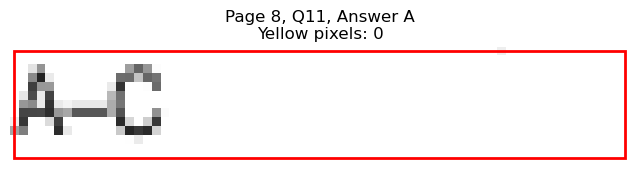

Page 8, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=100.8, y1=772.4
Page 8, Q11, B: Yellow pixels: 262
Page 8, Q11, B: Total non-white pixels: 364
Page 8, Q11, B: Yellow percentage: 72.0%


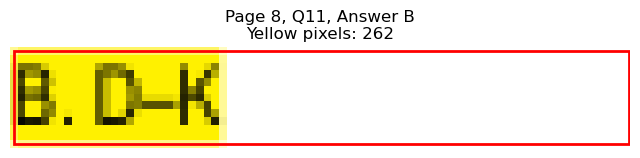

Page 8, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=122.5, y1=784.4
Page 8, Q11, C: Yellow pixels: 26
Page 8, Q11, C: Total non-white pixels: 191
Page 8, Q11, C: Yellow percentage: 13.6%


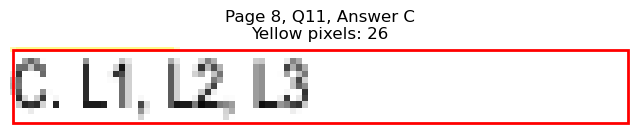

Page 8, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=362.0, y1=760.4
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 148
Page 8, Q11, D: Yellow percentage: 0.0%


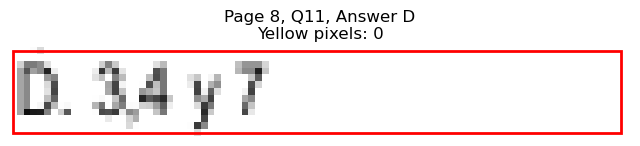

Page 8, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=371.2, y1=772.4
Page 8, Q11, E: Yellow pixels: 0
Page 8, Q11, E: Total non-white pixels: 204
Page 8, Q11, E: Yellow percentage: 0.0%


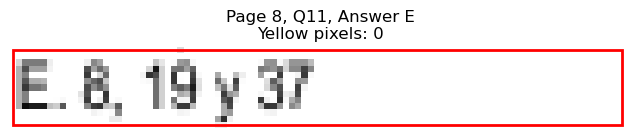


Page 8, Q11 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=147.8, y0=96.8, x1=289.0, y1=108.8
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 772
Page 9, Q1, A: Yellow percentage: 0.0%


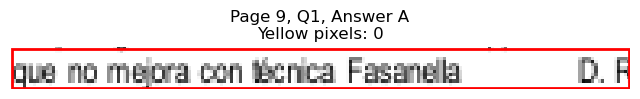

Page 9, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=133.0, y1=121.6
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 502
Page 9, Q1, B: Yellow percentage: 0.0%


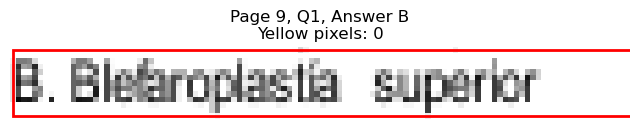

Page 9, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=170.5, y1=133.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 472
Page 9, Q1, C: Yellow percentage: 0.0%


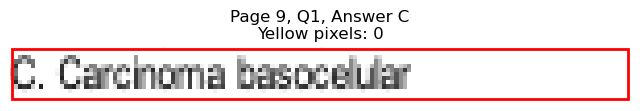

Page 9, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=477.6, y1=108.8
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 918
Page 9, Q1, D: Yellow percentage: 0.0%


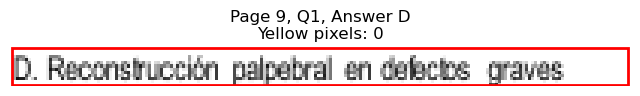

Page 9, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=527.7, y1=121.6
Page 9, Q1, E: Yellow pixels: 1866
Page 9, Q1, E: Total non-white pixels: 2652
Page 9, Q1, E: Yellow percentage: 70.4%


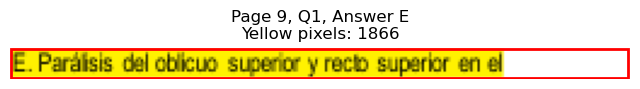


Page 9, Q1 - Selected Answer: E (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=163.8, y1=169.6
Page 9, Q2, A: Yellow pixels: 612
Page 9, Q2, A: Total non-white pixels: 1040
Page 9, Q2, A: Yellow percentage: 58.8%


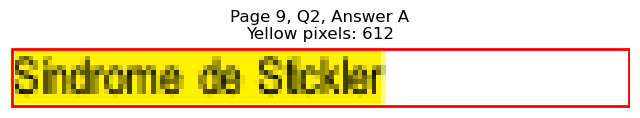

Page 9, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=165.2, y1=181.6
Page 9, Q2, B: Yellow pixels: 78
Page 9, Q2, B: Total non-white pixels: 543
Page 9, Q2, B: Yellow percentage: 14.4%


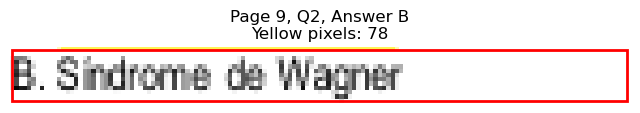

Page 9, Q2 - C: Detected box: x0=129.1, y0=181.6, x1=200.5, y1=193.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 372
Page 9, Q2, C: Yellow percentage: 0.0%


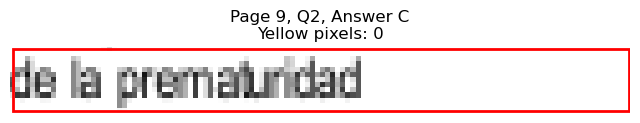

Page 9, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=413.8, y1=169.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 604
Page 9, Q2, D: Yellow percentage: 0.0%


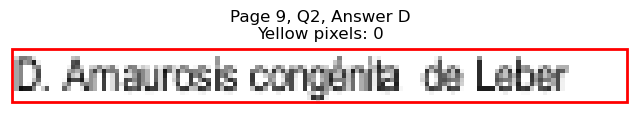

Page 9, Q2 - E: Detected box: x0=427.1, y0=169.6, x1=504.0, y1=181.6
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 388
Page 9, Q2, E: Yellow percentage: 0.0%


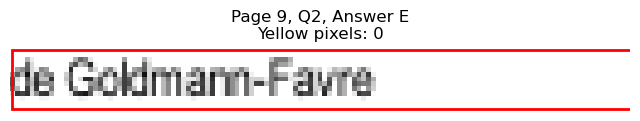


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=145.1, y1=229.7
Page 9, Q3, A: Yellow pixels: 484
Page 9, Q3, A: Total non-white pixels: 793
Page 9, Q3, A: Yellow percentage: 61.0%


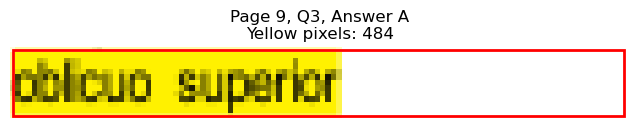

Page 9, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=138.2, y1=241.7
Page 9, Q3, B: Yellow pixels: 60
Page 9, Q3, B: Total non-white pixels: 385
Page 9, Q3, B: Yellow percentage: 15.6%


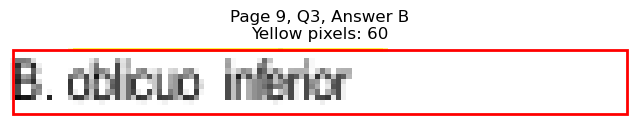

Page 9, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=130.0, y1=253.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 253
Page 9, Q3, C: Yellow percentage: 0.0%


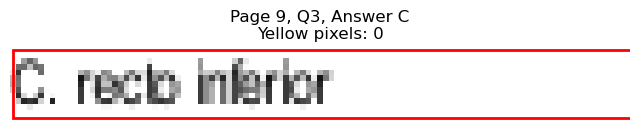

Page 9, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=387.5, y1=229.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 304
Page 9, Q3, D: Yellow percentage: 0.0%


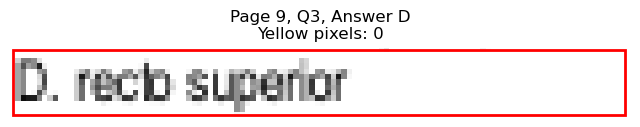

Page 9, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=381.5, y1=241.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 268
Page 9, Q3, E: Yellow percentage: 0.0%


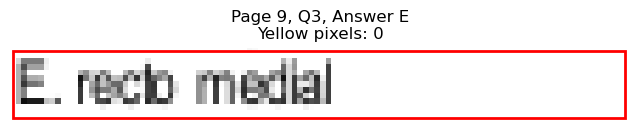


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=110.5, y1=301.8
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 141
Page 9, Q4, A: Yellow percentage: 0.0%


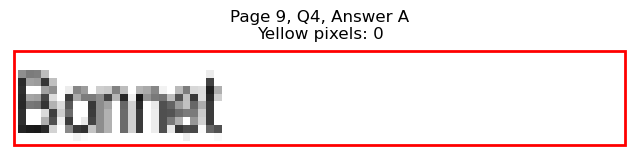

Page 9, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=108.2, y1=314.5
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 178
Page 9, Q4, B: Yellow percentage: 0.0%


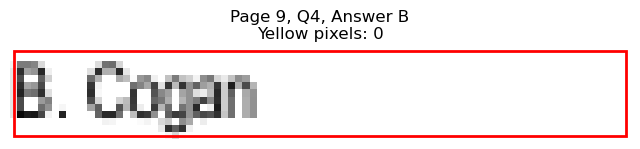

Page 9, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=106.0, y1=326.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 142
Page 9, Q4, C: Yellow percentage: 0.0%


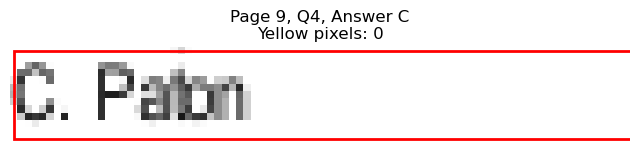

Page 9, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=357.6, y1=301.8
Page 9, Q4, D: Yellow pixels: 258
Page 9, Q4, D: Total non-white pixels: 442
Page 9, Q4, D: Yellow percentage: 58.4%


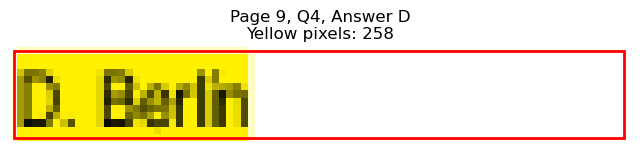

Page 9, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=361.3, y1=314.5
Page 9, Q4, E: Yellow pixels: 32
Page 9, Q4, E: Total non-white pixels: 199
Page 9, Q4, E: Yellow percentage: 16.1%


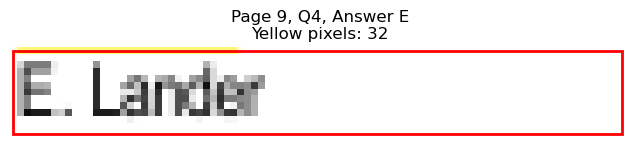


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=123.3, y1=374.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 222
Page 9, Q5, A: Yellow percentage: 0.0%


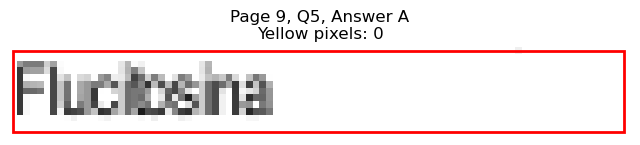

Page 9, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=129.2, y1=386.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 281
Page 9, Q5, B: Yellow percentage: 0.0%


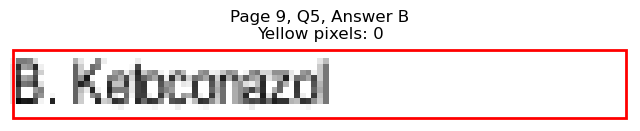

Page 9, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=125.5, y1=398.6
Page 9, Q5, C: Yellow pixels: 418
Page 9, Q5, C: Total non-white pixels: 689
Page 9, Q5, C: Yellow percentage: 60.7%


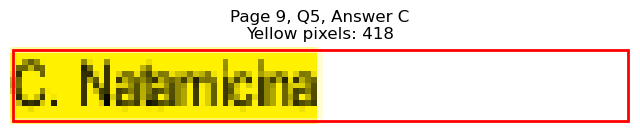

Page 9, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=376.3, y1=374.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 253
Page 9, Q5, D: Yellow percentage: 0.0%


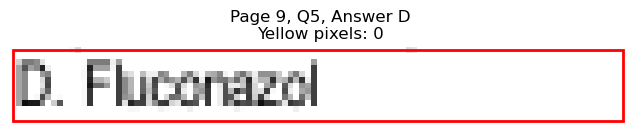

Page 9, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=374.0, y1=386.6
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 233
Page 9, Q5, E: Yellow percentage: 0.0%


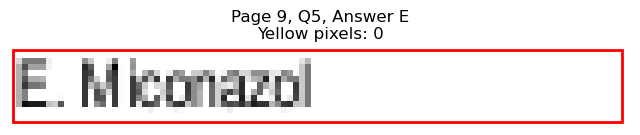


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=121.0, y1=458.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 204
Page 9, Q6, A: Yellow percentage: 0.0%


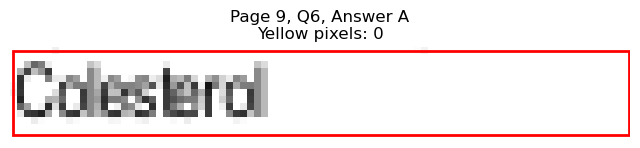

Page 9, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=110.5, y1=470.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 193
Page 9, Q6, B: Yellow percentage: 0.0%


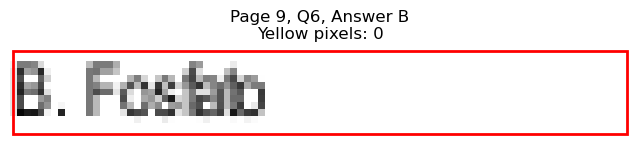

Page 9, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=114.2, y1=482.6
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 196
Page 9, Q6, C: Yellow percentage: 0.0%


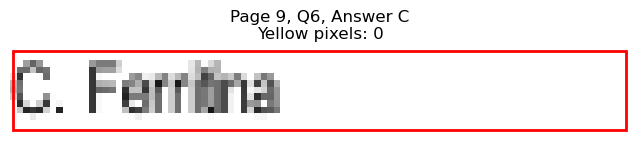

Page 9, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=360.6, y1=458.6
Page 9, Q6, D: Yellow pixels: 283
Page 9, Q6, D: Total non-white pixels: 481
Page 9, Q6, D: Yellow percentage: 58.8%


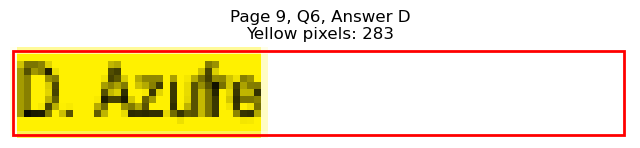

Page 9, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=350.8, y1=470.6
Page 9, Q6, E: Yellow pixels: 35
Page 9, Q6, E: Total non-white pixels: 156
Page 9, Q6, E: Yellow percentage: 22.4%


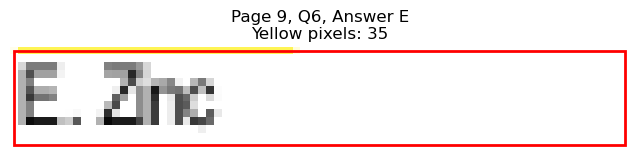


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=225.2, y1=519.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 674
Page 9, Q7, A: Yellow percentage: 0.0%


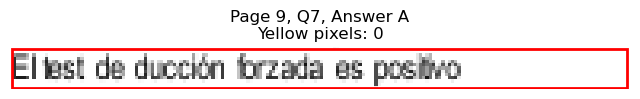

Page 9, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=233.5, y1=531.4
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 841
Page 9, Q7, B: Yellow percentage: 0.0%


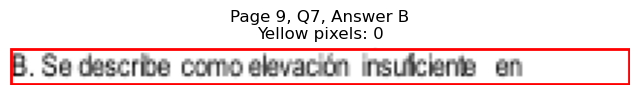

Page 9, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=193.0, y1=555.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 829
Page 9, Q7, C: Yellow percentage: 0.0%


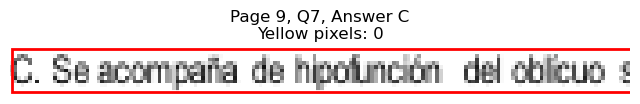

Page 9, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=416.0, y1=519.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 404
Page 9, Q7, D: Yellow percentage: 0.0%


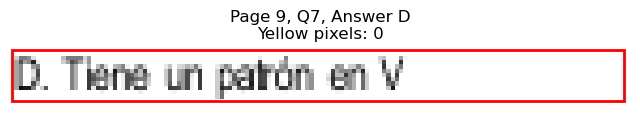

Page 9, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=416.9, y1=531.4
Page 9, Q7, E: Yellow pixels: 866
Page 9, Q7, E: Total non-white pixels: 1209
Page 9, Q7, E: Yellow percentage: 71.6%


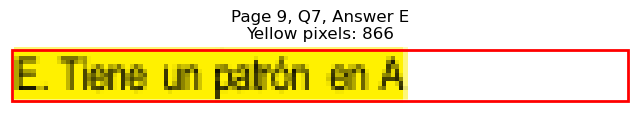


Page 9, Q7 - Selected Answer: E (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=148.7, y1=591.5
Page 9, Q8, A: Yellow pixels: 1035
Page 9, Q8, A: Total non-white pixels: 1469
Page 9, Q8, A: Yellow percentage: 70.5%


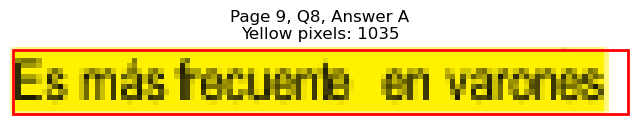

Page 9, Q8 - B: Detected box: x0=131.3, y0=591.5, x1=249.9, y1=603.5
Page 9, Q8, B: Yellow pixels: 63
Page 9, Q8, B: Total non-white pixels: 627
Page 9, Q8, B: Yellow percentage: 10.0%


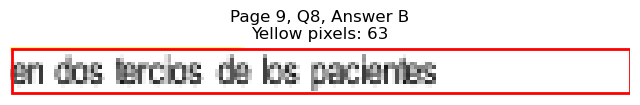

Page 9, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=248.5, y1=615.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 813
Page 9, Q8, C: Yellow percentage: 0.0%


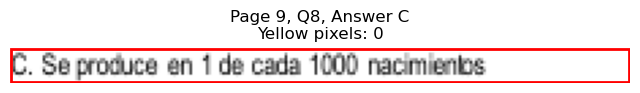

Page 9, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=400.3, y1=591.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 596
Page 9, Q8, D: Yellow percentage: 0.0%


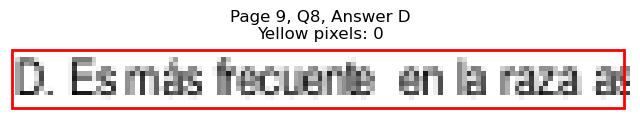

Page 9, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=459.5, y1=603.5
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 608
Page 9, Q8, E: Yellow percentage: 0.0%


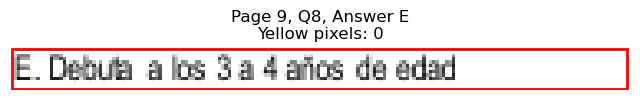


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=71.3, y0=639.5, x1=79.7, y1=651.6
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 68
Page 9, Q9, A: Yellow percentage: 0.0%


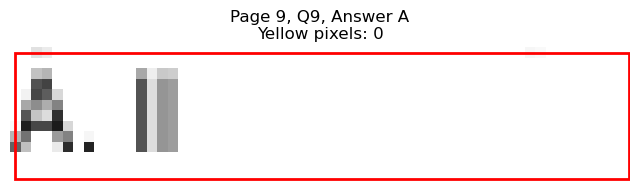

Page 9, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=86.5, y1=663.6
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 58
Page 9, Q9, B: Yellow percentage: 0.0%


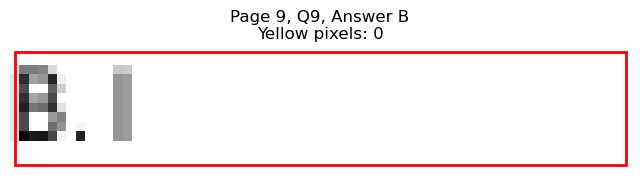

Page 9, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=92.5, y1=675.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 73
Page 9, Q9, C: Yellow percentage: 0.0%


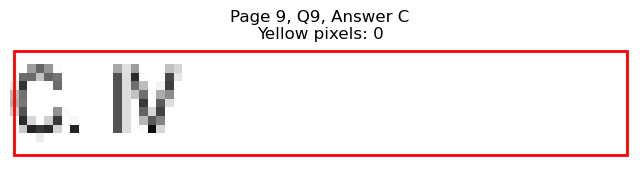

Page 9, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=343.3, y1=651.6
Page 9, Q9, D: Yellow pixels: 168
Page 9, Q9, D: Total non-white pixels: 249
Page 9, Q9, D: Yellow percentage: 67.5%


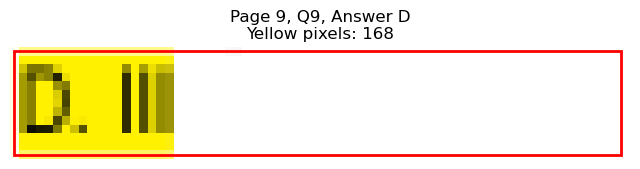

Page 9, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=341.0, y1=663.6
Page 9, Q9, E: Yellow pixels: 18
Page 9, Q9, E: Total non-white pixels: 83
Page 9, Q9, E: Yellow percentage: 21.7%


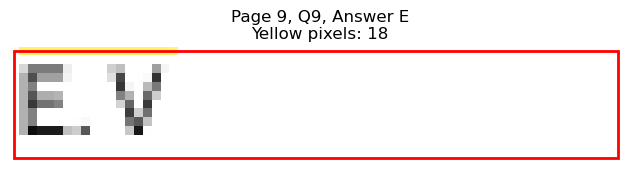


Page 9, Q9 - Selected Answer: D (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=175.1, y1=712.3
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 483
Page 9, Q10, A: Yellow percentage: 0.0%


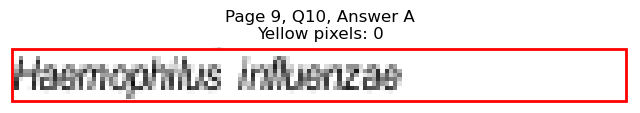

Page 9, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=189.4, y1=724.4
Page 9, Q10, B: Yellow pixels: 922
Page 9, Q10, B: Total non-white pixels: 1508
Page 9, Q10, B: Yellow percentage: 61.1%


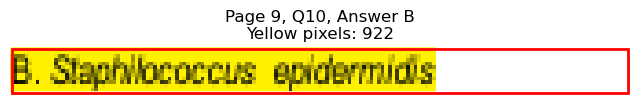

Page 9, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=178.9, y1=736.4
Page 9, Q10, C: Yellow pixels: 2
Page 9, Q10, C: Total non-white pixels: 624
Page 9, Q10, C: Yellow percentage: 0.3%


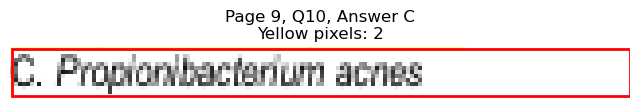

Page 9, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=421.4, y1=712.3
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 508
Page 9, Q10, D: Yellow percentage: 0.0%


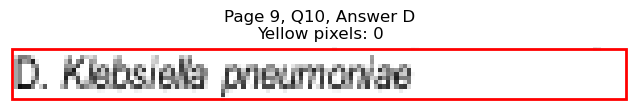

Page 9, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=398.1, y1=724.4
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 349
Page 9, Q10, E: Yellow percentage: 0.0%


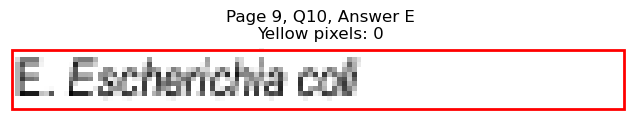


Page 9, Q10 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=131.3, y0=109.5, x1=177.2, y1=121.6
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 237
Page 10, Q1, A: Yellow percentage: 0.0%


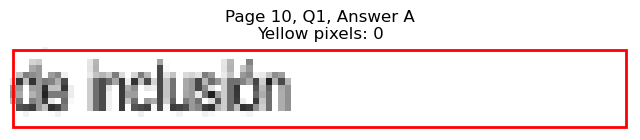

Page 10, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=148.0, y1=133.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 394
Page 10, Q1, B: Yellow percentage: 0.0%


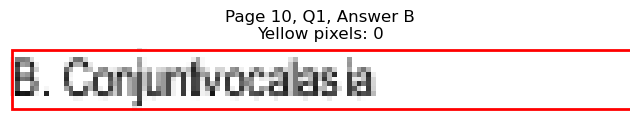

Page 10, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=173.5, y1=145.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 646
Page 10, Q1, C: Yellow percentage: 0.0%


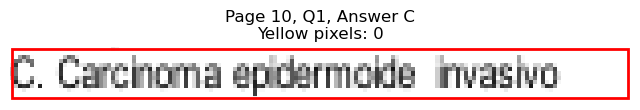

Page 10, Q1 - D: Detected box: x0=376.9, y0=109.5, x1=438.7, y1=121.6
Page 10, Q1, D: Yellow pixels: 541
Page 10, Q1, D: Total non-white pixels: 793
Page 10, Q1, D: Yellow percentage: 68.2%


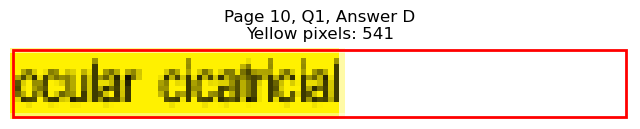

Page 10, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=393.5, y1=133.6
Page 10, Q1, E: Yellow pixels: 113
Page 10, Q1, E: Total non-white pixels: 727
Page 10, Q1, E: Yellow percentage: 15.5%


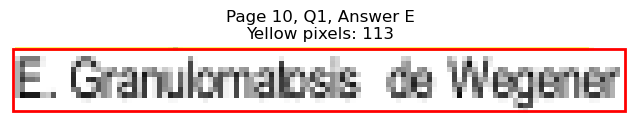


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=116.3, y0=169.6, x1=153.3, y1=181.6
Page 10, Q2, A: Yellow pixels: 263
Page 10, Q2, A: Total non-white pixels: 455
Page 10, Q2, A: Yellow percentage: 57.8%


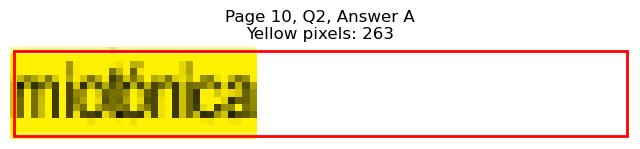

Page 10, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=115.7, y1=193.6
Page 10, Q2, B: Yellow pixels: 68
Page 10, Q2, B: Total non-white pixels: 302
Page 10, Q2, B: Yellow percentage: 22.5%


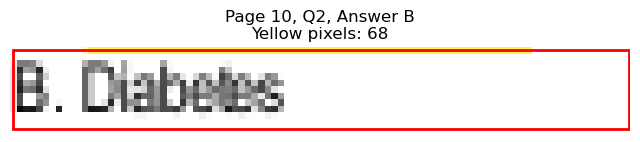

Page 10, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=135.2, y1=205.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 309
Page 10, Q2, C: Yellow percentage: 0.0%


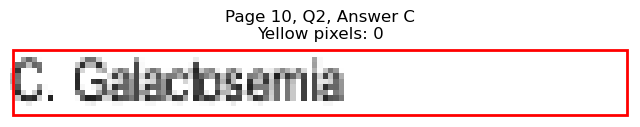

Page 10, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=400.3, y1=181.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 377
Page 10, Q2, D: Yellow percentage: 0.0%


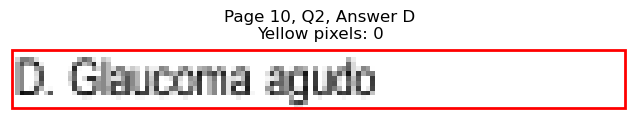

Page 10, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=396.5, y1=193.6
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 341
Page 10, Q2, E: Yellow percentage: 0.0%


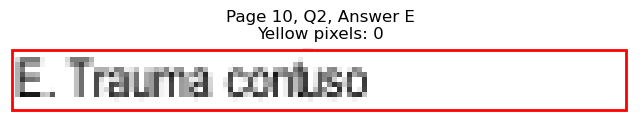


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=136.8, y1=241.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 544
Page 10, Q3, A: Yellow percentage: 0.0%


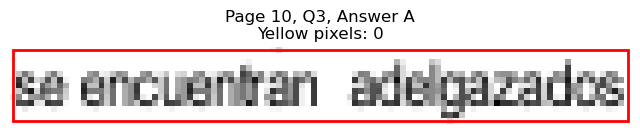

Page 10, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=132.2, y1=253.7
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 273
Page 10, Q3, B: Yellow percentage: 0.0%


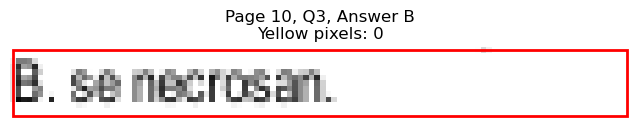

Page 10, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=183.4, y1=265.7
Page 10, Q3, C: Yellow pixels: 901
Page 10, Q3, C: Total non-white pixels: 1430
Page 10, Q3, C: Yellow percentage: 63.0%


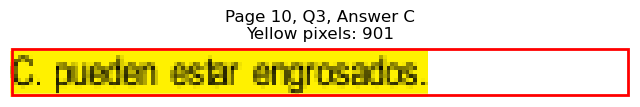

Page 10, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=383.0, y1=241.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 281
Page 10, Q3, D: Yellow percentage: 0.0%


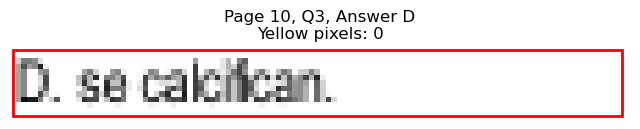

Page 10, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=412.3, y1=253.7
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 403
Page 10, Q3, E: Yellow percentage: 0.0%


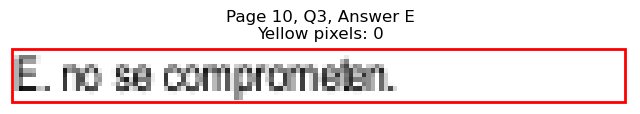


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=94.0, y1=301.8
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 58
Page 10, Q4, A: Yellow percentage: 0.0%


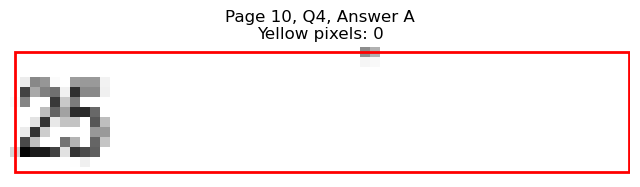

Page 10, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=88.7, y1=314.5
Page 10, Q4, B: Yellow pixels: 141
Page 10, Q4, B: Total non-white pixels: 208
Page 10, Q4, B: Yellow percentage: 67.8%


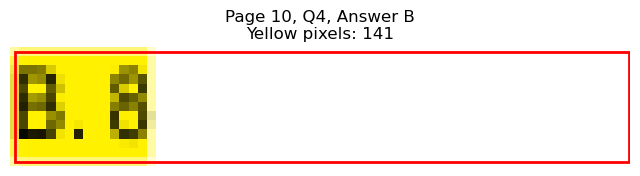

Page 10, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=100.8, y1=326.5
Page 10, Q4, C: Yellow pixels: 14
Page 10, Q4, C: Total non-white pixels: 121
Page 10, Q4, C: Yellow percentage: 11.6%


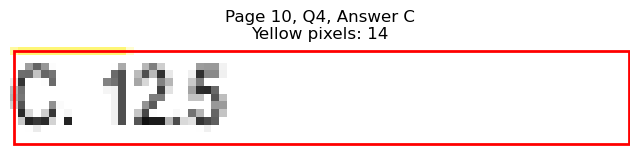

Page 10, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=341.0, y1=301.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 63
Page 10, Q4, D: Yellow percentage: 0.0%


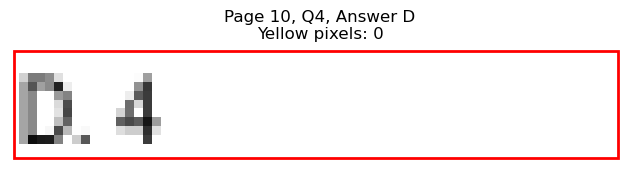

Page 10, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=351.5, y1=314.5
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 115
Page 10, Q4, E: Yellow percentage: 0.0%


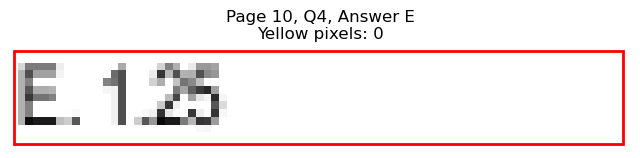


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=179.6, y1=362.5
Page 10, Q5, A: Yellow pixels: 823
Page 10, Q5, A: Total non-white pixels: 1249
Page 10, Q5, A: Yellow percentage: 65.9%


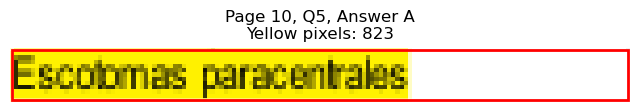

Page 10, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=139.0, y1=374.6
Page 10, Q5, B: Yellow pixels: 94
Page 10, Q5, B: Total non-white pixels: 423
Page 10, Q5, B: Yellow percentage: 22.2%


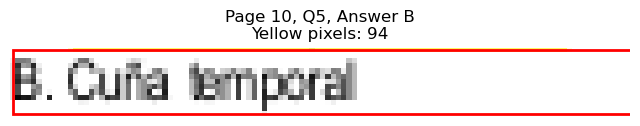

Page 10, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=167.4, y1=386.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 444
Page 10, Q5, C: Yellow percentage: 0.0%


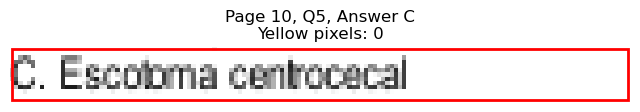

Page 10, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=420.5, y1=362.5
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 509
Page 10, Q5, D: Yellow percentage: 0.0%


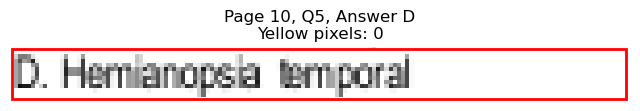

Page 10, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=398.8, y1=374.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 364
Page 10, Q5, E: Yellow percentage: 0.0%


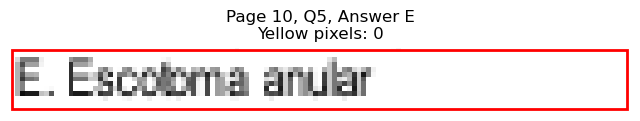


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=127.6, y0=434.6, x1=188.5, y1=446.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 308
Page 10, Q6, A: Yellow percentage: 0.0%


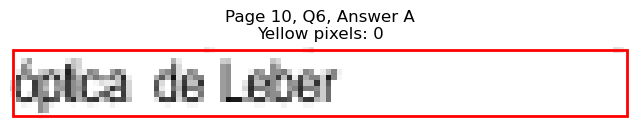

Page 10, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=167.4, y1=458.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 497
Page 10, Q6, B: Yellow percentage: 0.0%


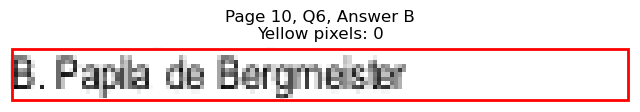

Page 10, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=149.5, y1=470.6
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 385
Page 10, Q6, C: Yellow percentage: 0.0%


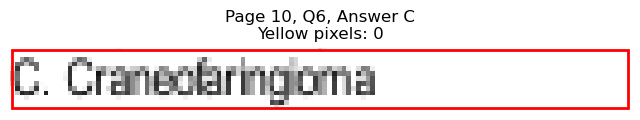

Page 10, Q6 - D: Detected box: x0=379.1, y0=434.6, x1=443.2, y1=446.6
Page 10, Q6, D: Yellow pixels: 474
Page 10, Q6, D: Total non-white pixels: 806
Page 10, Q6, D: Yellow percentage: 58.8%


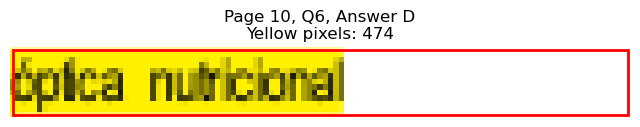

Page 10, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=415.4, y1=458.6
Page 10, Q6, E: Yellow pixels: 118
Page 10, Q6, E: Total non-white pixels: 581
Page 10, Q6, E: Yellow percentage: 20.3%


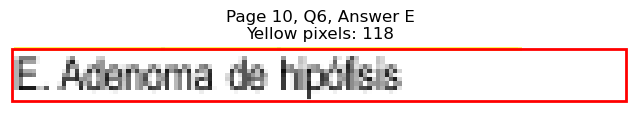


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=113.5, y1=507.4
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 148
Page 10, Q7, A: Yellow percentage: 0.0%


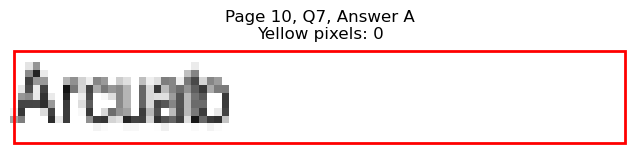

Page 10, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=126.2, y1=519.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 273
Page 10, Q7, B: Yellow percentage: 0.0%


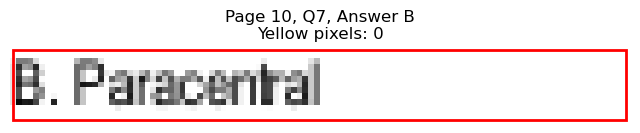

Page 10, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=137.5, y1=531.4
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 299
Page 10, Q7, C: Yellow percentage: 0.0%


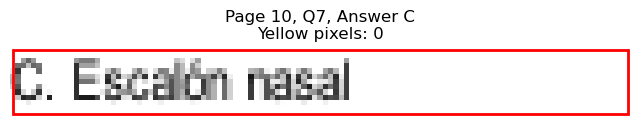

Page 10, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=401.1, y1=507.4
Page 10, Q7, D: Yellow pixels: 690
Page 10, Q7, D: Total non-white pixels: 1001
Page 10, Q7, D: Yellow percentage: 68.9%


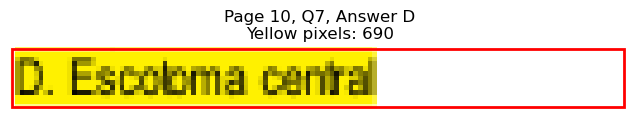

Page 10, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=369.5, y1=519.4
Page 10, Q7, E: Yellow pixels: 75
Page 10, Q7, E: Total non-white pixels: 307
Page 10, Q7, E: Yellow percentage: 24.4%


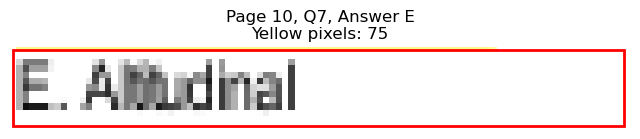


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=139.6, y0=555.4, x1=262.0, y1=567.5
Page 10, Q8, A: Yellow pixels: 1114
Page 10, Q8, A: Total non-white pixels: 1573
Page 10, Q8, A: Yellow percentage: 70.8%


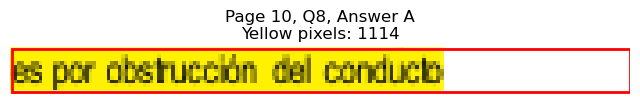

Page 10, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=282.9, y1=591.5
Page 10, Q8, B: Yellow pixels: 46
Page 10, Q8, B: Total non-white pixels: 1089
Page 10, Q8, B: Yellow percentage: 4.2%


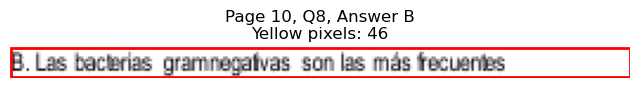

Page 10, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=275.4, y1=603.5
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 967
Page 10, Q8, C: Yellow percentage: 0.0%


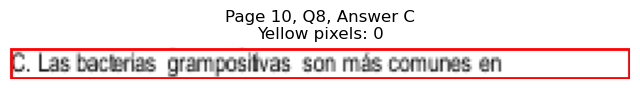

Page 10, Q8 - D: Detected box: x0=340.9, y0=555.4, x1=422.1, y1=567.5
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 643
Page 10, Q8, D: Yellow percentage: 0.0%


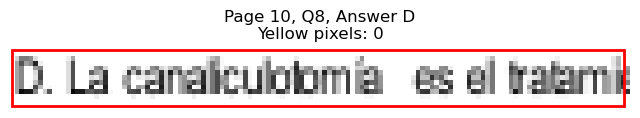

Page 10, Q8 - E: Detected box: x0=340.9, y0=567.5, x1=490.5, y1=579.5
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 724
Page 10, Q8, E: Yellow percentage: 0.0%


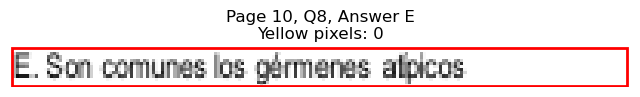


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=115.0, y1=651.6
Page 10, Q9, A: Yellow pixels: 250
Page 10, Q9, A: Total non-white pixels: 403
Page 10, Q9, A: Yellow percentage: 62.0%


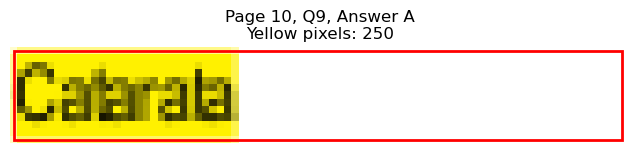

Page 10, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=122.5, y1=663.6
Page 10, Q9, B: Yellow pixels: 30
Page 10, Q9, B: Total non-white pixels: 268
Page 10, Q9, B: Yellow percentage: 11.2%


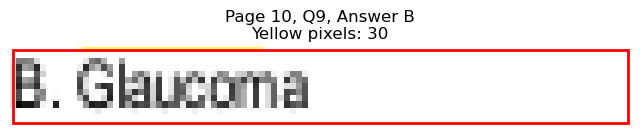

Page 10, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=118.7, y1=675.6
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 194
Page 10, Q9, C: Yellow percentage: 0.0%


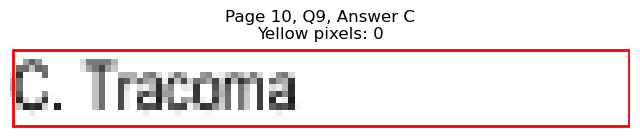

Page 10, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=376.3, y1=651.6
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 485
Page 10, Q9, D: Yellow percentage: 0.0%


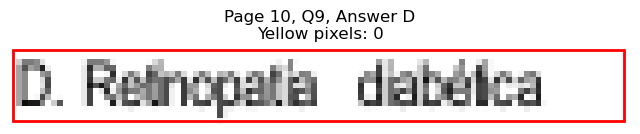

Page 10, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=376.3, y1=663.6
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 266
Page 10, Q9, E: Yellow percentage: 0.0%


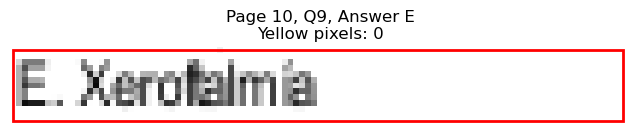


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál de los músculos extraoculares es el que ...
1   ¿A qué nivel se encuentra la separación de la ...
2   ¿Cuál es la distrofia hereditaria macular más ...
3   Varón de 20 años, con endotropía, que presenta...
4   En la clasificación citológica de los melanoma...
..                                                ...
95  ¿Cuál de los siguientes defectos del campo vis...
96  Varón de 48 años, alcohólico crónico, hace tre...
97  ¿Cuál es el defecto del campo visual más carac...
98  ¿Cuál es la característica de la dacriocistiti...
99        ¿Cuál es la causa más frecuente de ceguera?

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                 Recto superior   
1                       Capa de fibras nerviosas   
2        Degeneración macular asociada a la edad   
3      V por hiperfunción de oblicuos inferiores   
4                                      Fusiforme   
..                                           ...   
95                       Escotomas paracentrales   
96                    Neuropatía óptica de Leber   
97                                       Arcuato   
98  Generalmente es por obstrucción del conducto   
99                                      Catarata   

                                             option_B  \
0                                      Recto inferior   
1                  Segmento externo de fotoreceptores   
2     Distrofia corneorretiniana cristalina de Bietti   
3             V por hiperfunción de rectos superiores   
4                                            Adenoide   
..                                                ...   
95                                      Cuña temporal   
96                              Papila de Bergmeister   
97                                        Paracentral   
98  Las bacterias gramnegativas son las más frecue...   
99                                           Glaucoma   

                                          option_C  \
0                                 Oblicuo inferior   
1                          Capa plexiforme externa   
2                               Síndrome de Alport   
3             V por hipofunción de rectos mediales   
4                                            Mixto   
..                                             ...   
95                            Escotoma centrocecal   
96                                Craneofaringioma   
97                                   Escalón nasal   
98  Las bacterias grampositivas son más comunes en   
99                                         Tracoma   

                                            option_D  \
0                                   Oblicuo superior   
1                    Núcleo de las células bipolares   
2                            Enfermedad de Stargardt   
3            A por hiperfunción de rectos inferiores   
4                                        Epitelioide   
..                                               ...   
95                              Hemianopsia temporal   
96                     Neuropatía óptica nutricional   
97                                  Escotoma central   
98  La canaliculotomía es el tratamiento de elección   
99                             Retinopatía diabética   

                                     option_E  
0                               Recto lateral  
1                  Membrana limitante externa  
2                        Enfermedad de Oguchi  
3   A por hiperfunción de oblicuos superiores  
4                                   Folicular  
..                                        ...  
95                            Escotoma anular  
96                       Adenoma de hipófisis  
97                                Altitudinal  
98          Son comunes los gérmenes atípicos  
99                                Xeroftalmía  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál de los músculos extraoculares es el que ...   
1   ¿A qué nivel se encuentra la separación de la ...   
2   ¿Cuál es la distrofia hereditaria macular más ...   
3   Varón de 20 años, con endotropía, que presenta...   
4   En la clasificación citológica de los melanoma...   
..                                                ...   
95  ¿Cuál de los siguientes defectos del campo vis...   
96  Varón de 48 años, alcohólico crónico, hace tre...   
97  ¿Cuál es el defecto del campo visual más carac...   
98  ¿Cuál es la característica de la dacriocistiti...   
99        ¿Cuál es la causa más frecuente de ceguera?   

                                        option_A  \
0                                 Recto superior   
1                       Capa de fibras nerviosas   
2        Degeneración macular asociada a la edad   
3      V por hiperfunción de oblicuos inferiores   
4                                      Fusiforme   
..                                           ...   
95                       Escotomas paracentrales   
96                    Neuropatía óptica de Leber   
97                                       Arcuato   
98  Generalmente es por obstrucción del conducto   
99                                      Catarata   

                                             option_B  \
0                                      Recto inferior   
1                  Segmento externo de fotoreceptores   
2     Distrofia corneorretiniana cristalina de Bietti   
3             V por hiperfunción de rectos superiores   
4                                            Adenoide   
..                                                ...   
95                                      Cuña temporal   
96                              Papila de Bergmeister   
97                                        Paracentral   
98  Las bacterias gramnegativas son las más frecue...   
99                                           Glaucoma   

                                          option_C  \
0                                 Oblicuo inferior   
1                          Capa plexiforme externa   
2                               Síndrome de Alport   
3             V por hipofunción de rectos mediales   
4                                            Mixto   
..                                             ...   
95                            Escotoma centrocecal   
96                                Craneofaringioma   
97                                   Escalón nasal   
98  Las bacterias grampositivas son más comunes en   
99                                         Tracoma   

                                            option_D  \
0                                   Oblicuo superior   
1                    Núcleo de las células bipolares   
2                            Enfermedad de Stargardt   
3            A por hiperfunción de rectos inferiores   
4                                        Epitelioide   
..                                               ...   
95                              Hemianopsia temporal   
96                     Neuropatía óptica nutricional   
97                                  Escotoma central   
98  La canaliculotomía es el tratamiento de elección   
99                             Retinopatía diabética   

                                     option_E correct_answer  
0                               Recto lateral              C  
1                  Membrana limitante externa              A  
2                        Enfermedad de Oguchi              D  
3   A por hiperfunción de oblicuos superiores              E  
4                                   Folicular              D  
..                                        ...            ...  
95                            Escotoma anular              A  
96                       Adenoma de hipófisis              D  
97                                Altitudinal              D  
98          Son comunes los gérmenes atípicos              A  
99                                

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/OFTALMOLOGIA.csv
